# Load packages and functions

In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import seaborn as sns
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import palettable
import plotly_express as px
from plotnine import *
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, auc, f1_score, roc_auc_score, average_precision_score
import sklearn.metrics as sk
import scanpy as sc
import anndata as ad
from typing import Any, Callable, Optional, Union
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
from pysankey2.datasets import load_fruits
from pysankey2.utils import setColorConf
from pysankey2 import Sankey
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from scipy import stats
from rogi import RoughnessIndex
from scipy.stats import pearsonr, spearmanr, kendalltau
import json
import itertools
plt.rcParams['font.family'] = 'sans-serif'

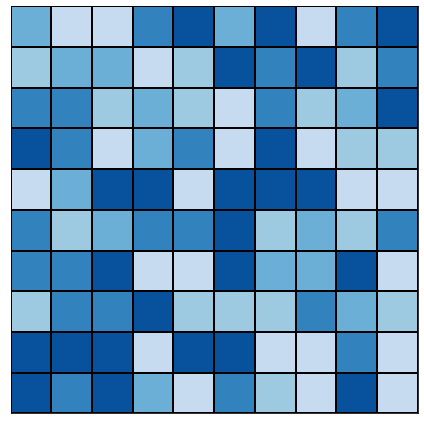

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# 创建一个随机矩阵 (可以替换为你的数据)
data = np.random.rand(10, 10)  # 10x10矩阵

# 自定义颜色渐变 
# blues
cmap = ListedColormap(["#c6dbef", "#9ecae1", "#6baed6", "#3182bd", "#08519c"])
# greens
# cmap = ListedColormap(["#e5f5e0", "#c7e9c0", "#a1d99b", "#74c476", "#31a354"])

# 绘制矩阵
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(data, cmap=cmap)

# 在矩阵上添加格子线
for i in range(data.shape[0] + 1):
    ax.axhline(i - 0.5, color='black', linewidth=2)  # 水平线
for i in range(data.shape[1] + 1):
    ax.axvline(i - 0.5, color='black', linewidth=2)  # 垂直线

# 移除轴刻度线 (可选)
ax.set_xticks([])
ax.set_yticks([])

# 显示图像
plt.tight_layout()
# plt.savefig('../figures/pipeline_overview/gene_expression_matrix.png', dpi=300, bbox_inches='tight')

In [3]:
# Ref: https://github.com/biomed-AI/GraphCS
def accuracy_for_unkonw(preds, output_ratio, labels, number_unkonw, cut_off_ratio=0):
    total_konw_cells=len(labels)-number_unkonw
    index = np.where(np.array(output_ratio) > cut_off_ratio)[0]

    labels = labels[index]
    preds = preds[index]

    correct=sum(preds==labels)

    # print("correct, total_konw_cells: ", correct, total_konw_cells)
    return correct / total_konw_cells


def get_FPR(unknown_cell, FPR=0.05):
    number_unkonw = len(unknown_cell)
    cut_off_ratio = sorted(unknown_cell, reverse=True)[int(number_unkonw*FPR)]

    # print("cut_off_ratio value: ", cut_off_ratio)
    return cut_off_ratio, number_unkonw

In [ ]:
# Ref: https://github.com/wetliu/energy_ood/blob/master/utils/display_results.py
def stable_cumsum(arr, rtol=1e-05, atol=1e-08):
    """Use high precision for cumsum and check that final value matches sum
    Parameters
    ----------
    arr : array-like
        To be cumulatively summed as flat
    rtol : float
        Relative tolerance, see ``np.allclose``
    atol : float
        Absolute tolerance, see ``np.allclose``
    """
    out = np.cumsum(arr, dtype=np.float64)
    expected = np.sum(arr, dtype=np.float64)
    if not np.allclose(out[-1], expected, rtol=rtol, atol=atol):
        raise RuntimeError('cumsum was found to be unstable: '
                           'its last element does not correspond to sum')
    return out

def fpr_and_fdr_at_recall(y_true, y_score, recall_level=0.95, pos_label=None):
    classes = np.unique(y_true)
    if (pos_label is None and
            not (np.array_equal(classes, [0, 1]) or
                 np.array_equal(classes, [-1, 1]) or
                 np.array_equal(classes, [0]) or
                 np.array_equal(classes, [-1]) or
                 np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = stable_cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps      # add one because of zero-based indexing

    thresholds = y_score[threshold_idxs]

    recall = tps / tps[-1]

    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)      # [last_ind::-1]
    recall, fps, tps, thresholds = np.r_[recall[sl], 1], np.r_[fps[sl], 0], np.r_[tps[sl], 0], thresholds[sl]

    cutoff = np.argmin(np.abs(recall - recall_level))

    return fps[cutoff] / (np.sum(np.logical_not(y_true)))   # fps[cutoff]/(fps[cutoff] + tps[cutoff])


def get_measures(y_true, y_pred, recall_level=0.95):
    auroc = sk.roc_auc_score(y_true, y_pred)
    aupr = sk.average_precision_score(y_true, y_pred)
    fpr = fpr_and_fdr_at_recall(y_true, y_pred, recall_level)

    return auroc, aupr, fpr

In [5]:
def dominates(x, y):
    """
    检查解x是否支配解y
    """
    if (x >= y).all() and not (x == y).all():
        return True
    else:
        return False
        
def non_dominated_sort(population):
    # model_name: metrics
    fronts = [[]]  # 记录非支配前沿
    # S = []  # 支配的个体列表 
    # n_dominated = np.zeros(len(population))  # 每个个体被支配的个体数量
    S = defaultdict(list)
    n_dominated = defaultdict(int)
    
    for p in population.keys():
        # S.append([])  # 初始化支配个体的列表
        for q in population.keys():
            if dominates(population[p], population[q]):
                S[p].append(q)
            elif dominates(population[q], population[p]):
                n_dominated[p] += 1

        if n_dominated[p] == 0:
            fronts[0].append(p)  # p 是第一前沿的一部分

    i = 0
    while fronts[i]:
        Q = []  # 下一前沿
        for p in fronts[i]:
            for q in S[p]:
                n_dominated[q] -= 1
                if n_dominated[q] == 0:
                    Q.append(q)  # q 是下一前沿的一部分
        i += 1
        fronts.append(Q)  # 记录下一前沿

    return fronts[:-1]  # 返回前沿（去掉空列表）

In [6]:
_METRIC_TYPE = "Metric Type"
_AGGREGATE_SCORE = "Aggregate score"
def plot_results_table(
    df, min_max_scale: bool = True, show: bool = True, ouput_file: Optional[str] = None, sort_col="Overall"
) -> Table:
    """Plot the benchmarking results.

    Parameters
    ----------
    min_max_scale
        Whether to min max scale the results.
    show
        Whether to show the plot.
    ouput_file
        The directory to save the plot to. If `None`, the plot is not saved.
    """
    # num_embeds = len(self._embedding_obsm_keys)
    num_embeds = len(df.columns)-1
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)
    # df = self.get_results(min_max_scale=min_max_scale)
    # Do not want to plot what kind of metric it is
    plot_df = df.drop(_METRIC_TYPE, axis=0)
    # Sort by total score
    plot_df = plot_df.sort_values(by=sort_col, ascending=False).astype(np.float64)
    plot_df["Method"] = plot_df.index

    # Split columns by metric type, using df as it doesn't have the new method col
    score_cols = df.columns[df.loc[_METRIC_TYPE] == _AGGREGATE_SCORE]
    other_cols = df.columns[df.loc[_METRIC_TYPE] != _AGGREGATE_SCORE]
    column_definitions = [
        ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ]
    # Circles for the metric values
    column_definitions += [
        ColumnDefinition(
            col,
            title=col.replace(" ", "\n", 1),
            width=1,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(plot_df[col]),
            group=df.loc[_METRIC_TYPE, col],
            formatter="{:.2f}",
        )
        for i, col in enumerate(other_cols)
    ]
    # Bars for the aggregate scores
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": matplotlib.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.3f}",
                "alpha": 0.6, 
            },
            group=df.loc[_METRIC_TYPE, col],
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(score_cols)
    ]
    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1.5, 3 + 0.3 * num_embeds), dpi=300)
        tab = Table(
            plot_df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=plot_df.columns)
    if show:
        plt.show()
    if ouput_file is not None:
        fig.savefig(ouput_file, facecolor=ax.get_facecolor(), dpi=300, bbox_inches='tight')

    return tab

In [7]:
_METRIC_TYPE = "Metric Type"
_AGGREGATE_SCORE = "Aggregate score"
def barplot_results_table(
    df, min_max_scale: bool = True, show: bool = True, ouput_file: Optional[str] = None, sort_col="overall"
) -> Table:
    """Plot the benchmarking results.

    Parameters
    ----------
    min_max_scale
        Whether to min max scale the results.
    show
        Whether to show the plot.
    ouput_file
        The directory to save the plot to. If `None`, the plot is not saved.
    """
    # num_embeds = len(self._embedding_obsm_keys)
    num_embeds = len(df.columns)-1
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)
    # df = self.get_results(min_max_scale=min_max_scale)
    # Do not want to plot what kind of metric it is
    plot_df = df.drop(_METRIC_TYPE, axis=0)
    # Sort by total score
    plot_df = plot_df.sort_values(by=sort_col, ascending=False).astype(np.float64)
    plot_df["Method"] = plot_df.index

    column_definitions = [
        ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ]

    # Bars for the aggregate scores
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": matplotlib.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": False,
                "height": 0.9,
                "formatter": "{:.2f}",
                "alpha": 0.6, 
            },
            group=df.loc[_METRIC_TYPE, col],
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(df.columns)
    ]
    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1.5, 3 + 0.3 * num_embeds), dpi=300)
        tab = Table(
            plot_df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 8, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=plot_df.columns)
    if show:
        plt.show()
    if ouput_file is not None:
        fig.savefig(ouput_file, facecolor=ax.get_facecolor(), dpi=300, bbox_inches='tight')

    return tab

# Define plotting parameters

In [8]:
model_map_dict = {"X_geneformer": "Geneformer",
                  "X_langcell": "LangCell",
                  "X_scgpt": "scGPT",
                  "X_uce": "UCE",
                  "X_xtrimogene": "scFoundation",
                  "X_hvg": "HVG",
                  "X_scvi": "scVI",
                  "geneformer": "Geneformer",
                  "langcell": "LangCell",
                  "scgpt": "scGPT",
                  "uce": "UCE",
                  "xTrimoGene": "scFoundation",
                  "X": "Raw",
                  "scVI_integrated_tissue": "scVI",
                  "scVI_integrated_dataset": "scVI"}
model_order = ["Geneformer", "scGPT", "UCE", "scFoundation", "LangCell", "HVG", "scVI"]
model_order_wo_hvg = ["Geneformer", "scGPT", "UCE", "scFoundation", "LangCell", "scVI"]
model_order_scFM = ["Geneformer", "scGPT", "UCE", "scFoundation", "LangCell"]
colors = ["#E89DA0", "#88CEE6", "#F6C8A8", "#B696B6", "#9FBA95", "#D6D6D6", "#999999"]
custom_palette = {model: color for model, color in zip(model_order, colors[:len(model_order)])}
custom_palette["Raw"] = custom_palette["HVG"]
shapes = ["o", "s", "p", "*", "^", "P", "X"]
custom_shape = {model: shape for model, shape in zip(model_order, shapes[:len(model_order)])}
custom_shape["Raw"] = custom_shape["HVG"]

In [9]:
dataset_map_dict = {"pancreas_scib": "Pancreas", 
                    "Immune_all_human": "Immune", 
                    "HLCA_core": "HLCA", 
                    "Tabula_Sapiens_all": "Tabula Sapiens"}

In [10]:
params_file = "../OnClass/results_gridsearch/model_to_params.json"
with open(params_file, "r") as f:
    model_to_params = json.load(f)

# Clustering

In [11]:
pd.set_option('display.precision', 4) 
df_all = pd.DataFrame()
for dataset in ["pancreas_scib", "Immune_all_human", "HLCA_core", "Tabula_Sapiens_all"]:
    output_folder = f"../output/{dataset}"
    df_dataset = pd.DataFrame()
    for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
        result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
        df_ = pd.read_csv(result_path, index_col=0)
        df_dataset = pd.concat([df_dataset, df_], axis=1)
    df_dataset = pd.DataFrame(df_dataset.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "scFoundation", "LangCell"], index=df_dataset.index)
    df_all = pd.concat([df_all, df_dataset[-1:]], axis=0)
df_all

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  LangCell
overall  0.8118  0.8549      0.4240  0.6647  0.6606        0.6257    0.6128
overall  0.7139  0.8103      0.6692  0.7046  0.7751        0.6384    0.6663
overall  0.7541  0.7799      0.6863  0.7660  0.7262        0.6726    0.6638
overall  0.6819  0.6665      0.5982  0.6447  0.6548        0.6629    0.6673

In [19]:
df_all.loc["mean",:] = df_all.mean(axis=0)
df_all

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  LangCell
overall  0.8118  0.8549      0.4240  0.6647  0.6606        0.6257    0.6128
overall  0.7139  0.8103      0.6692  0.7046  0.7751        0.6384    0.6663
overall  0.7541  0.7799      0.6863  0.7660  0.7262        0.6726    0.6638
overall  0.6819  0.6665      0.5982  0.6447  0.6548        0.6629    0.6673
mean     0.7404  0.7779      0.5944  0.6950  0.7042        0.6499    0.6526

## Pancreas_scib

In [63]:
pd.set_option('display.precision', 4) 
output_folder = "../output/pancreas_scib"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "scFoundation", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI_cluster/label  0.8245  0.9055      0.3706  0.6229  0.5934        0.5631   
ARI_cluster/label  0.7655  0.9383      0.1510  0.4046  0.4068        0.3705   
ASW_label          0.5660  0.5684      0.3742  0.5307  0.5482        0.5260   
graph_conn         0.9634  0.9918      0.6935  0.9161  0.9136        0.8761   
ASW_label/batch    0.9396  0.8708      0.5306  0.8494  0.8412        0.7929   
avg_bio            0.7187  0.8040      0.2986  0.5194  0.5161        0.4865   
avg_batch          0.9515  0.9313      0.6121  0.8827  0.8774        0.8345   
overall            0.8118  0.8549      0.4240  0.6647  0.6606        0.6257   

                   LangCell  
NMI_cluster/label    0.5657  
ARI_cluster/label    0.3214  
ASW_label            0.5165  
graph_conn           0.8681  
ASW_label/batch      0.7921  
avg_bio              0.4679  
avg_batch            0.8301  
overall              0.6128

In [64]:
scib_metrics_dict = {"NMI_cluster/label": "NMI", 
                     "ARI_cluster/label": "ARI", 
                     "ASW_label": r"ASW$_{cell}$", 
                     "ASW_label/batch": r"ASW$_{batch}$",
                     "avg_bio": "AvgBio",
                     "avg_batch": "AvgBatch",
                     "overall": "Overall"}
df.rename(index=scib_metrics_dict, inplace=True)
df

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI            0.8245  0.9055      0.3706  0.6229  0.5934        0.5631   
ARI            0.7655  0.9383      0.1510  0.4046  0.4068        0.3705   
ASW$_{cell}$   0.5660  0.5684      0.3742  0.5307  0.5482        0.5260   
graph_conn     0.9634  0.9918      0.6935  0.9161  0.9136        0.8761   
ASW$_{batch}$  0.9396  0.8708      0.5306  0.8494  0.8412        0.7929   
AvgBio         0.7187  0.8040      0.2986  0.5194  0.5161        0.4865   
AvgBatch       0.9515  0.9313      0.6121  0.8827  0.8774        0.8345   
Overall        0.8118  0.8549      0.4240  0.6647  0.6606        0.6257   

               LangCell  
NMI              0.5657  
ARI              0.3214  
ASW$_{cell}$     0.5165  
graph_conn       0.8681  
ASW$_{batch}$    0.7921  
AvgBio           0.4679  
AvgBatch         0.8301  
Overall          0.6128

In [65]:
# avg_bio and avg_batch
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI']
Front 2: ['scGPT']
Front 3: ['UCE']
Front 4: ['scFoundation']
Front 5: ['LangCell']
Front 6: ['Geneformer']


In [66]:
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
df

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI            0.8245  0.9055      0.3706  0.6229  0.5934        0.5631   
ARI            0.7655  0.9383      0.1510  0.4046  0.4068        0.3705   
ASW$_{cell}$   0.5660  0.5684      0.3742  0.5307  0.5482        0.5260   
graph_conn     0.9634  0.9918      0.6935  0.9161  0.9136        0.8761   
ASW$_{batch}$  0.9396  0.8708      0.5306  0.8494  0.8412        0.7929   
AvgBio         0.7187  0.8040      0.2986  0.5194  0.5161        0.4865   
AvgBatch       0.9515  0.9313      0.6121  0.8827  0.8774        0.8345   
Overall        0.8118  0.8549      0.4240  0.6647  0.6606        0.6257   

               LangCell       Metric Type  
NMI              0.5657  Bio conservation  
ARI              0.3214  Bio conservation  
ASW$_{cell}$     0.5165  Bio conservation  
graph_conn       0.8681  Batch correction  
ASW$_{batch}$    0.7921  Batch correction  
AvgBio           0.4679   Aggregate score  
AvgBatch         0.8301   Aggregate score  
Overall          0.6128   Aggregate score

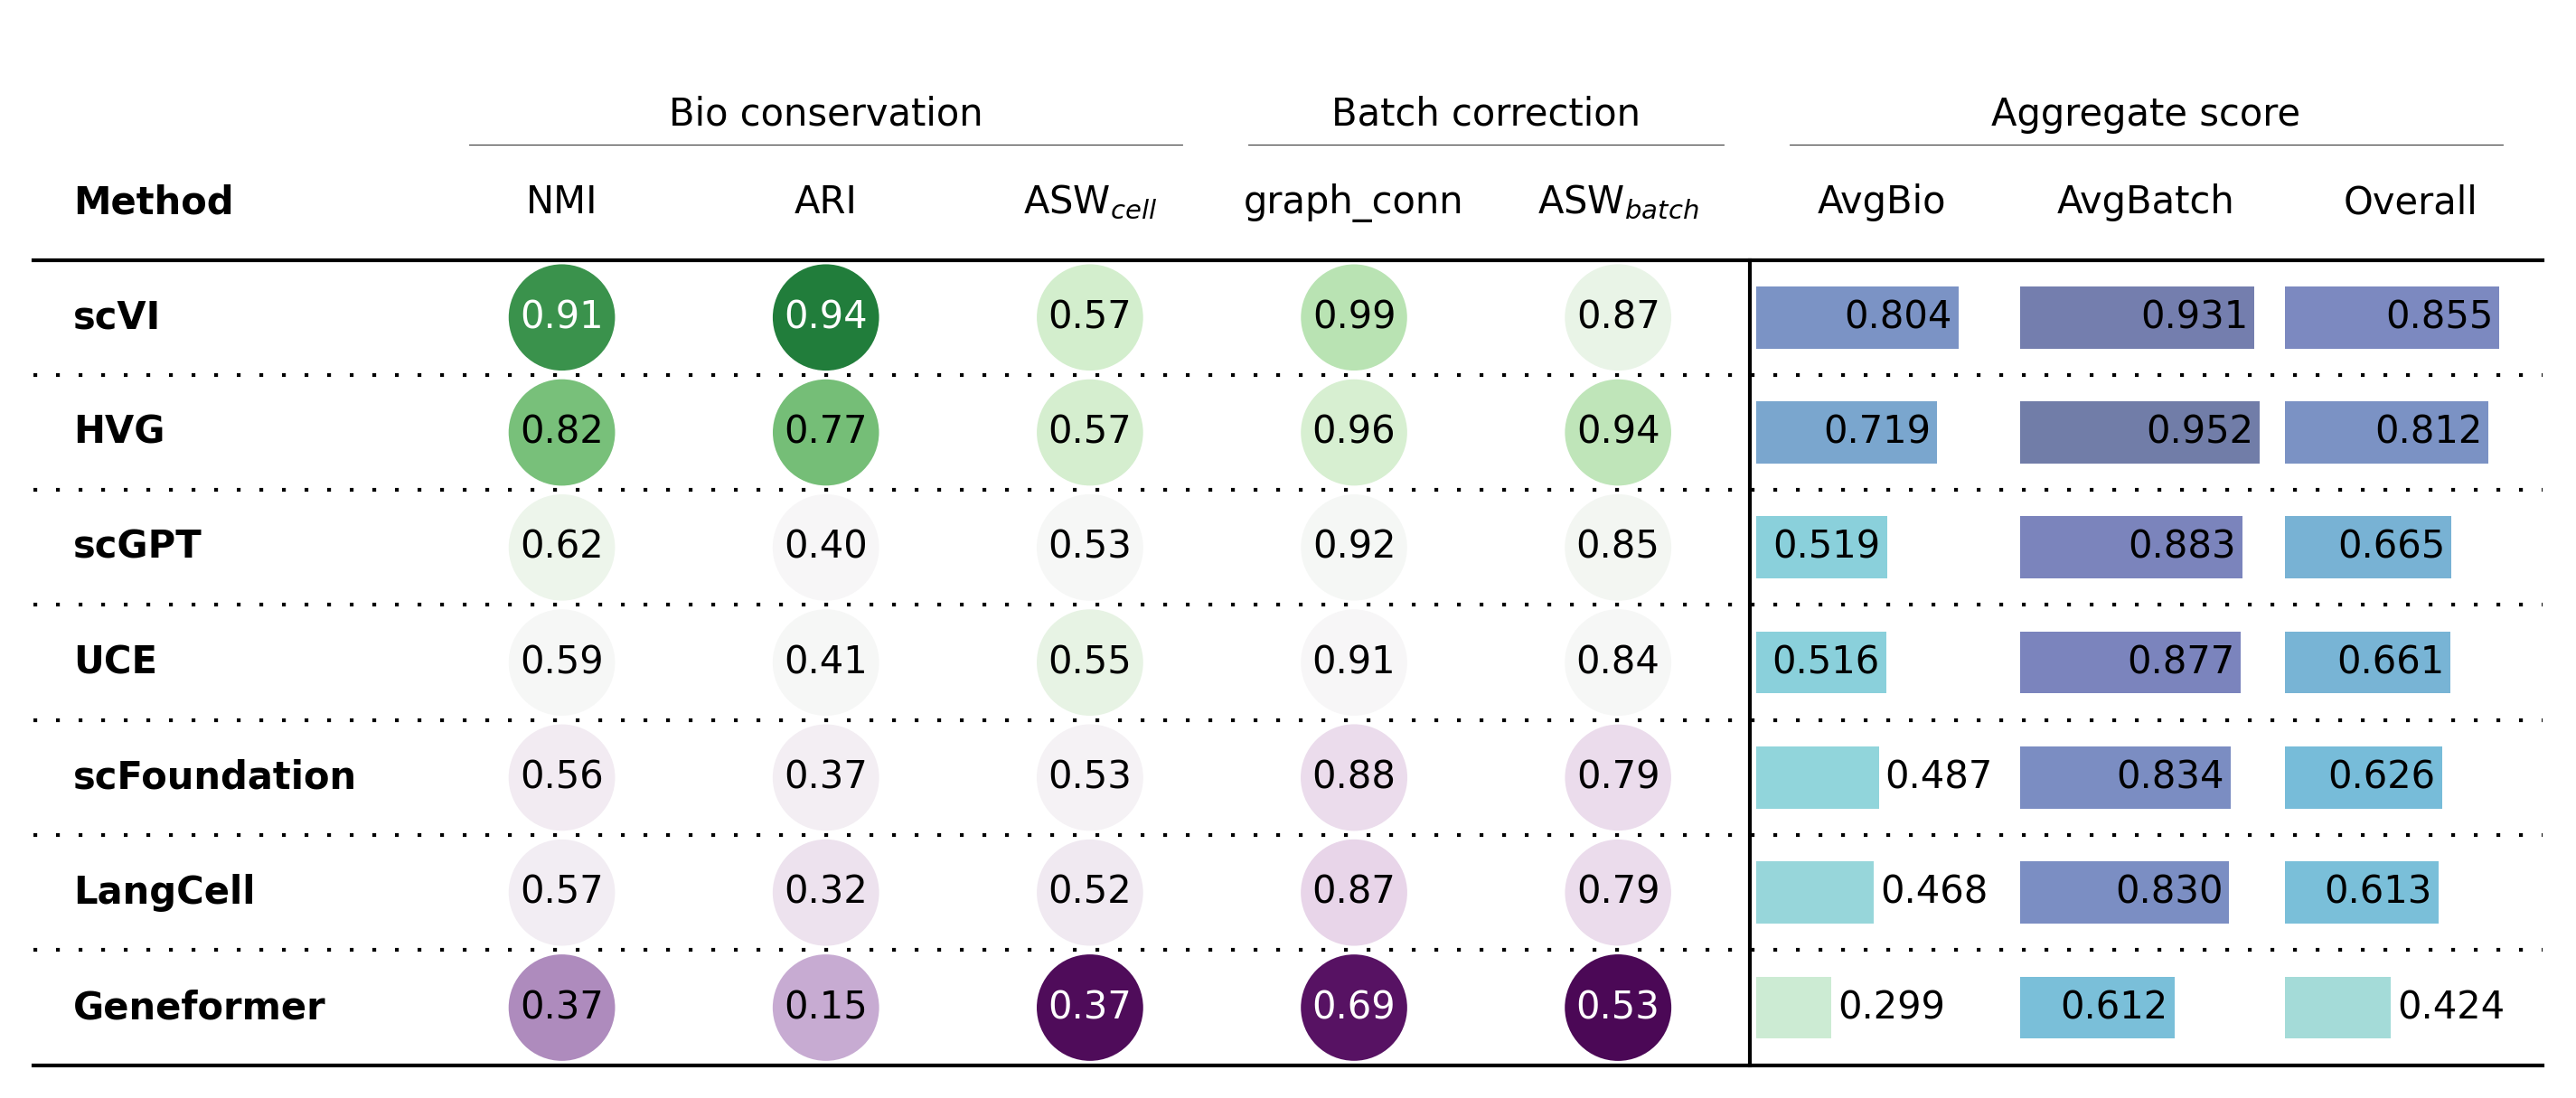

In [67]:
plot_results_table(df.T)

In [68]:
data = df.iloc[:, :-1].T
data["model"] = data.index
data

NMI     ARI  ASW$_{cell}$  graph_conn  ASW$_{batch}$  AvgBio  \
HVG           0.8245  0.7655        0.5660      0.9634         0.9396  0.7187   
scVI          0.9055  0.9383        0.5684      0.9918         0.8708  0.8040   
Geneformer    0.3706  0.1510        0.3742      0.6935         0.5306  0.2986   
scGPT         0.6229  0.4046        0.5307      0.9161         0.8494  0.5194   
UCE           0.5934  0.4068        0.5482      0.9136         0.8412  0.5161   
scFoundation  0.5631  0.3705        0.5260      0.8761         0.7929  0.4865   
LangCell      0.5657  0.3214        0.5165      0.8681         0.7921  0.4679   

              AvgBatch  Overall         model  
HVG             0.9515   0.8118           HVG  
scVI            0.9313   0.8549          scVI  
Geneformer      0.6121   0.4240    Geneformer  
scGPT           0.8827   0.6647         scGPT  
UCE             0.8774   0.6606           UCE  
scFoundation    0.8345   0.6257  scFoundation  
LangCell        0.8301   0.6128      LangCell

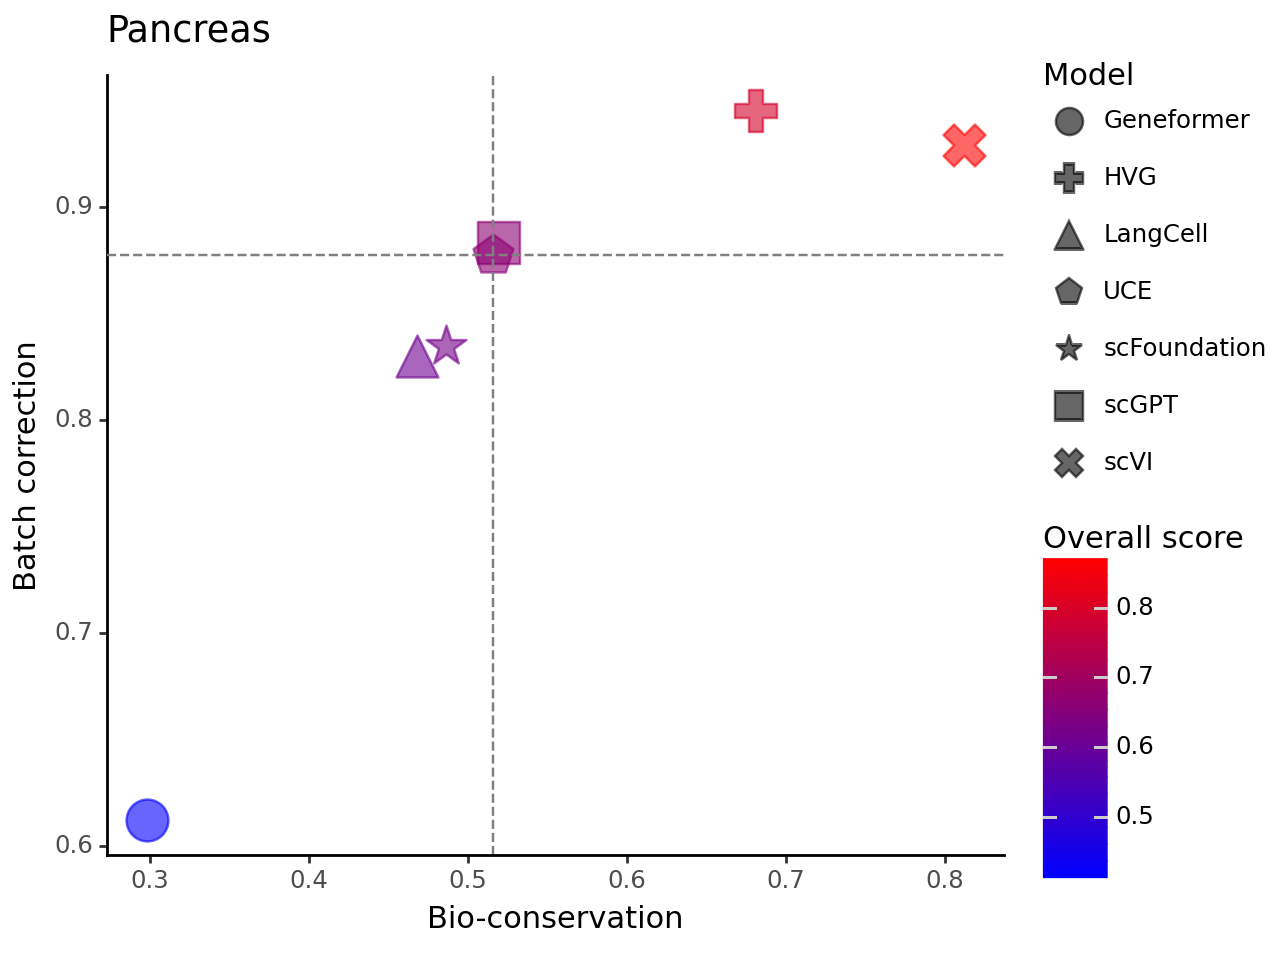

<Figure Size: (640 x 480)>

In [144]:
ggplot(data, aes(x='avg_bio', y='avg_batch', color="overall", shape="model")) \
    + scale_shape_manual(custom_shape) \
    + scale_color_gradient(low="blue", high="red") \
    + geom_point(size=8, alpha=0.6) \
    + guides( 
        size=False,
        shape=guide_legend(title="Model",override_aes={"size":5}), 
        color=guide_colorbar(title="Overall score")
    ) \
    + geom_vline(xintercept=data["avg_bio"].median(), linetype="dashed", color="grey") \
    + geom_hline(yintercept=data["avg_batch"].median(), linetype="dashed", color="grey") \
    + xlab("Bio-conservation") \
    + ylab("Batch correction") \
    + ggtitle("Pancreas") \
    + theme_classic()

## Immune

In [69]:
output_folder = "../output/Immune_all_human"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "scFoundation", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI_cluster/label  0.6736  0.8160      0.6200  0.6446  0.7732        0.6466   
ARI_cluster/label  0.4835  0.8268      0.4481  0.5333  0.7212        0.2730   
ASW_label          0.5119  0.5455      0.5073  0.5452  0.5603        0.5733   
graph_conn         0.9530  0.9684      0.9088  0.8982  0.9365        0.8740   
ASW_label/batch    0.9472  0.8948      0.8617  0.9018  0.8845        0.8250   
avg_bio            0.5563  0.7294      0.5251  0.5744  0.6849        0.4976   
avg_batch          0.9501  0.9316      0.8853  0.9000  0.9105        0.8495   
overall            0.7139  0.8103      0.6692  0.7046  0.7751        0.6384   

                   LangCell  
NMI_cluster/label    0.6836  
ARI_cluster/label    0.3875  
ASW_label            0.5463  
graph_conn           0.8682  
ASW_label/batch      0.8458  
avg_bio              0.5391  
avg_batch            0.8570  
overall              0.6663

In [26]:
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI']
Front 2: ['UCE']
Front 3: ['scGPT']
Front 4: ['Geneformer', 'LangCell']
Front 5: ['scFoundation']


In [70]:
df.rename(index=scib_metrics_dict, inplace=True)
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
df

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI            0.6736  0.8160      0.6200  0.6446  0.7732        0.6466   
ARI            0.4835  0.8268      0.4481  0.5333  0.7212        0.2730   
ASW$_{cell}$   0.5119  0.5455      0.5073  0.5452  0.5603        0.5733   
graph_conn     0.9530  0.9684      0.9088  0.8982  0.9365        0.8740   
ASW$_{batch}$  0.9472  0.8948      0.8617  0.9018  0.8845        0.8250   
AvgBio         0.5563  0.7294      0.5251  0.5744  0.6849        0.4976   
AvgBatch       0.9501  0.9316      0.8853  0.9000  0.9105        0.8495   
Overall        0.7139  0.8103      0.6692  0.7046  0.7751        0.6384   

               LangCell       Metric Type  
NMI              0.6836  Bio conservation  
ARI              0.3875  Bio conservation  
ASW$_{cell}$     0.5463  Bio conservation  
graph_conn       0.8682  Batch correction  
ASW$_{batch}$    0.8458  Batch correction  
AvgBio           0.5391   Aggregate score  
AvgBatch         0.8570   Aggregate score  
Overall          0.6663   Aggregate score

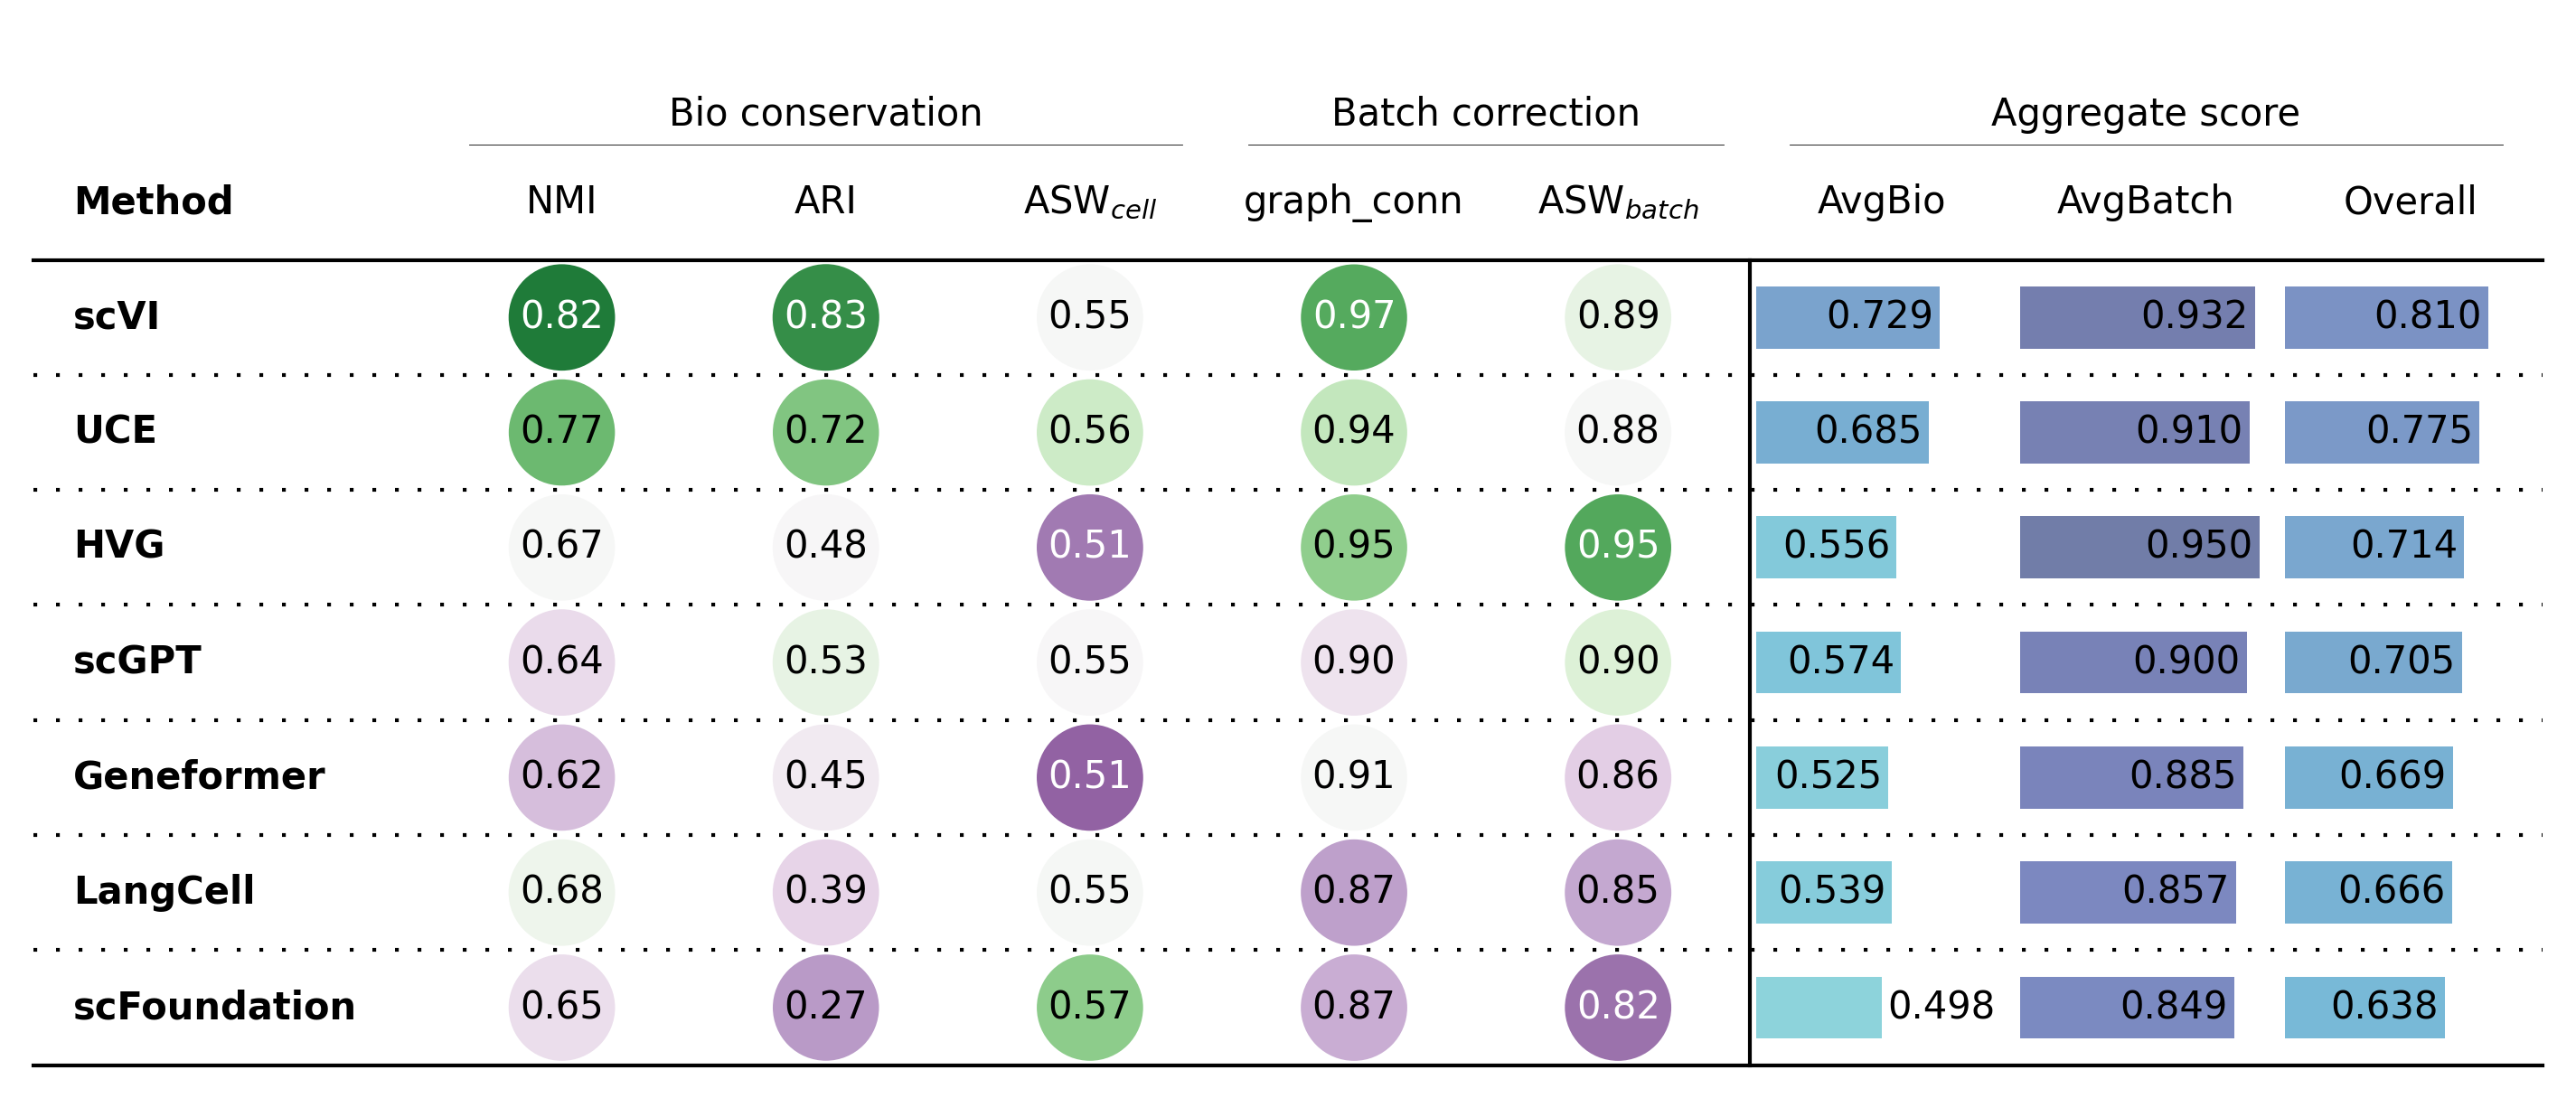

In [71]:
plot_results_table(df.T)

In [148]:
data = df.iloc[:, :-1].T
data["model"] = data.index
data

NMI_cluster/label  ARI_cluster/label  ASW_label  graph_conn  \
HVG                      0.6665             0.3710     0.5154      0.9155   
scVI                     0.8043             0.8214     0.5252      0.9739   
Geneformer               0.6200             0.4481     0.5073      0.9088   
scGPT                    0.6446             0.5333     0.5452      0.8982   
UCE                      0.7732             0.7212     0.5603      0.9365   
scFoundation             0.6466             0.2730     0.5733      0.8740   
LangCell                 0.6836             0.3875     0.5463      0.8682   

              ASW_label/batch  avg_bio  avg_batch  overall         model  
HVG                    0.9417   0.5176     0.9286   0.6820           HVG  
scVI                   0.9116   0.7170     0.9427   0.8073          scVI  
Geneformer             0.8617   0.5251     0.8853   0.6692    Geneformer  
scGPT                  0.9018   0.5744     0.9000   0.7046         scGPT  
UCE                    0.8845   0.6849     0.9105   0.7751           UCE  
scFoundation           0.8250   0.4976     0.8495   0.6384  scFoundation  
LangCell               0.8458   0.5391     0.8570   0.6663      LangCell

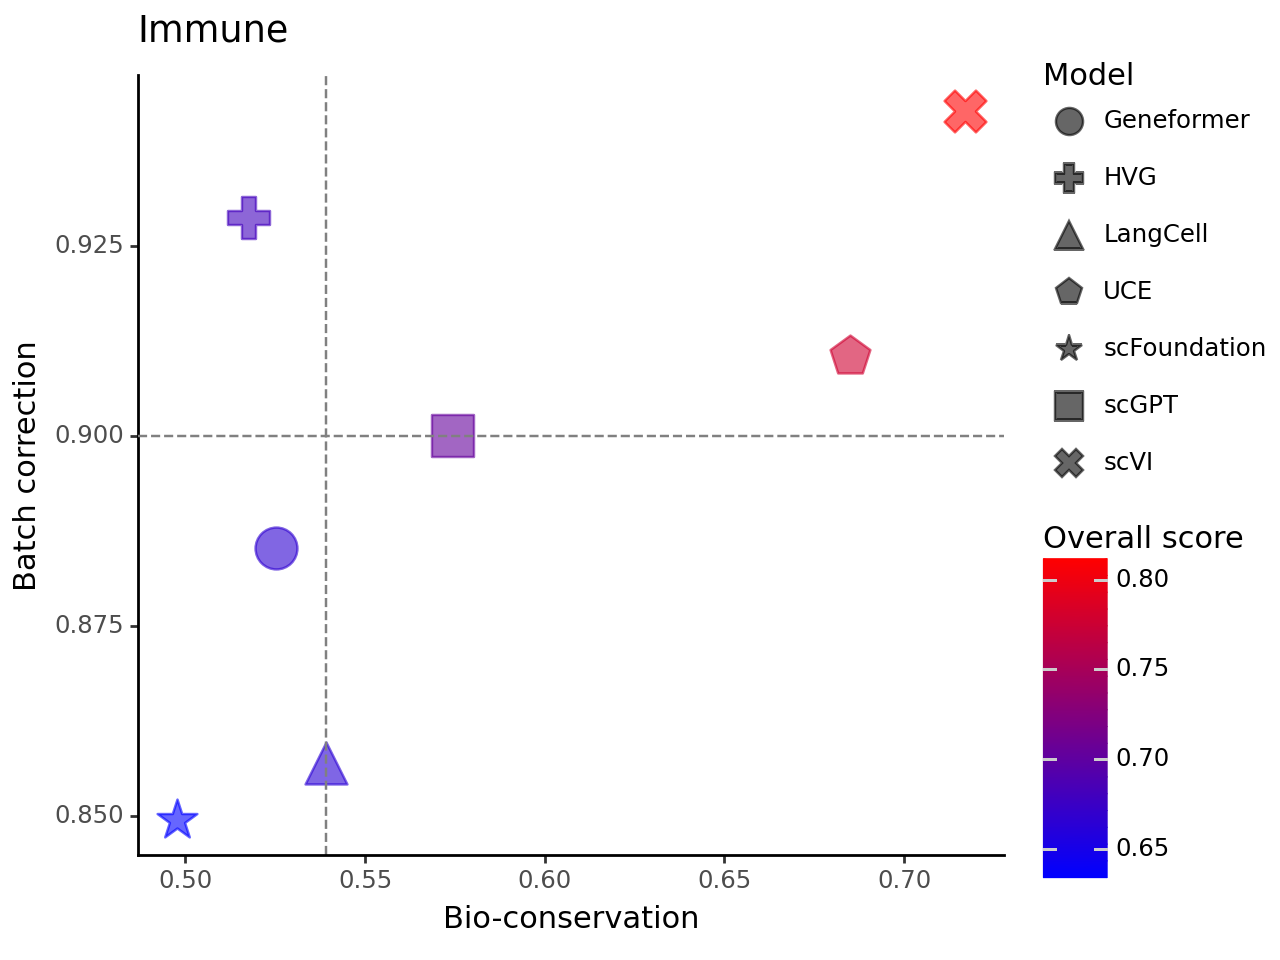

<Figure Size: (640 x 480)>

In [149]:
ggplot(data, aes(x='avg_bio', y='avg_batch', color="overall", shape="model")) \
    + scale_shape_manual(custom_shape) \
    + scale_color_gradient(low="blue", high="red") \
    + geom_point(size=8, alpha=0.6) \
    + guides( 
        size=False,
        shape=guide_legend(title="Model",override_aes={"size":5}), 
        color=guide_colorbar(title="Overall score")
    ) \
    + geom_vline(xintercept=data["avg_bio"].median(), linetype="dashed", color="grey") \
    + geom_hline(yintercept=data["avg_batch"].median(), linetype="dashed", color="grey") \
    + xlab("Bio-conservation") \
    + ylab("Batch correction") \
    + ggtitle("Immune") \
    + theme_classic()
    # + theme(legend_key_size=10)

## HLCA

In [72]:
dataset_name = "HLCA_core"
output_folder = f"../output/{dataset_name}"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "scFoundation", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI_cluster/label  0.7605  0.8090      0.6662  0.7736  0.7337        0.6749   
ARI_cluster/label  0.5715  0.6528      0.4476  0.6651  0.4667        0.3038   
ASW_label          0.5220  0.5395      0.4981  0.5098  0.5646        0.5543   
graph_conn         0.9794  0.9930      0.9358  0.9634  0.9810        0.9773   
ASW_label/batch    0.9369  0.9051      0.8840  0.9180  0.8847        0.8525   
avg_bio            0.6180  0.6671      0.5373  0.6495  0.5883        0.5110   
avg_batch          0.9582  0.9490      0.9099  0.9407  0.9329        0.9149   
overall            0.7541  0.7799      0.6863  0.7660  0.7262        0.6726   

                   LangCell  
NMI_cluster/label    0.6638  
ARI_cluster/label    0.3275  
ASW_label            0.5258  
graph_conn           0.9291  
ASW_label/batch      0.8730  
avg_bio              0.5057  
avg_batch            0.9011  
overall              0.6638

In [294]:
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI']
Front 2: ['scGPT']
Front 3: ['UCE']
Front 4: ['Geneformer', 'scFoundation']
Front 5: ['LangCell']


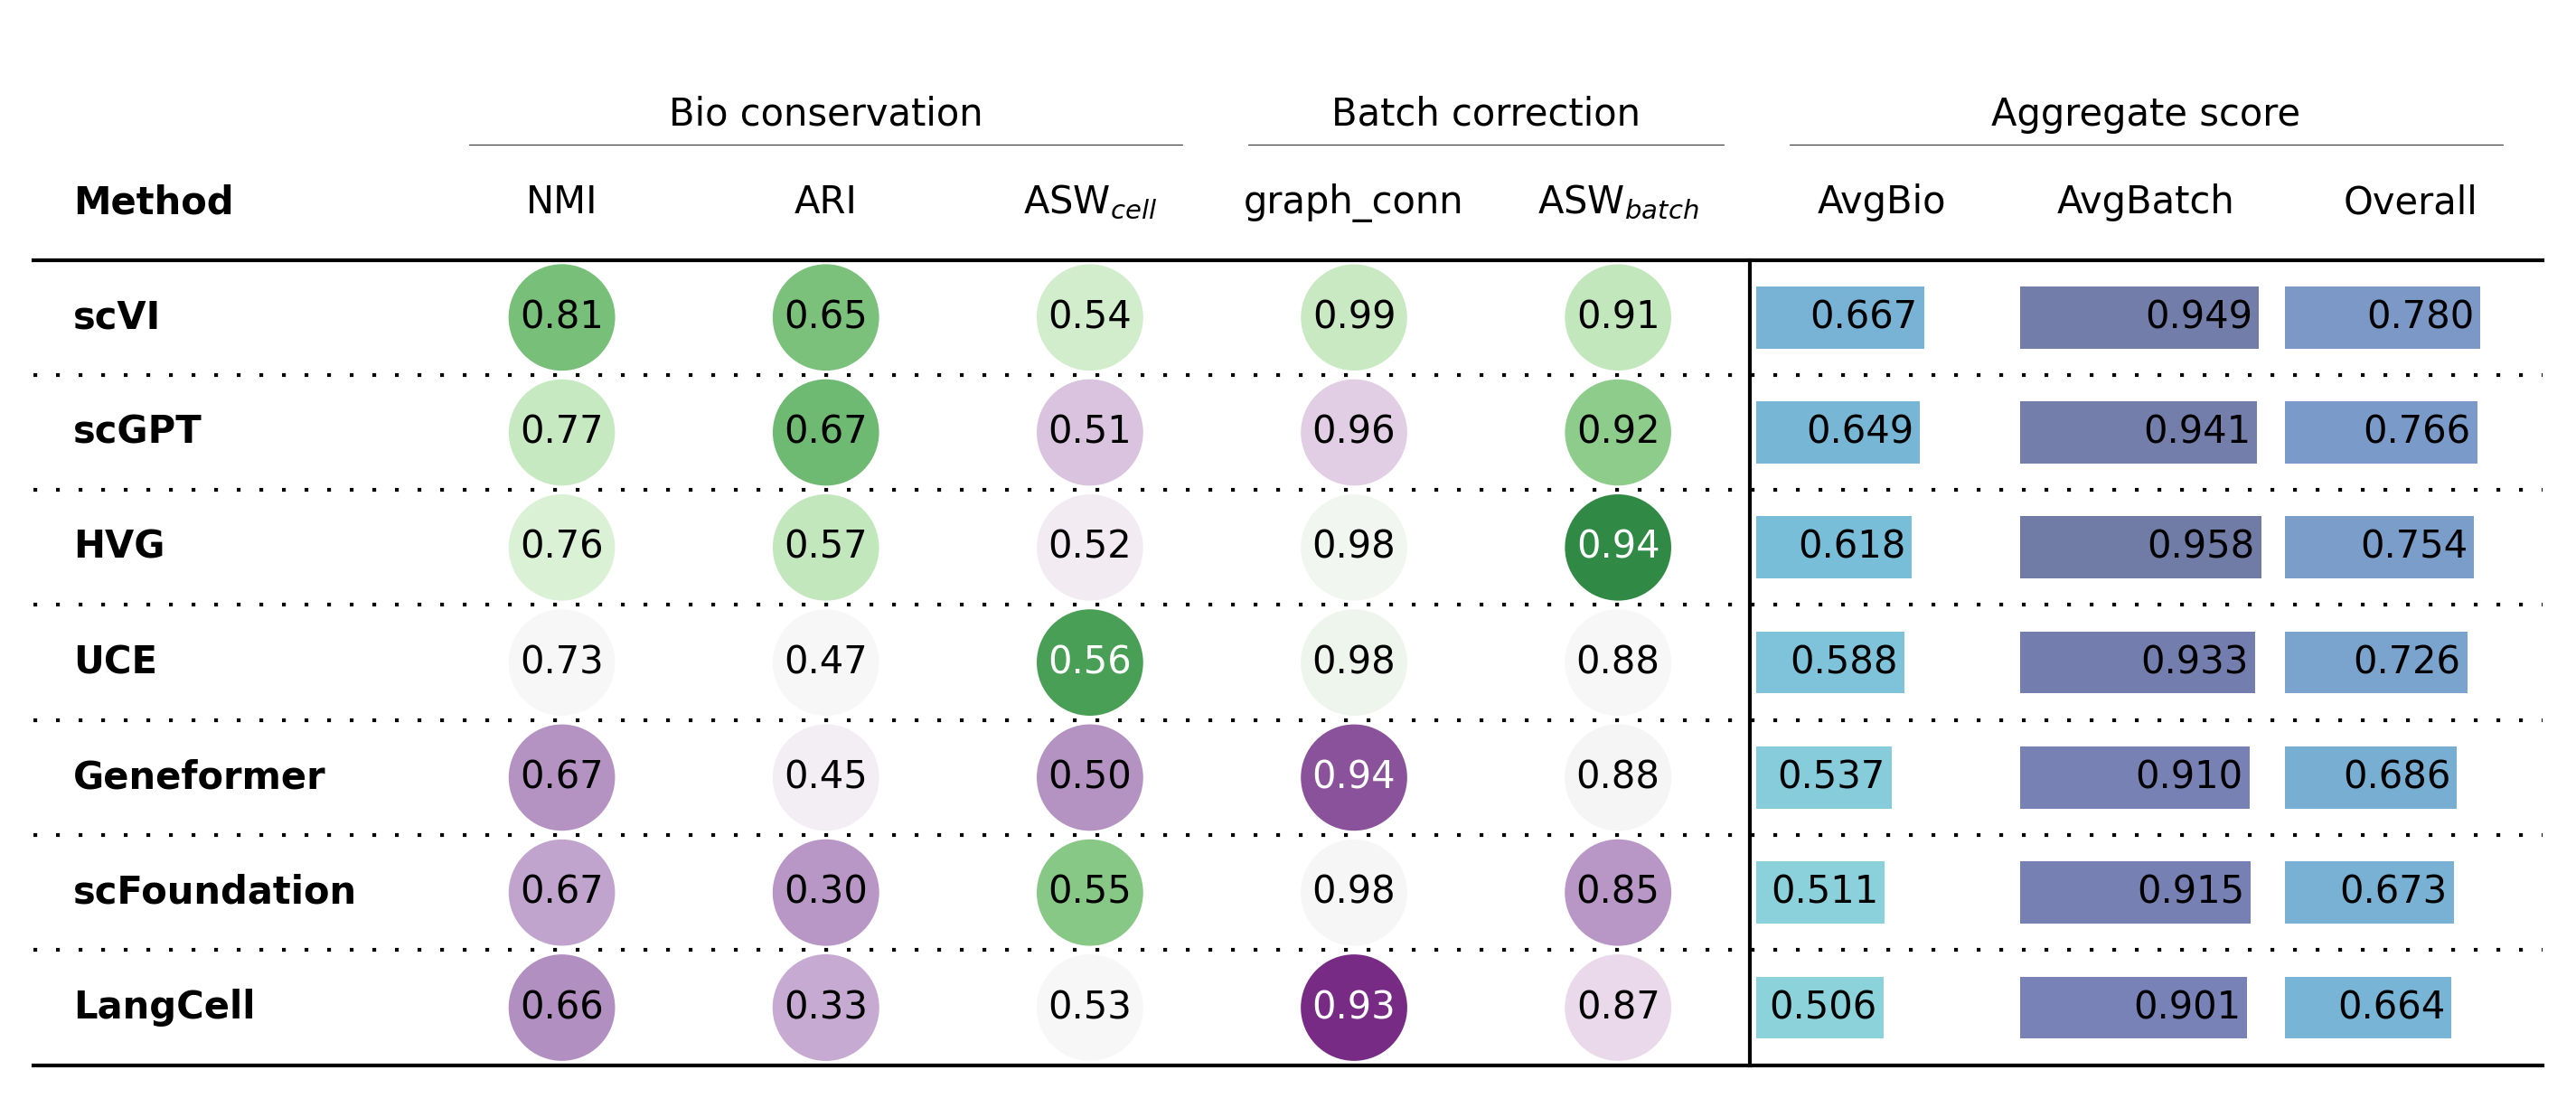

In [73]:
df.rename(index=scib_metrics_dict, inplace=True)
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
plot_results_table(df.T)

In [154]:
data = df.iloc[:, :-1].T
data["model"] = data.index
data

NMI_cluster/label  ARI_cluster/label  ASW_label  graph_conn  \
HVG                      0.7550             0.5386     0.5197      0.9796   
scVI                     0.8123             0.7037     0.5324      0.9870   
Geneformer               0.6662             0.4476     0.4981      0.9358   
scGPT                    0.7736             0.6651     0.5098      0.9634   
UCE                      0.7337             0.4667     0.5646      0.9810   
scFoundation             0.6749             0.3038     0.5543      0.9773   
LangCell                 0.6638             0.3275     0.5258      0.9291   

              ASW_label/batch  avg_bio  avg_batch  overall         model  
HVG                    0.9348   0.6044     0.9572   0.7456           HVG  
scVI                   0.9109   0.6828     0.9489   0.7892          scVI  
Geneformer             0.8840   0.5373     0.9099   0.6863    Geneformer  
scGPT                  0.9180   0.6495     0.9407   0.7660         scGPT  
UCE                    0.8847   0.5883     0.9329   0.7262           UCE  
scFoundation           0.8525   0.5110     0.9149   0.6726  scFoundation  
LangCell               0.8730   0.5057     0.9011   0.6638      LangCell

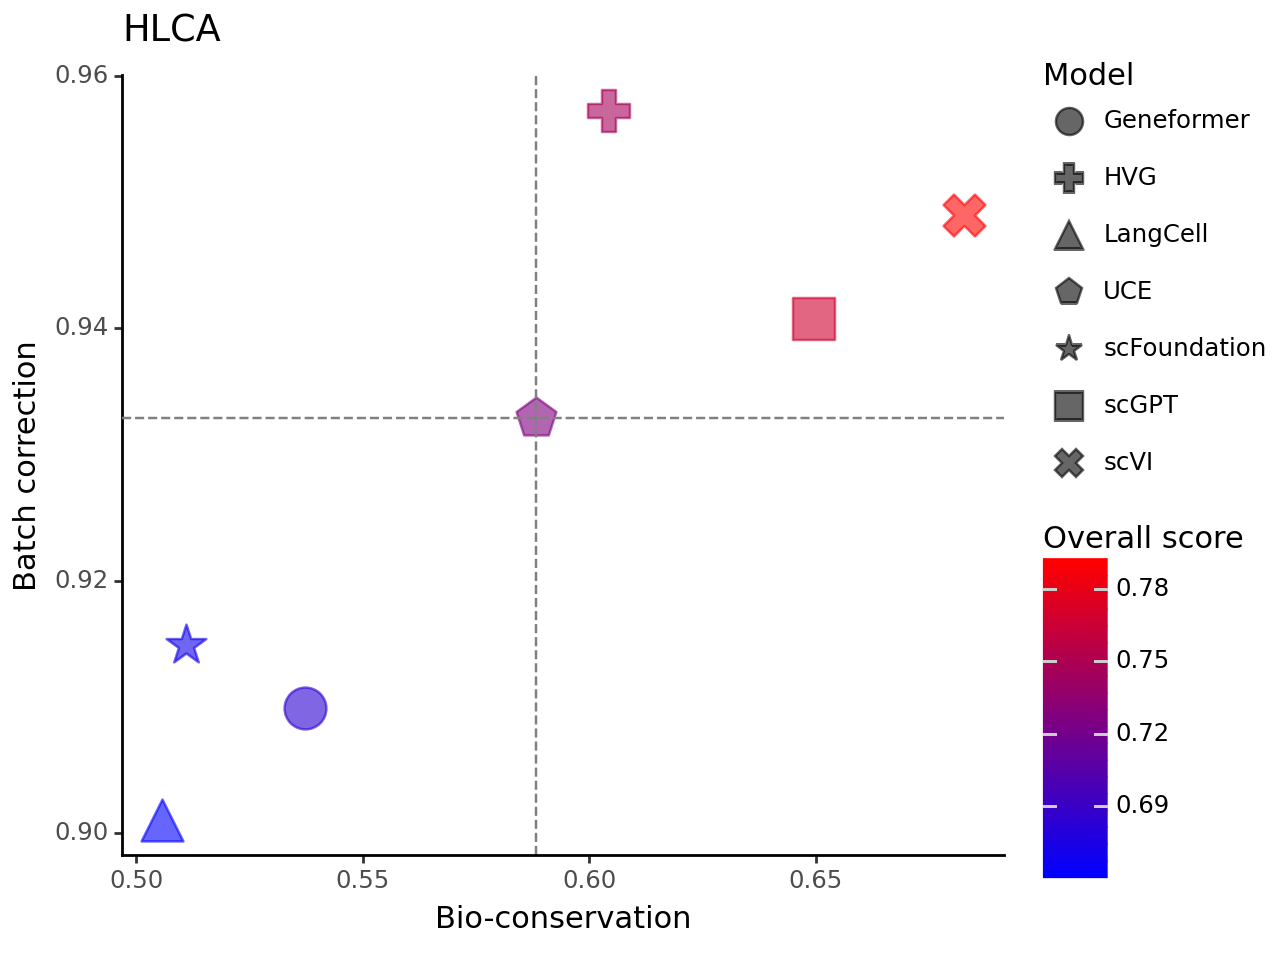

<Figure Size: (640 x 480)>

In [155]:
ggplot(data, aes(x='avg_bio', y='avg_batch', color="overall", shape="model")) \
    + scale_shape_manual(custom_shape) \
    + scale_color_gradient(low="blue", high="red") \
    + geom_point(size=8, alpha=0.6) \
    + guides( 
        size=False,
        shape=guide_legend(title="Model",override_aes={"size":5}), 
        color=guide_colorbar(title="Overall score")
    ) \
    + geom_vline(xintercept=data["avg_bio"].median(), linetype="dashed", color="grey") \
    + geom_hline(yintercept=data["avg_batch"].median(), linetype="dashed", color="grey") \
    + xlab("Bio-conservation") \
    + ylab("Batch correction") \
    + ggtitle("HLCA") \
    + theme_classic()

### scGraph metrics

In [62]:
dataset_name = "HLCA_core"
scgraph = f"../output/scGraph/{dataset_name}.csv"
scgraph_hvg_wo_batchkey = f"../output/scGraph_hvg_wo_batchkey/{dataset_name}.csv"
scgraph_df = pd.DataFrame()
x, y = [], []
model_list = ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
model_list_new = []
for model in model_list:
    # if model == "scVI":
    #     x.append(pd.read_csv(scgraph_hvg_wo_batchkey, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    #     y.append(pd.read_csv(scgraph_hvg_wo_batchkey, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
    # else:
    #     x.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    #     y.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
    x.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    y.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
    model_list_new.append(model_map_dict[f"X_{model.lower()}"])
scgraph_df["model"] = model_list_new
scgraph_df["scGraph-Pearson-PCA"] = x
scgraph_df["scGraph-Pearson-OntoRWR"] = y
scgraph_df["Overall_score"] = (scgraph_df["scGraph-Pearson-PCA"] + scgraph_df["scGraph-Pearson-OntoRWR"]) / 2
# scgraph_df = scgraph_df.sort_values(by="Overall_score").reset_index(drop=True)
scgraph_df

model  scGraph-Pearson-PCA  scGraph-Pearson-OntoRWR  Overall_score
0           HVG               0.8957                   0.7656         0.8306
1          scVI               0.6497                   0.7467         0.6982
2    Geneformer               0.6601                   0.6967         0.6784
3         scGPT               0.7022                   0.7311         0.7167
4           UCE               0.6945                   0.7994         0.7470
5  scFoundation               0.6919                   0.7886         0.7403
6      LangCell               0.6425                   0.7719         0.7072

In [63]:
keys = scgraph_df["model"]
values = scgraph_df.loc[:, ["scGraph-Pearson-PCA", "scGraph-Pearson-OntoRWR"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'HVG': array([0.89565283, 0.76564415]), 'scVI': array([0.6497249 , 0.74668821]), 'Geneformer': array([0.66010008, 0.6966999 ]), 'scGPT': array([0.70218902, 0.73111642]), 'UCE': array([0.69452225, 0.79938658]), 'scFoundation': array([0.69190658, 0.78859846]), 'LangCell': array([0.64254139, 0.77185943])}
Front 1: ['HVG', 'UCE']
Front 2: ['scGPT', 'scFoundation']
Front 3: ['scVI', 'Geneformer', 'LangCell']


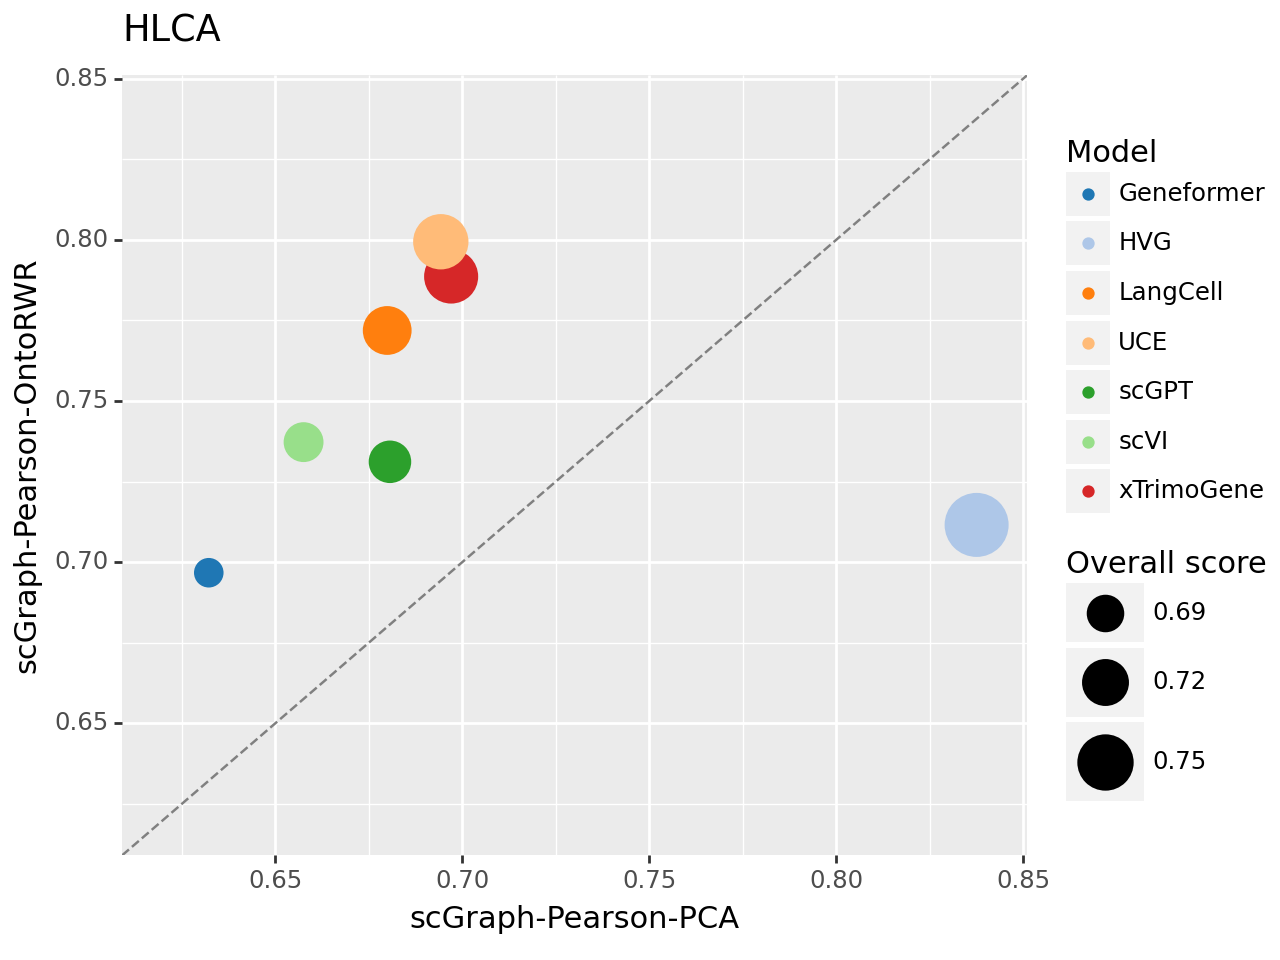

<Figure Size: (640 x 480)>

In [109]:
ggplot(scgraph_df, aes(x="scGraph-Pearson-PCA", y="scGraph-Pearson-OntoRWR", color="model")) \
    + geom_point(aes(size='Overall_score')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12)) \
    + ggtitle("HLCA") \
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") \
    + scale_x_continuous(limits = (0.62, 0.84)) \
    + scale_y_continuous(limits = (0.62, 0.84)) 

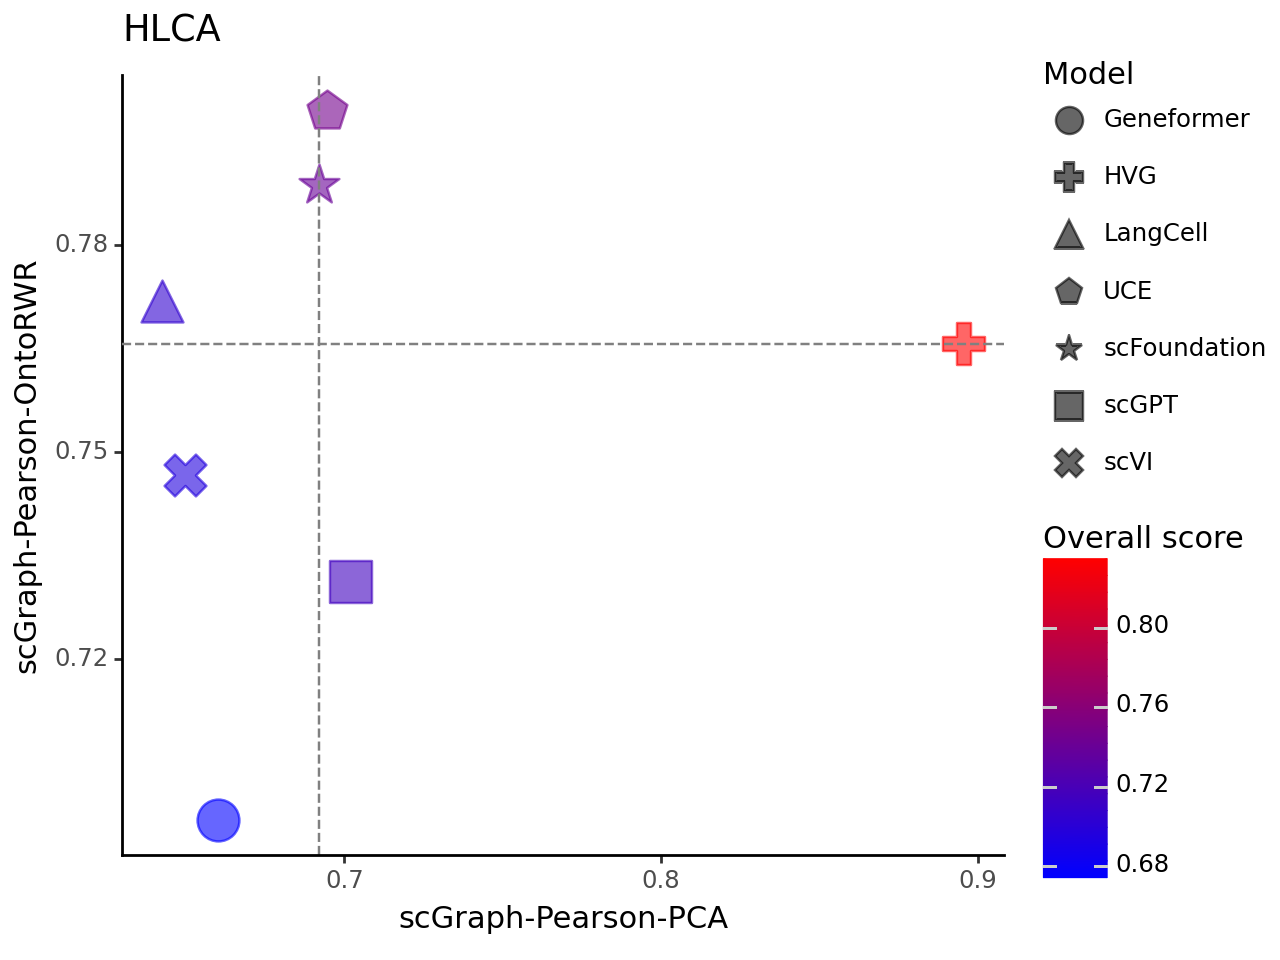

<Figure Size: (640 x 480)>

In [64]:
ggplot(scgraph_df, aes(x="scGraph-Pearson-PCA", y="scGraph-Pearson-OntoRWR", color="Overall_score", shape="model")) \
    + scale_shape_manual(custom_shape) \
    + scale_color_gradient(low="blue", high="red") \
    + geom_point(size=8, alpha=0.6) \
    + guides( 
        size=False,
        shape=guide_legend(title="Model",override_aes={"size":5}), 
        color=guide_colorbar(title="Overall score")
    ) \
    + geom_vline(xintercept=scgraph_df["scGraph-Pearson-PCA"].median(), linetype="dashed", color="grey") \
    + geom_hline(yintercept=scgraph_df["scGraph-Pearson-OntoRWR"].median(), linetype="dashed", color="grey") \
    + ggtitle("HLCA") \
    + theme_classic()

##### detailed analysis

In [82]:
rwr_detailed = pd.read_csv("../output/scGraph/HLCA_core_rwr_detailed.csv", index_col=0)
rwr_detailed_hvg_wo_batchkey = pd.read_csv("../output/scGraph/HLCA_core_rwr_detailed.csv", index_col=0)
# drop unused columns
rwr_detailed = rwr_detailed.drop(["X_scanvi_emb", "X_umap"], axis=1)
# rwr_detailed.loc[:, "X_scvi"] = rwr_detailed_hvg_wo_batchkey.loc[:, "X_scvi"]
# rename other columns
rwr_detailed = rwr_detailed.rename(columns=model_map_dict)
rwr_detailed = pd.melt(rwr_detailed, var_name='Model', value_name='Pearsonr')
rwr_detailed

Model  Pearsonr
0      Geneformer    0.6268
1      Geneformer    0.6060
2      Geneformer    0.5616
3      Geneformer    0.6253
4      Geneformer    0.8236
..            ...       ...
345  scFoundation    0.7347
346  scFoundation    0.7098
347  scFoundation    0.6506
348  scFoundation    0.6837
349  scFoundation    0.7694

[350 rows x 2 columns]

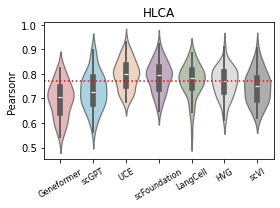

In [83]:
plt.figure(figsize=(4, 3))
sns.violinplot(rwr_detailed, x="Model", y="Pearsonr", hue="Model", 
               palette=custom_palette, alpha=0.8,
               order=model_order)
plt.xticks(fontsize=8, rotation=30)
plt.xlabel("")
plt.ylabel("Pearsonr", fontsize=10)
plt.axhline(y=rwr_detailed[rwr_detailed["Model"]=="HVG"]["Pearsonr"].median(), color="red", linestyle=':')
plt.title("HLCA")
plt.tight_layout()
plt.savefig("../figures/clustering/hlca_spearmanr_violinplot.png", 
            dpi=300, bbox_inches='tight')

## Tabula_Sapiens_all

In [74]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"../output/{dataset_name}"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "scFoundation", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI_cluster/label  0.7433  0.7453      0.6811  0.6949  0.7367        0.7324   
ARI_cluster/label  0.3935  0.4750      0.3772  0.3351  0.4011        0.4139   
ASW_label          0.5006  0.4888      0.4106  0.4905  0.5298        0.5170   
graph_conn         0.8809  0.8390      0.7392  0.8286  0.8635        0.8533   
ASW_label/batch    0.8910  0.7844      0.7831  0.8744  0.7430        0.7977   
avg_bio            0.5458  0.5697      0.4896  0.5068  0.5559        0.5545   
avg_batch          0.8860  0.8117      0.7611  0.8515  0.8032        0.8255   
overall            0.6819  0.6665      0.5982  0.6447  0.6548        0.6629   

                   LangCell  
NMI_cluster/label    0.7325  
ARI_cluster/label    0.4196  
ASW_label            0.5038  
graph_conn           0.8370  
ASW_label/batch      0.8439  
avg_bio              0.5520  
avg_batch            0.8404  
overall              0.6673

In [296]:
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI', 'scFoundation', 'LangCell']
Front 2: ['scGPT', 'UCE']
Front 3: ['Geneformer']


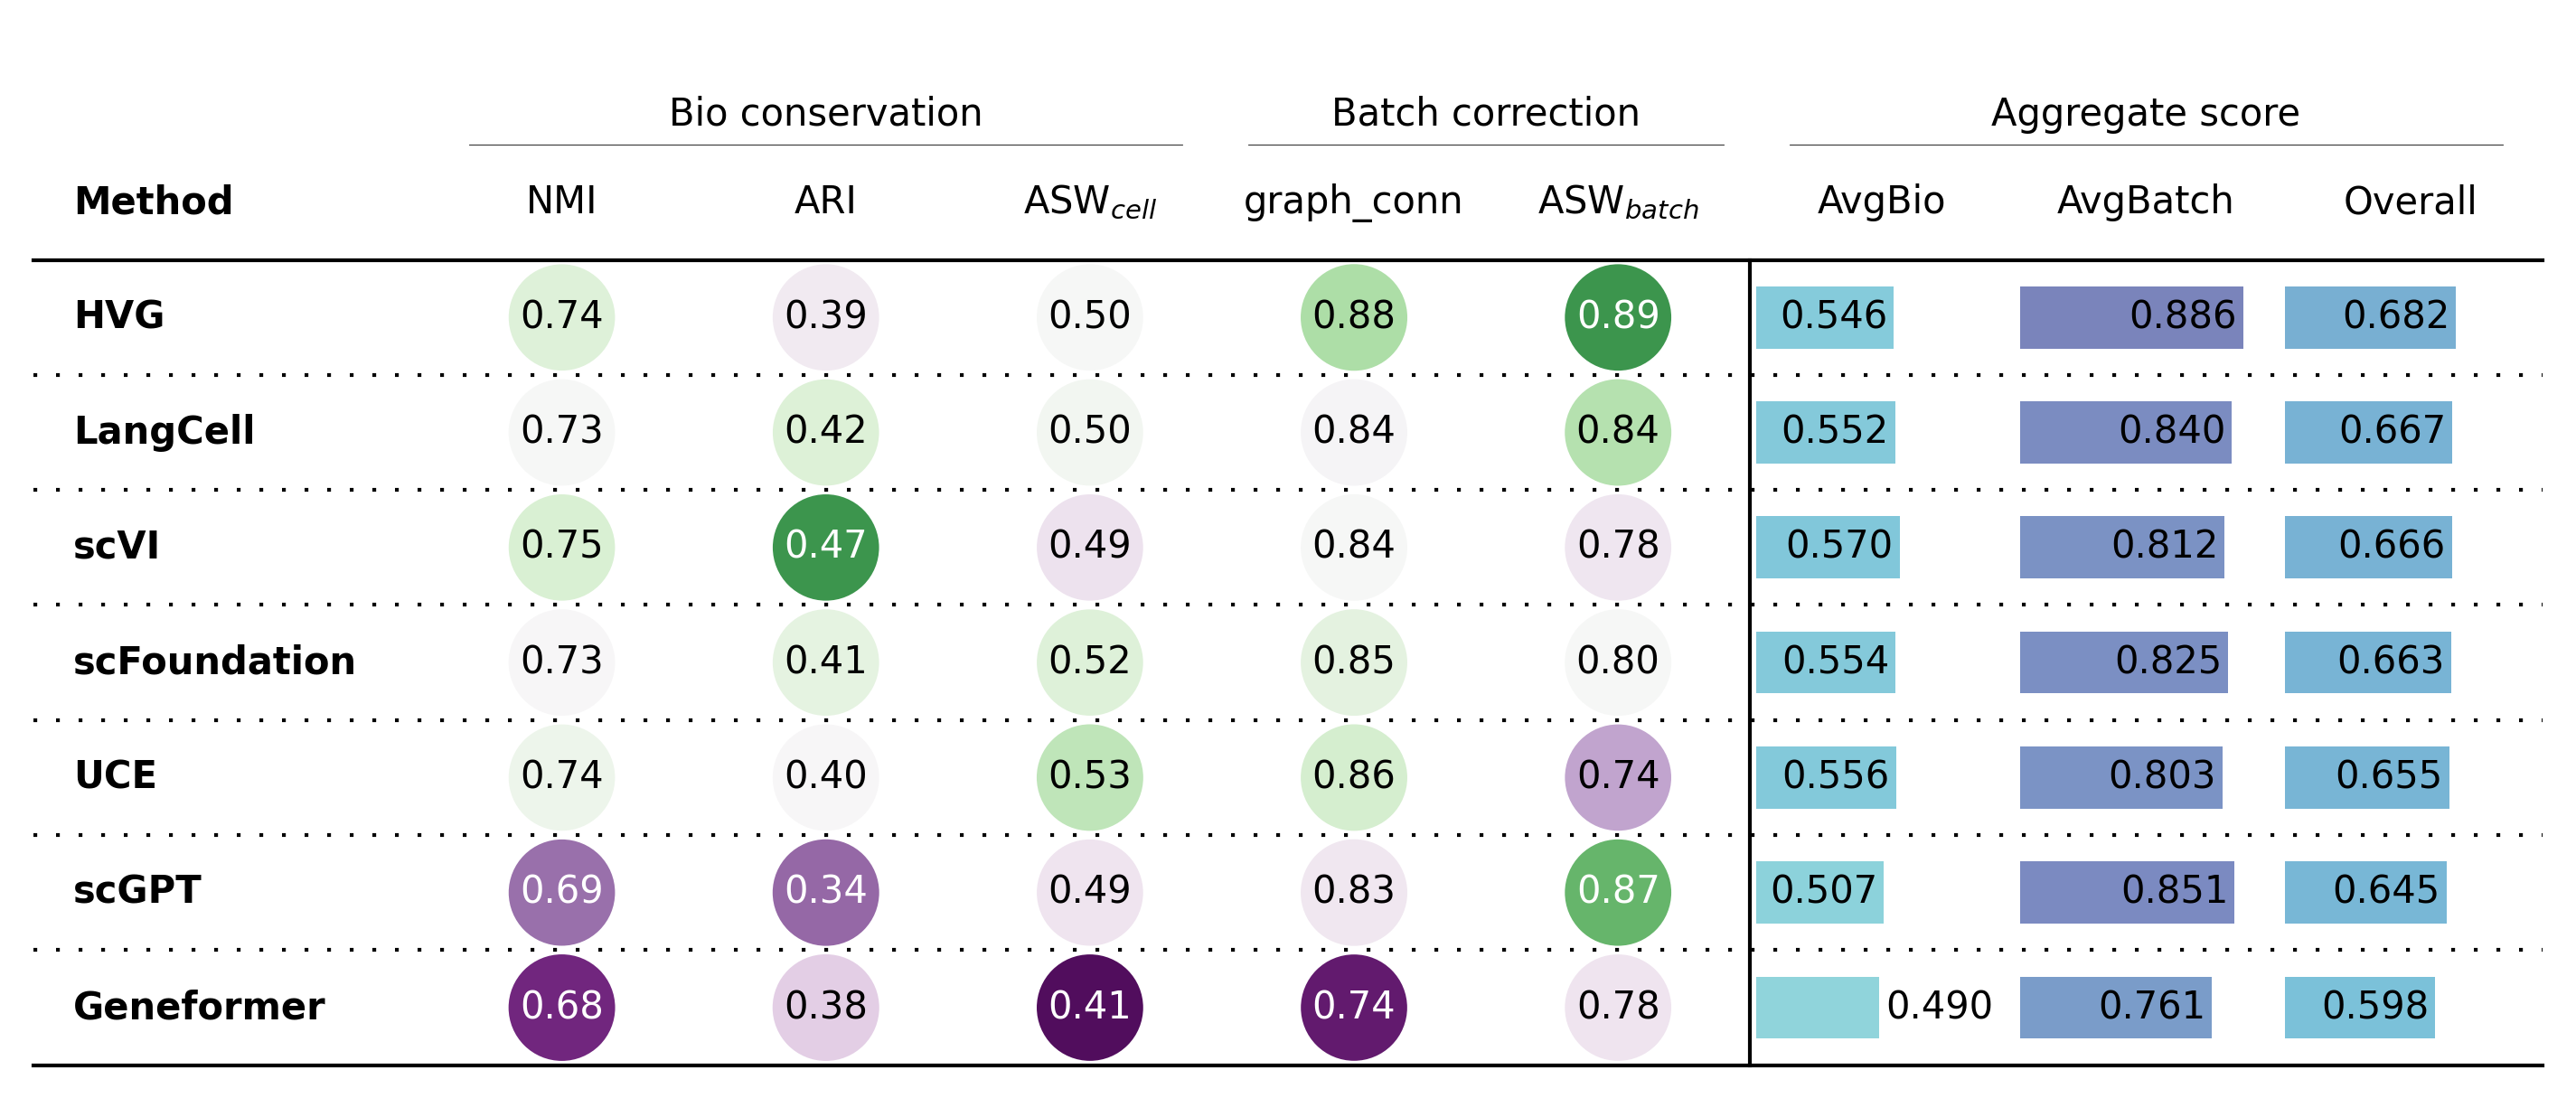

In [75]:
df.rename(index=scib_metrics_dict, inplace=True)
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
plot_results_table(df.T)

In [131]:
data = df.iloc[:, :-1].T
data["model"] = data.index
data

NMI_cluster/label  ARI_cluster/label  ASW_label  graph_conn  \
HVG                      0.7199             0.3965     0.4900      0.8400   
scVI                     0.7453             0.4750     0.4888      0.8390   
Geneformer               0.6811             0.3772     0.4106      0.7392   
scGPT                    0.6949             0.3351     0.4905      0.8286   
UCE                      0.7367             0.4011     0.5298      0.8635   
scFoundation             0.7324             0.4139     0.5170      0.8533   
LangCell                 0.7325             0.4196     0.5038      0.8370   

              ASW_label/batch  avg_bio  avg_batch  overall         model  
HVG                    0.8975   0.5355     0.8687   0.6688           HVG  
scVI                   0.7844   0.5697     0.8117   0.6665          scVI  
Geneformer             0.7831   0.4896     0.7611   0.5982    Geneformer  
scGPT                  0.8744   0.5068     0.8515   0.6447         scGPT  
UCE                    0.7430   0.5559     0.8032   0.6548           UCE  
scFoundation           0.7977   0.5545     0.8255   0.6629  scFoundation  
LangCell               0.8439   0.5520     0.8404   0.6673      LangCell

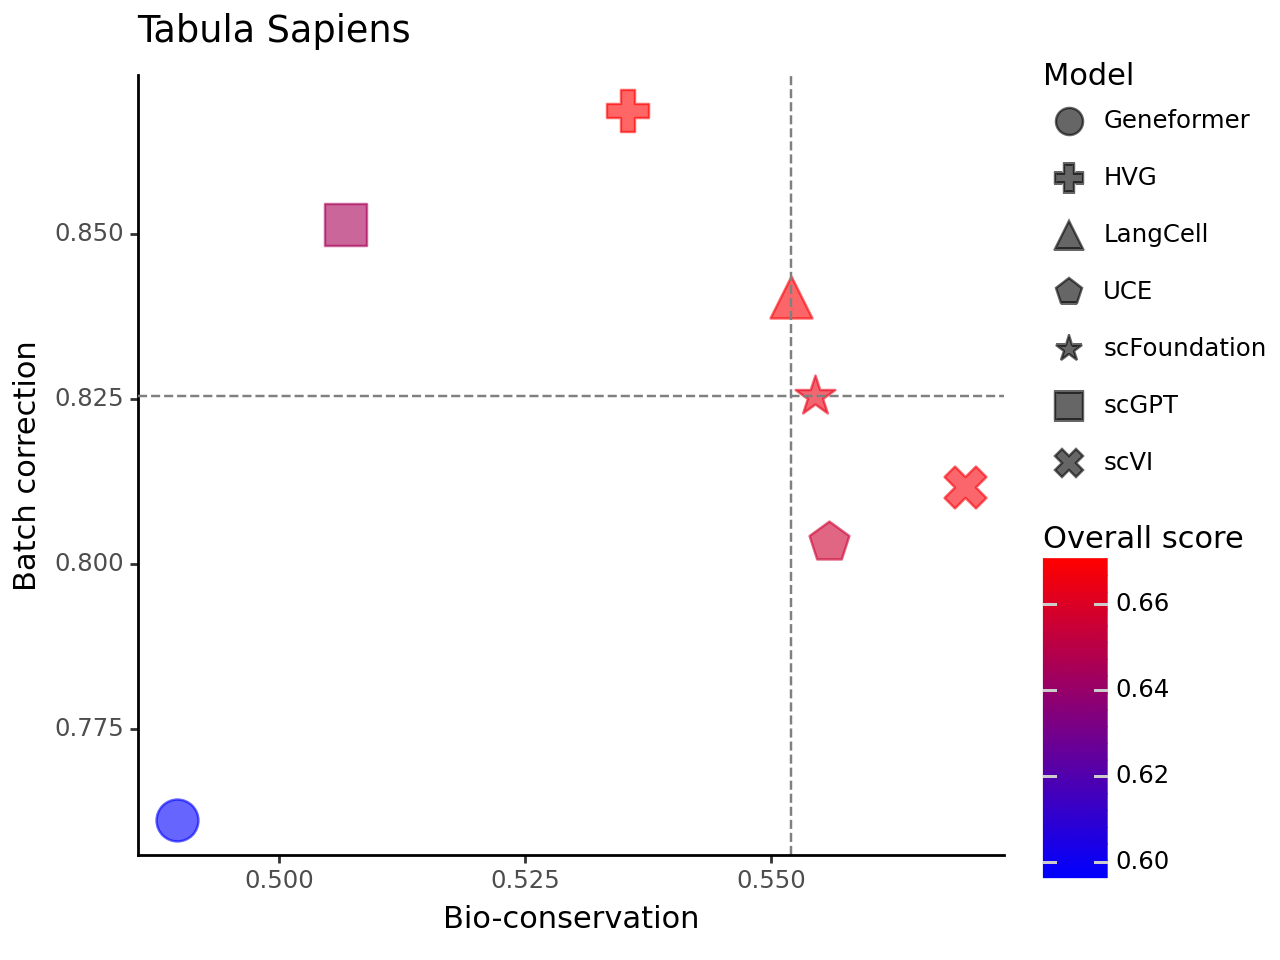

<Figure Size: (640 x 480)>

In [140]:
ggplot(data, aes(x='avg_bio', y='avg_batch', color="overall", shape="model")) \
    + scale_shape_manual(custom_shape) \
    + scale_color_gradient(low="blue", high="red") \
    + geom_point(size=8, alpha=0.6) \
    + guides( 
        size=False,
        shape=guide_legend(title="Model",override_aes={"size":5}), 
        color=guide_colorbar(title="Overall score")
    ) \
    + geom_vline(xintercept=data["avg_bio"].median(), linetype="dashed", color="grey") \
    + geom_hline(yintercept=data["avg_batch"].median(), linetype="dashed", color="grey") \
    + xlab("Bio-conservation") \
    + ylab("Batch correction") \
    + ggtitle("Tabula Sapiens") \
    + theme_classic()

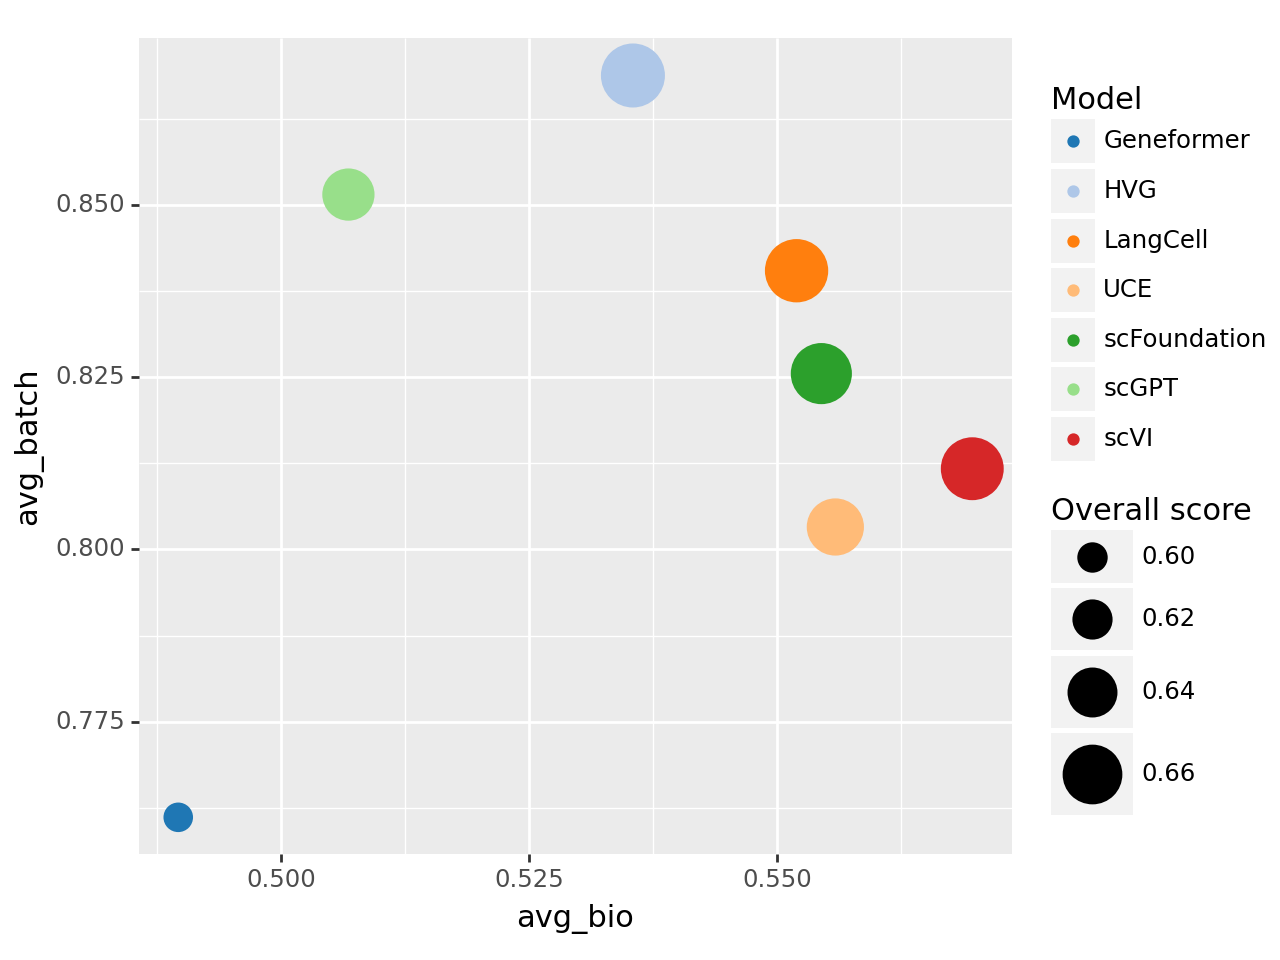

<Figure Size: (640 x 480)>

In [134]:
ggplot(data, aes(x='avg_bio', y='avg_batch', color="model")) \
    + geom_point(aes(size='overall')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12)) \
    # + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") \
    # + scale_x_continuous(limits = (0.56, 0.72)) \
    # + scale_y_continuous(limits = (0.56, 0.72)) 

### scGraph metrics

In [67]:
dataset_name = "Tabula_Sapiens_all"
scgraph = f"../output/scGraph/{dataset_name}.csv"
scgraph_hvg_wo_batchkey = f"../output/scGraph_hvg_wo_batchkey/{dataset_name}.csv"
scgraph_df = pd.DataFrame()
x, y = [], []
model_list = ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
model_list_new = []
for model in model_list:
    # if model == "scVI":
    #     x.append(pd.read_csv(scgraph_hvg_wo_batchkey, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    #     y.append(pd.read_csv(scgraph_hvg_wo_batchkey, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
    # else:
    #     x.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    #     y.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
    x.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    y.append(pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
    model_list_new.append(model_map_dict[f"X_{model.lower()}"])
scgraph_df["model"] = model_list_new
scgraph_df["scGraph-Pearson-PCA"] = x
scgraph_df["scGraph-Pearson-OntoRWR"] = y
scgraph_df["Overall_score"] = (scgraph_df["scGraph-Pearson-PCA"] + scgraph_df["scGraph-Pearson-OntoRWR"]) / 2
# scgraph_df = scgraph_df.sort_values(by="Overall_score").reset_index(drop=True)
scgraph_df

model  scGraph-Pearson-PCA  scGraph-Pearson-OntoRWR  Overall_score
0           HVG               0.7257                   0.5213         0.6235
1          scVI               0.6353                   0.4932         0.5643
2    Geneformer               0.4987                   0.2570         0.3778
3         scGPT               0.6439                   0.4958         0.5699
4           UCE               0.6334                   0.5915         0.6124
5  scFoundation               0.6115                   0.5761         0.5938
6      LangCell               0.6278                   0.5433         0.5856

In [68]:
keys = scgraph_df["model"]
values = scgraph_df.loc[:, ["scGraph-Pearson-PCA", "scGraph-Pearson-OntoRWR"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'HVG': array([0.72568967, 0.5213361 ]), 'scVI': array([0.63531527, 0.49318794]), 'Geneformer': array([0.4986733 , 0.25695737]), 'scGPT': array([0.64393154, 0.49582515]), 'UCE': array([0.63337417, 0.59149406]), 'scFoundation': array([0.61150215, 0.57611242]), 'LangCell': array([0.62784483, 0.54330202])}
Front 1: ['HVG', 'UCE']
Front 2: ['scGPT', 'scFoundation', 'LangCell']
Front 3: ['scVI']
Front 4: ['Geneformer']


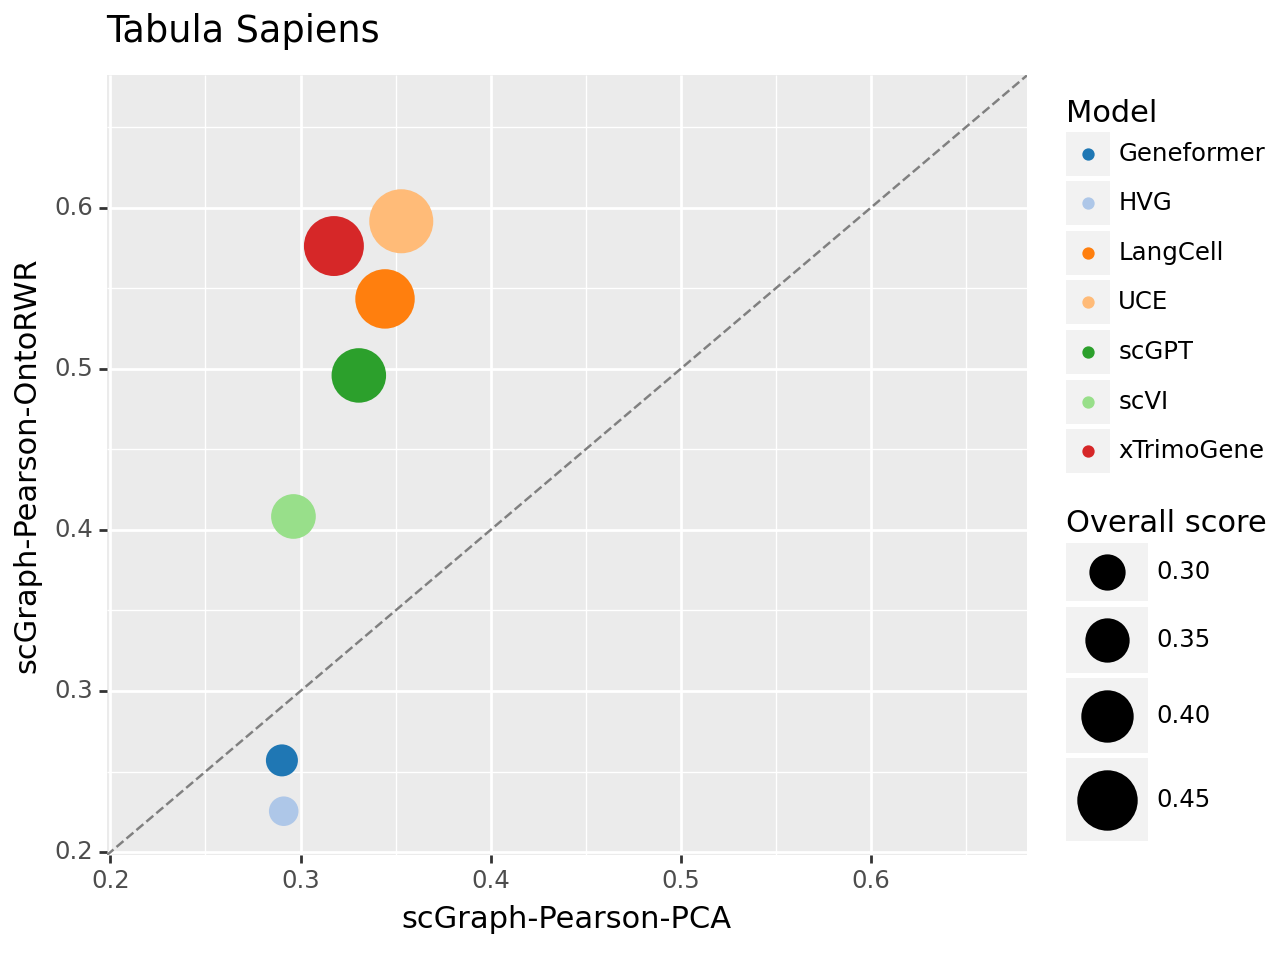

<Figure Size: (640 x 480)>

In [112]:
ggplot(scgraph_df, aes(x="scGraph-Pearson-PCA", y="scGraph-Pearson-OntoRWR", color="model")) \
    + geom_point(aes(size='Overall_score')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12)) \
    + ggtitle("Tabula Sapiens") \
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") \
    + scale_x_continuous(limits = (0.22, 0.66)) \
    + scale_y_continuous(limits = (0.22, 0.66)) 

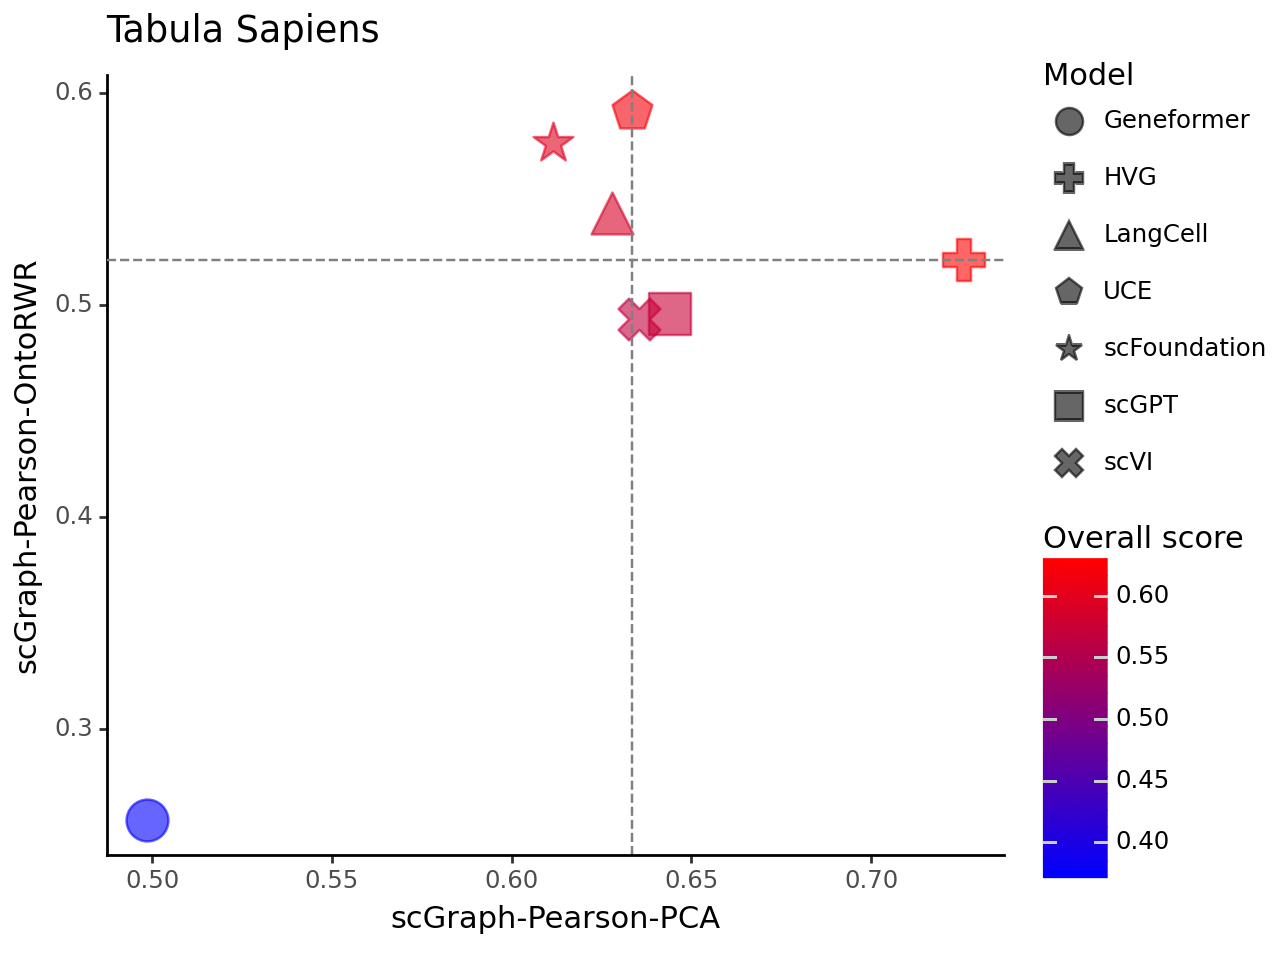

<Figure Size: (640 x 480)>

In [69]:
ggplot(scgraph_df, aes(x="scGraph-Pearson-PCA", y="scGraph-Pearson-OntoRWR", color="Overall_score", shape="model")) \
    + scale_shape_manual(custom_shape) \
    + scale_color_gradient(low="blue", high="red") \
    + geom_point(size=8, alpha=0.6) \
    + guides( 
        size=False,
        shape=guide_legend(title="Model",override_aes={"size":5}), 
        color=guide_colorbar(title="Overall score")
    ) \
    + geom_vline(xintercept=scgraph_df["scGraph-Pearson-PCA"].median(), linetype="dashed", color="grey") \
    + geom_hline(yintercept=scgraph_df["scGraph-Pearson-OntoRWR"].median(), linetype="dashed", color="grey") \
    + ggtitle("Tabula Sapiens") \
    + theme_classic()

#### detailed analysis

In [84]:
rwr_detailed = pd.read_csv("../output/scGraph/Tabula_Sapiens_all_rwr_detailed.csv", index_col=0)
rwr_detailed_hvg_wo_batchkey = pd.read_csv("../output/scGraph/Tabula_Sapiens_all_rwr_detailed.csv", index_col=0)
# drop unused columns
rwr_detailed = rwr_detailed.drop(["X_umap",'X_pca','X_scvi_umap'], axis=1)
# rwr_detailed.loc[:, "X_scvi"] = rwr_detailed_hvg_wo_batchkey.loc[:, "X_scvi"]
# rename other columns
rwr_detailed = rwr_detailed.rename(columns=model_map_dict)
rwr_detailed = pd.melt(rwr_detailed, var_name='Model', value_name='Pearsonr')
rwr_detailed

Model  Pearsonr
0       Geneformer    0.1533
1       Geneformer    0.1899
2       Geneformer    0.1973
3       Geneformer    0.1530
4       Geneformer    0.3127
...            ...       ...
1080  scFoundation    0.7238
1081  scFoundation    0.5844
1082  scFoundation    0.6038
1083  scFoundation    0.6860
1084  scFoundation    0.5041

[1085 rows x 2 columns]

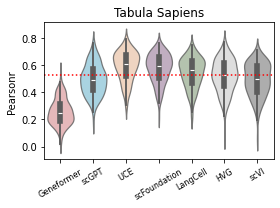

In [85]:
plt.figure(figsize=(4, 3))
sns.violinplot(rwr_detailed, x="Model", y="Pearsonr", hue="Model", 
               palette=custom_palette, alpha=0.8,
               order=model_order)
plt.xticks(fontsize=8, rotation=30)
plt.xlabel("")
plt.ylabel("Pearsonr", fontsize=10)
plt.axhline(y=rwr_detailed[rwr_detailed["Model"]=="HVG"]["Pearsonr"].median(), color="red", linestyle=':')
plt.title("Tabula Sapiens")
plt.tight_layout()
plt.savefig("../figures/clustering/tabula_spearmanr_violinplot.png", 
            dpi=300, bbox_inches='tight')

## Embedding distance analysis

#### Case study of the proposed metric

In [34]:
def get_ontology_name(obo_file, lower=True):
	fin = open(obo_file)
	co2name = {}
	name2co = {}
	tag_is_syn = {}
	for line in fin:
		if line.startswith('id: '):
			co = line.strip().split('id: ')[1]
		if line.startswith('name: '):
			if lower:
				name = line.strip().lower().split('name: ')[1]
			else:
				name = line.strip().split('name: ')[1]
			co2name[co] = name
			name2co[name] = co
		if line.startswith('synonym: '):
			if lower:
				syn = line.strip().lower().split('synonym: "')[1].split('" ')[0]
			else:
				syn = line.strip().split('synonym: "')[1].split('" ')[0]
			if syn in name2co:
				continue
			name2co[syn] = co
	fin.close()
	return co2name, name2co

In [35]:
co2name, name2co = get_ontology_name("../data/OnClass_data_public/Ontology_data/cl.obo")
co2name

{'CL:0000000': 'cell',
 'CL:0000001': 'primary cultured cell',
 'CL:0000002': 'obsolete immortal cell line cell',
 'CL:0000003': 'obsolete native cell',
 'CL:0000004': 'obsolete cell by organism',
 'CL:0000005': 'neural crest derived fibroblast',
 'CL:0000006': 'neuronal receptor cell',
 'CL:0000007': 'early embryonic cell (metazoa)',
 'CL:0000008': 'migratory cranial neural crest cell',
 'CL:0000009': 'obsolete fusiform initial',
 'CL:0000010': 'cultured cell',
 'CL:0000011': 'migratory trunk neural crest cell',
 'CL:0000012': 'obsolete cell by class',
 'CL:0000013': 'obsolete dentine secreting cell',
 'CL:0000014': 'germ line stem cell',
 'CL:0000015': 'male germ cell',
 'CL:0000016': 'male germ line stem cell',
 'CL:0000017': 'spermatocyte',
 'CL:0000018': 'spermatid',
 'CL:0000019': 'sperm',
 'CL:0000020': 'spermatogonium',
 'CL:0000021': 'female germ cell',
 'CL:0000022': 'female germ line stem cell',
 'CL:0000023': 'oocyte',
 'CL:0000024': 'oogonial cell',
 'CL:0000025': 'egg cel

In [36]:
# create ontology graph
onto_sp = pd.read_csv("../data/OnClass_data_public/Ontology_data/cl.ontology.sp.csv", index_col=0)
onto_nlp = pd.read_csv("../data/OnClass_data_public/Ontology_data/cl.ontology.nlp.csv", index_col=0)
onto_rwr = pd.read_csv("../data/OnClass_data_public/Ontology_data/cl.ontology.rwr.csv", index_col=0)
onto_nlp

CL:0000000  CL:0000001  CL:0000005  CL:0000006  CL:0000007  \
CL:0000000    0.000000    0.672232    1.041984    1.256473    1.071841   
CL:0000001    0.672232    0.000000    0.913770    1.103122    0.989414   
CL:0000005    1.041984    0.913770    0.000000    1.074516    1.315732   
CL:0000006    1.256473    1.103122    1.074516    0.000000    1.177925   
CL:0000007    1.071841    0.989414    1.315732    1.177925    0.000000   
...                ...         ...         ...         ...         ...   
CL:4042007    1.217550    1.180351    1.133911    1.117037    1.302860   
CL:4042008    1.206490    1.165423    1.176370    1.145368    1.212929   
CL:4042009    1.183404    1.197557    1.166826    1.202255    1.281575   
CL:4042010    1.149285    1.148786    1.115774    1.076025    1.283402   
CL:4042011    1.157841    1.180082    1.139462    1.118687    1.297147   

            CL:0000008  CL:0000010  CL:0000011  CL:0000014  CL:0000015  ...  \
CL:0000000    1.139974    0.911691    1.193805    1.164662    1.184962  ...   
CL:0000001    0.967440    0.475365    0.958533    1.037907    1.117927  ...   
CL:0000005    0.830141    1.032640    0.826486    1.227876    1.294531  ...   
CL:0000006    0.836709    1.114970    0.959024    1.065092    1.214365  ...   
CL:0000007    1.140832    0.978524    1.122769    1.110488    0.956397  ...   
...                ...         ...         ...         ...         ...  ...   
CL:4042007    1.061198    1.274433    1.097722    1.283574    1.297264  ...   
CL:4042008    0.990784    1.266793    1.074108    1.217526    1.261928  ...   
CL:4042009    1.066361    1.292603    1.116678    1.282309    1.297275  ...   
CL:4042010    0.958520    1.245792    1.054815    1.196449    1.324542  ...   
CL:4042011    0.950785    1.272522    1.060971    1.199360    1.334960  ...   

            CL:4042002  CL:4042003  CL:4042004  CL:4042005  CL:4042006  \
CL:0000000    1.331425    1.036765    1.046754    1.030395    0.843450   
CL:0000001    1.187999    0.960066    0.988999    0.964015    0.853606   
CL:0000005    1.155228    0.876500    0.985932    0.885159    1.042170   
CL:0000006    0.782866    1.075460    1.119810    1.124066    1.219153   
CL:0000007    1.207877    1.213567    1.233261    1.240722    1.240959   
...                ...         ...         ...         ...         ...   
CL:4042007    1.132991    1.158146    1.262508    1.211515    1.239539   
CL:4042008    1.158793    1.064450    1.177082    1.113149    1.226485   
CL:4042009    1.233138    1.148845    1.260349    1.191595    1.255516   
CL:4042010    1.193491    0.991243    1.129390    1.033005    1.203898   
CL:4042011    1.194104    0.998761    1.143810    1.040012    1.202195   

            CL:4042007  CL:4042008  CL:4042009  CL:4042010  CL:4042011  
CL:0000000    1.217550    1.206490    1.183404    1.149285    1.157841  
CL:0000001    1.180351    1.165423    1.197557    1.148786    1.180082  
CL:0000005    1.133911    1.176370    1.166826    1.115774    1.139462  
CL:0000006    1.117037    1.145368    1.202255    1.076025    1.118687  
CL:0000007    1.302860    1.212929    1.281575    1.283402    1.297147  
...                ...         ...         ...         ...         ...  
CL:4042007    0.000000    0.456455    0.306484    0.566029    0.619029  
CL:4042008    0.456455    0.000000    0.380536    0.529810    0.560025  
CL:4042009    0.306484    0.380536    0.000000    0.444268    0.491837  
CL:4042010    0.566029    0.529810    0.444268    0.000000    0.207506  
CL:4042011    0.619029    0.560025    0.491837    0.207506    0.000000  

[2743 rows x 2743 columns]

In [37]:
reference_graph_pca = pd.read_csv("../scGraph/reference_graph/Tabula_Sapiens_all/concensus_df_pca.csv", index_col=0)
reference_graph_pca = reference_graph_pca.sort_index(axis=1)
reference_graph_pca

CL:0000019  CL:0000034  CL:0000037  CL:0000038  CL:0000049  \
CL:0000019    0.000000         NaN         NaN    0.457265         NaN   
CL:0000034         NaN         0.0         NaN         NaN         NaN   
CL:0000037         NaN         NaN    0.000000    0.327703    0.123565   
CL:0000038    0.508669         NaN    0.295469    0.000000    0.257946   
CL:0000049         NaN         NaN    0.122267    0.279632    0.000000   
...                ...         ...         ...         ...         ...   
CL:1001516         NaN         NaN         NaN         NaN         NaN   
CL:1001589         NaN         NaN         NaN         NaN         NaN   
CL:2000016         NaN         NaN         NaN         NaN         NaN   
CL:2000055         NaN         NaN         NaN         NaN         NaN   
CL:4006000         NaN         NaN         NaN         NaN         NaN   

            CL:0000057  CL:0000064  CL:0000066  CL:0000067  CL:0000068  ...  \
CL:0000019    0.684123         NaN    0.142420         NaN         NaN  ...   
CL:0000034    0.504228         NaN         NaN         NaN         NaN  ...   
CL:0000037         NaN         NaN         NaN         NaN         NaN  ...   
CL:0000038    0.758313         NaN    0.555784         NaN         NaN  ...   
CL:0000049         NaN         NaN         NaN         NaN         NaN  ...   
...                ...         ...         ...         ...         ...  ...   
CL:1001516    0.696243         NaN         NaN         NaN         NaN  ...   
CL:1001589    1.000000         NaN         NaN         NaN         NaN  ...   
CL:2000016    0.786044         NaN         NaN         NaN         NaN  ...   
CL:2000055    0.635550         NaN         NaN         NaN         NaN  ...   
CL:4006000         NaN         NaN         NaN         NaN         NaN  ...   

            CL:1000413  CL:1000432  CL:1000436  CL:1000495  CL:1001428  \
CL:0000019         NaN         NaN         NaN         NaN         NaN   
CL:0000034         NaN    0.140778    0.529626         NaN         NaN   
CL:0000037         NaN         NaN         NaN         NaN         NaN   
CL:0000038         NaN         NaN         NaN         NaN         NaN   
CL:0000049         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
CL:1001516         NaN         NaN         NaN    0.681719         NaN   
CL:1001589         NaN         NaN         NaN    0.983297         NaN   
CL:2000016    0.352374         NaN         NaN         NaN         NaN   
CL:2000055         NaN         NaN         NaN         NaN         NaN   
CL:4006000    0.916325         NaN         NaN         NaN         NaN   

            CL:1001516  CL:1001589  CL:2000016  CL:2000055  CL:4006000  
CL:0000019         NaN         NaN         NaN         NaN         NaN  
CL:0000034         NaN         NaN         NaN         NaN         NaN  
CL:0000037         NaN         NaN         NaN         NaN         NaN  
CL:0000038         NaN         NaN         NaN         NaN         NaN  
CL:0000049         NaN         NaN         NaN         NaN         NaN  
...                ...         ...         ...         ...         ...  
CL:1001516      0.0000    0.616942         NaN         NaN         NaN  
CL:1001589      0.9757    0.000000         NaN         NaN         NaN  
CL:2000016         NaN         NaN         0.0         NaN         NaN  
CL:2000055         NaN         NaN         NaN         0.0         NaN  
CL:4006000         NaN         NaN         NaN         NaN         0.0  

[155 rows x 155 columns]

In [38]:
name2co["plasma cell"]

'CL:0000786'

In [41]:
remain_celltypes = np.load("../OnClass/result/Tabula_Sapiens_all_remained_celltypes.npy")
target_celltype = 'CL:0000786'
co2distance = {x: onto_sp.loc[target_celltype, x] for x in remain_celltypes}
co2distance

{'CL:0000019': 8.0,
 'CL:0000037': 8.0,
 'CL:0000038': 8.0,
 'CL:0000049': 9.0,
 'CL:0000077': 10.0,
 'CL:0000097': 7.0,
 'CL:0000114': 10.0,
 'CL:0000129': 8.0,
 'CL:0000131': 10.0,
 'CL:0000134': 8.0,
 'CL:0000136': 9.0,
 'CL:0000148': 9.0,
 'CL:0000158': 8.0,
 'CL:0000169': 11.0,
 'CL:0000171': 11.0,
 'CL:0000173': 11.0,
 'CL:0000182': 9.0,
 'CL:0000185': 9.0,
 'CL:0000186': 9.0,
 'CL:0000189': 11.0,
 'CL:0000190': 11.0,
 'CL:0000232': 8.0,
 'CL:0000233': 8.0,
 'CL:0000287': 11.0,
 'CL:0000312': 9.0,
 'CL:0000359': 9.0,
 'CL:0000388': 10.0,
 'CL:0000453': 7.0,
 'CL:0000575': 10.0,
 'CL:0000636': 10.0,
 'CL:0000646': 9.0,
 'CL:0000669': 9.0,
 'CL:0000740': 10.0,
 'CL:0000745': 10.0,
 'CL:0000746': 9.0,
 'CL:0000748': 9.0,
 'CL:0000767': 8.0,
 'CL:0000775': 8.0,
 'CL:0000786': 0.0,
 'CL:0000787': 4.0,
 'CL:0000788': 4.0,
 'CL:0000794': 8.0,
 'CL:0000807': 8.0,
 'CL:0000808': 8.0,
 'CL:0000809': 7.0,
 'CL:0000823': 6.0,
 'CL:0000841': 7.0,
 'CL:0000860': 7.0,
 'CL:0000875': 7.0,
 'CL:0

In [42]:
co2distance_df = pd.DataFrame()
co2distance_df["Cell ontology id"] = co2distance.keys()
co2distance_df["Cell name"] = co2distance_df["Cell ontology id"].apply(lambda x: co2name[x])
co2distance_df["DAG distance"] = co2distance.values()
co2distance_df

Cell ontology id                            Cell name  DAG distance
0         CL:0000019                                sperm           8.0
1         CL:0000037              hematopoietic stem cell           8.0
2         CL:0000038            erythroid progenitor cell           8.0
3         CL:0000049            common myeloid progenitor           9.0
4         CL:0000077                     mesothelial cell          10.0
..               ...                                  ...           ...
115       CL:1001516      intestinal enteroendocrine cell          11.0
116       CL:1001589              duodenum glandular cell          11.0
117       CL:2000016  lung microvascular endothelial cell          11.0
118       CL:2000055                 liver dendritic cell           6.0
119       CL:4006000                 fibroblast of breast          10.0

[120 rows x 3 columns]

In [43]:
co2distance_df["DAG distance"].value_counts()

DAG distance
11.0    27
10.0    25
9.0     22
8.0     18
7.0     15
12.0     6
4.0      2
6.0      2
0.0      1
2.0      1
13.0     1
Name: count, dtype: int64

In [44]:
selected_cells = co2distance_df[co2distance_df["DAG distance"]<=6].sort_values("DAG distance").reset_index(drop=True)
selected_cells

Cell ontology id                     Cell name  DAG distance
0       CL:0000786                   plasma cell           0.0
1       CL:0000980                   plasmablast           2.0
2       CL:0000787                 memory b cell           4.0
3       CL:0000788                  naive b cell           4.0
4       CL:0000823  immature natural killer cell           6.0
5       CL:2000055          liver dendritic cell           6.0

In [45]:
selected_cells["Cell name"].tolist()

['plasma cell',
 'plasmablast',
 'memory b cell',
 'naive b cell',
 'immature natural killer cell',
 'liver dendritic cell']

In [46]:
selected_cells["PCA distance"] = reference_graph_pca.loc[target_celltype, selected_cells["Cell ontology id"]].values
selected_cells

Cell ontology id                     Cell name  DAG distance  PCA distance
0       CL:0000786                   plasma cell           0.0      0.000000
1       CL:0000980                   plasmablast           2.0      0.364187
2       CL:0000787                 memory b cell           4.0      0.464566
3       CL:0000788                  naive b cell           4.0      0.504570
4       CL:0000823  immature natural killer cell           6.0      0.792220
5       CL:2000055          liver dendritic cell           6.0      0.143257

In [47]:
selected_cells["OntoRWR distance"] = onto_rwr.loc[target_celltype, selected_cells["Cell ontology id"]].values
selected_cells

Cell ontology id                     Cell name  DAG distance  PCA distance  \
0       CL:0000786                   plasma cell           0.0      0.000000   
1       CL:0000980                   plasmablast           2.0      0.364187   
2       CL:0000787                 memory b cell           4.0      0.464566   
3       CL:0000788                  naive b cell           4.0      0.504570   
4       CL:0000823  immature natural killer cell           6.0      0.792220   
5       CL:2000055          liver dendritic cell           6.0      0.143257   

   OntoRWR distance  
0          0.000000  
1          3.022473  
2          5.066945  
3          4.768262  
4          5.111935  
5          5.153073

In [48]:
# selected_cells.to_csv("../figures/clustering/metric_case_study.csv", index=False)

#### Visualization of pairwise distance distribution

In [ ]:
# load dataset and embeddings
adata = sc.read("../data/datasets/Tabula_Sapiens_all.h5ad")
embed_dir = "../output/Tabula_Sapiens_all"
for model in ["scVI", "Geneformer", "LangCell", "scGPT", "UCE", "xTrimoGene"]:
    if model == "xTrimoGene":
        adata.obsm["scFoundation"] = np.load(os.path.join(embed_dir, model, "mapping_01B-resolution_singlecell_cell_embedding_t4.5_resolution.npy"))
    else:
        adata.obsm[model] = np.load(os.path.join(embed_dir, model, "cell_emb.npy"))

In [49]:
# randomly select 1000 cells
selected_cells = np.random.choice(len(adata), 1000, replace=False)
adata_selected = adata[selected_cells]
selected_celltypes = adata_selected.obs["cell_type_ontology_term_id"]
onto_sp_distance = onto_sp.loc[selected_celltypes, selected_celltypes].values
result_df = pd.DataFrame()
indices = np.tril_indices(1000, k=-1)
result_df["DAG distance"] = onto_sp_distance[indices].reshape(-1).astype("int")

# calculate pairwise distance
for model in ["scVI", "Geneformer", "LangCell", "scGPT", "UCE", "scFoundation"]:
    cell_emb = adata_selected.obsm[model]
    emb_distance = cdist(cell_emb, cell_emb, "euclidean")
    result_df[model] = emb_distance[indices].reshape(-1)

In [114]:
result_df.head()

DAG distance      scVI  Geneformer  LangCell     scGPT       UCE  \
0            11  8.219437    0.473874  1.049979  0.573772  1.156215   
1             4  6.257554    0.517107  1.028873  0.420411  1.078763   
2            10  8.046035    0.595250  0.943501  0.455085  1.084307   
3             3  6.646749    0.439258  0.986526  0.506966  1.063281   
4            10  7.090455    0.423623  1.159194  0.427729  1.166949   

   scFoundation  
0     63.471927  
1     52.298434  
2     55.665005  
3     51.868389  
4     58.916502

In [73]:
result_df.to_csv("../figures/clustering/emb_distance_plot_data.csv", index=False)

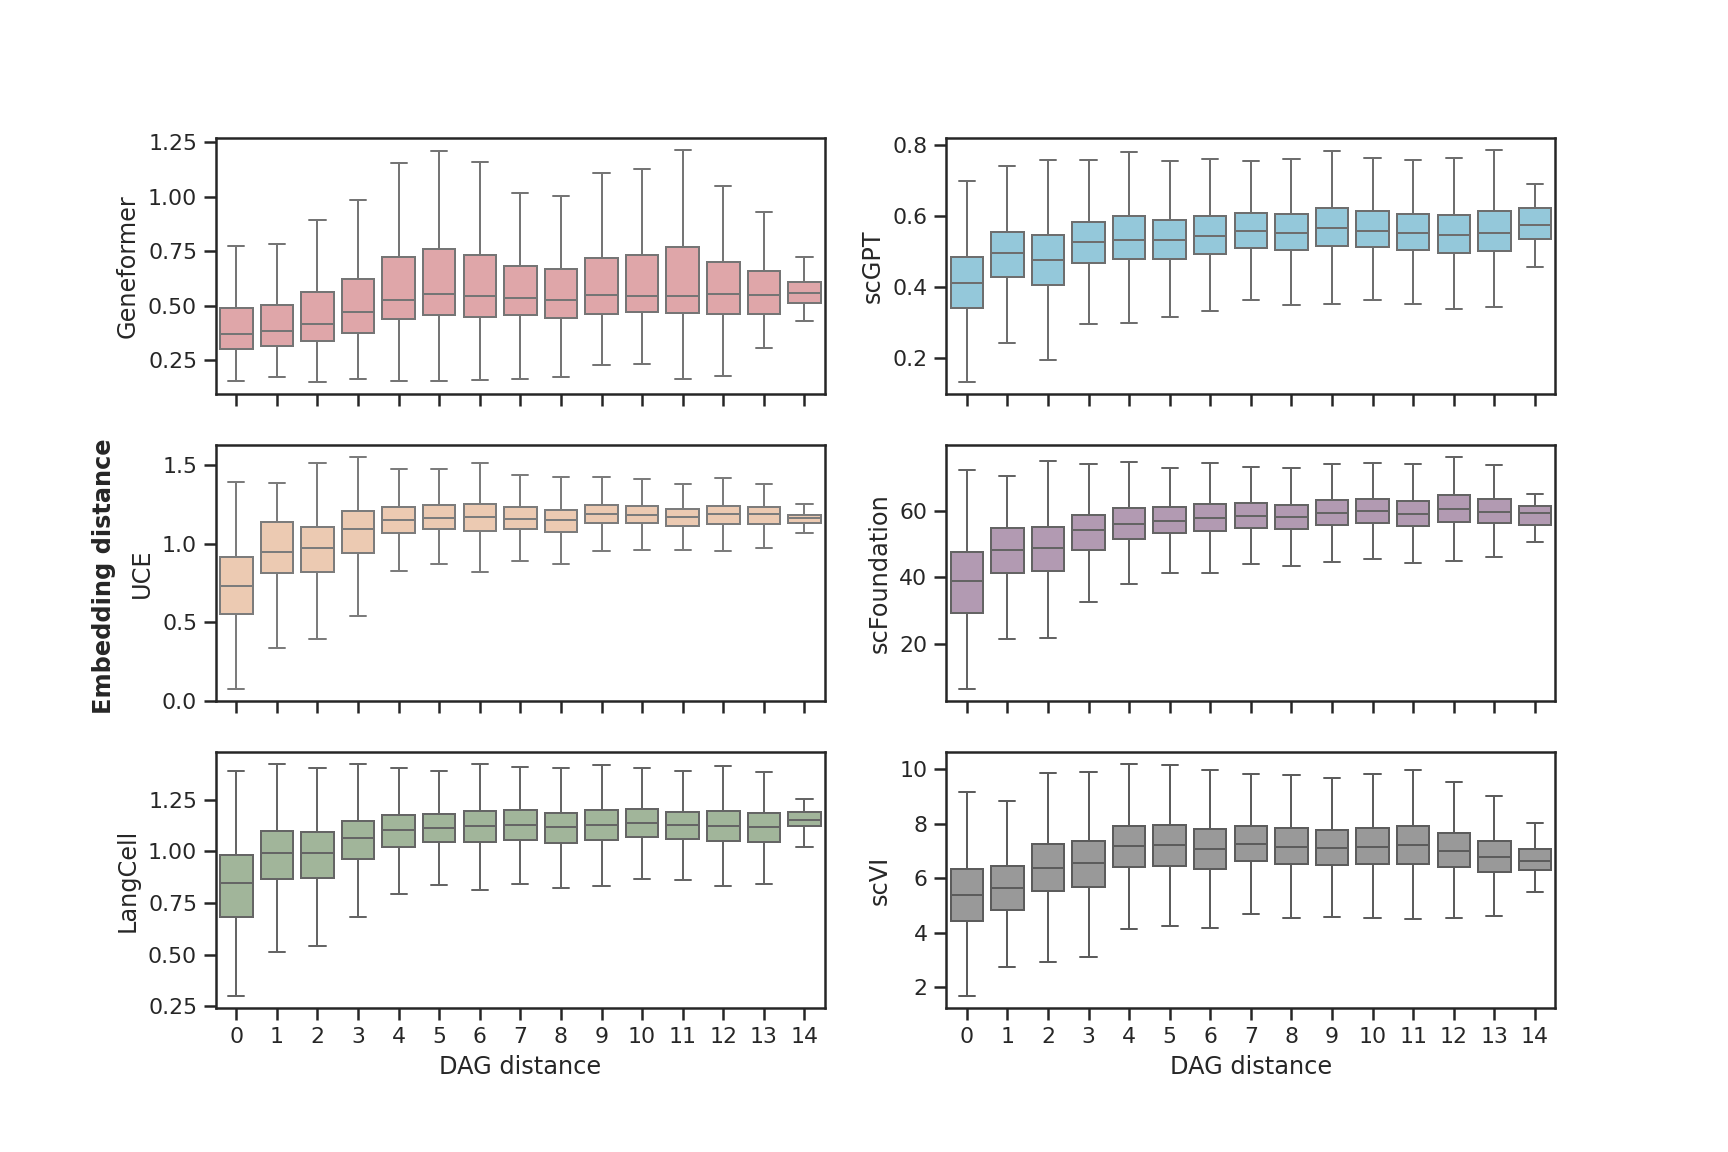

In [116]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=False)
pal = sns.color_palette("tab20", 20)
for i, model in enumerate(model_order_wo_hvg):
    if model != "HVG":
        sns.boxplot(result_df, y=model, x="DAG distance", showfliers=False, ax=axes[i//2,i%2], 
                    color=custom_palette[model]
                    )
fig.text(0.06, 0.5, 'Embedding distance', ha='center', va='center', rotation='vertical', fontsize=12, fontweight="bold")
plt.savefig("../figures/clustering/emb_distance_distribution.png", dpi=300)

## Overall ranking

#### scIB

In [37]:
pd.set_option('display.precision', 4) 
df_all = pd.DataFrame()
for dataset in ["pancreas_scib", "Immune_all_human", "HLCA_core", "Tabula_Sapiens_all"]:
    output_folder = f"../output/{dataset}"
    df = pd.DataFrame()
    for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
        result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
        df_ = pd.read_csv(result_path, index_col=0)
        df_.rename(columns=model_map_dict, inplace=True)
        df = pd.concat([df, df_], axis=1)
    # df["Dataset"] = dataset_map_dict[dataset]
    df_all = pd.concat([df_all, df])
df_all

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
NMI_cluster/label  0.8245  0.9055      0.3706  0.6229  0.5934        0.5631   
ARI_cluster/label  0.7655  0.9383      0.1510  0.4046  0.4068        0.3705   
ASW_label          0.5660  0.5684      0.3742  0.5307  0.5482        0.5260   
graph_conn         0.9634  0.9918      0.6935  0.9161  0.9136        0.8761   
ASW_label/batch    0.9396  0.8708      0.5306  0.8494  0.8412        0.7929   
avg_bio            0.7187  0.8040      0.2986  0.5194  0.5161        0.4865   
avg_batch          0.9515  0.9313      0.6121  0.8827  0.8774        0.8345   
overall            0.8118  0.8549      0.4240  0.6647  0.6606        0.6257   
NMI_cluster/label  0.6736  0.8160      0.6200  0.6446  0.7732        0.6466   
ARI_cluster/label  0.4835  0.8268      0.4481  0.5333  0.7212        0.2730   
ASW_label          0.5119  0.5455      0.5073  0.5452  0.5603        0.5733   
graph_conn         0.9530  0.9684      0.9088  0.8982  0.9365        0.8740   
ASW_label/batch    0.9472  0.8948      0.8617  0.9018  0.8845        0.8250   
avg_bio            0.5563  0.7294      0.5251  0.5744  0.6849        0.4976   
avg_batch          0.9501  0.9316      0.8853  0.9000  0.9105        0.8495   
overall            0.7139  0.8103      0.6692  0.7046  0.7751        0.6384   
NMI_cluster/label  0.7605  0.8090      0.6662  0.7736  0.7337        0.6749   
ARI_cluster/label  0.5715  0.6528      0.4476  0.6651  0.4667        0.3038   
ASW_label          0.5220  0.5395      0.4981  0.5098  0.5646        0.5543   
graph_conn         0.9794  0.9930      0.9358  0.9634  0.9810        0.9773   
ASW_label/batch    0.9369  0.9051      0.8840  0.9180  0.8847        0.8525   
avg_bio            0.6180  0.6671      0.5373  0.6495  0.5883        0.5110   
avg_batch          0.9582  0.9490      0.9099  0.9407  0.9329        0.9149   
overall            0.7541  0.7799      0.6863  0.7660  0.7262        0.6726   
NMI_cluster/label  0.7433  0.7453      0.6811  0.6949  0.7367        0.7324   
ARI_cluster/label  0.3935  0.4750      0.3772  0.3351  0.4011        0.4139   
ASW_label          0.5006  0.4888      0.4106  0.4905  0.5298        0.5170   
graph_conn         0.8809  0.8390      0.7392  0.8286  0.8635        0.8533   
ASW_label/batch    0.8910  0.7844      0.7831  0.8744  0.7430        0.7977   
avg_bio            0.5458  0.5697      0.4896  0.5068  0.5559        0.5545   
avg_batch          0.8860  0.8117      0.7611  0.8515  0.8032        0.8255   
overall            0.6819  0.6665      0.5982  0.6447  0.6548        0.6629   

                   LangCell  
NMI_cluster/label    0.5657  
ARI_cluster/label    0.3214  
ASW_label            0.5165  
graph_conn           0.8681  
ASW_label/batch      0.7921  
avg_bio              0.4679  
avg_batch            0.8301  
overall              0.6128  
NMI_cluster/label    0.6836  
ARI_cluster/label    0.3875  
ASW_label            0.5463  
graph_conn           0.8682  
ASW_label/batch      0.8458  
avg_bio              0.5391  
avg_batch            0.8570  
overall              0.6663  
NMI_cluster/label    0.6638  
ARI_cluster/label    0.3275  
ASW_label            0.5258  
graph_conn           0.9291  
ASW_label/batch      0.8730  
avg_bio              0.5057  
avg_batch            0.9011  
overall              0.6638  
NMI_cluster/label    0.7325  
ARI_cluster/label    0.4196  
ASW_label            0.5038  
graph_conn           0.8370  
ASW_label/batch      0.8439  
avg_bio              0.5520  
avg_batch            0.8404  
overall              0.6673

In [50]:
df_all_grouped = df_all.groupby(level=0).mean()
df_all_grouped

HVG    scVI  Geneformer   scGPT     UCE  scFoundation  \
ARI_cluster/label  0.5535  0.7232      0.3560  0.4845  0.4989        0.3403   
ASW_label          0.5251  0.5355      0.4476  0.5190  0.5507        0.5427   
ASW_label/batch    0.9287  0.8638      0.7649  0.8859  0.8384        0.8170   
NMI_cluster/label  0.7505  0.8190      0.5845  0.6840  0.7092        0.6543   
avg_batch          0.9364  0.9059      0.7921  0.8937  0.8810        0.8561   
avg_bio            0.6097  0.6926      0.4627  0.5625  0.5863        0.5124   
graph_conn         0.9442  0.9480      0.8193  0.9016  0.9236        0.8951   
overall            0.7404  0.7779      0.5944  0.6950  0.7042        0.6499   

                   LangCell  
ARI_cluster/label    0.3640  
ASW_label            0.5231  
ASW_label/batch      0.8387  
NMI_cluster/label    0.6614  
avg_batch            0.8571  
avg_bio              0.5162  
graph_conn           0.8756  
overall              0.6526

In [51]:
keys = df_all_grouped.columns
values = df_all_grouped.loc[["avg_batch", "avg_bio"],:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI']
Front 2: ['scGPT', 'UCE']
Front 3: ['LangCell']
Front 4: ['scFoundation']
Front 5: ['Geneformer']


### scGraph

In [72]:
df = pd.DataFrame()
for dataset in ["pancreas_scib", "Immune_all_human", "HLCA_core", "Tabula_Sapiens_all"]:
    df_ = pd.read_csv(f"output/scGraph/{dataset}.csv", index_col=0)
    df_hvg_wo_batchkey = pd.read_csv(f"output/scGraph_hvg_wo_batchkey/{dataset}.csv", index_col=0)
    # df_.loc["X_scvi"] = df_hvg_wo_batchkey.loc["X_scvi"]
    df_["Dataset"] = dataset_map_dict[dataset]
    df = pd.concat([df, df_], axis=0)
df["Model"] = df.index
df["Model"] = df["Model"].apply(lambda x: model_map_dict.get(x, x))
df

Rank-Counts  Pearson-Counts  Spearman-Counts  Rank-PCA  \
X_geneformer       3.2308          0.7932           0.4603    3.2308   
X_hvg              4.6154          0.9263           0.5659    4.6154   
X_langcell         5.6923          0.9050           0.4962    5.6923   
X_scgpt            2.3077          0.8507           0.4383    2.3077   
X_scvi             1.8462          0.8825           0.7751    1.8462   
X_uce              1.5385          0.8838           0.4079    1.5385   
X_xtrimogene       5.3846          0.8981           0.5685    5.3846   
X_geneformer       2.8750          0.5945           0.5307    2.8750   
X_hvg              5.3750          0.8315           0.6432    5.3750   
X_langcell         7.5000          0.8648           0.5857    7.5000   
X_scgpt            4.8750          0.8789           0.7158    4.8750   
X_scvi             4.7500          0.7242           0.4956    4.7500   
X_uce              5.3750          0.8928           0.6704    5.3750   
X_xtrimogene       6.0000          0.9145           0.7393    6.0000   
X_geneformer       7.1915          0.7290           0.4978    7.1915   
X_hvg             12.4681          0.8166           0.5961   12.4681   
X_langcell        11.8298          0.8370           0.6136   11.8298   
X_scanvi_emb      15.9149          0.7776           0.5668   15.9149   
X_scgpt           14.8936          0.7759           0.5568   14.8936   
X_scvi            12.7234          0.7960           0.5683   12.7234   
X_uce              8.0851          0.8439           0.6247    8.0851   
X_umap            21.8298          0.4659           0.3461   21.8298   
X_xtrimogene       9.0638          0.8386           0.6073    9.0638   
X_geneformer          NaN          0.7322           0.5766       NaN   
X_hvg                 NaN          0.8467           0.6662       NaN   
X_langcell            NaN          0.8566           0.6265       NaN   
X_pca                 NaN          0.8105           0.6868       NaN   
X_scgpt               NaN          0.8343           0.6185       NaN   
X_scvi                NaN          0.8321           0.6129       NaN   
X_scvi_umap           NaN          0.6033           0.5276       NaN   
X_uce                 NaN          0.8768           0.6516       NaN   
X_umap                NaN          0.6033           0.5276       NaN   
X_xtrimogene          NaN          0.8736           0.6608       NaN   

              Pearson-PCA  Spearman-PCA         Dataset  Rank-OntoSP  \
X_geneformer       0.7274        0.5275        Pancreas          NaN   
X_hvg              0.9106        0.7701        Pancreas          NaN   
X_langcell         0.8405        0.5773        Pancreas          NaN   
X_scgpt            0.8137        0.5833        Pancreas          NaN   
X_scvi             0.4635        0.1319        Pancreas          NaN   
X_uce              0.7915        0.4560        Pancreas          NaN   
X_xtrimogene       0.7782        0.4311        Pancreas          NaN   
X_geneformer       0.5602        0.4318          Immune          NaN   
X_hvg              0.9369        0.8232          Immune          NaN   
X_langcell         0.8671        0.6393          Immune          NaN   
X_scgpt            0.8778        0.7250          Immune          NaN   
X_scvi             0.6488        0.4081          Immune          NaN   
X_uce              0.8693        0.6406          Immune          NaN   
X_xtrimogene       0.8770        0.6842          Immune          NaN   
X_geneformer       0.6601        0.4788            HLCA       7.6400   
X_hvg              0.8957        0.8680            HLCA      14.3600   
X_langcell         0.6425        0.3966            HLCA      13.0800   
X_scanvi_emb       0.6275        0.3975            HLCA      17.5200   
X_scgpt            0.7022        0.4962            HLCA      16.0800   
X_scvi             0.6497        0.4569            HLCA      13.8800   
X_uce              0.6945        0.4595            HL

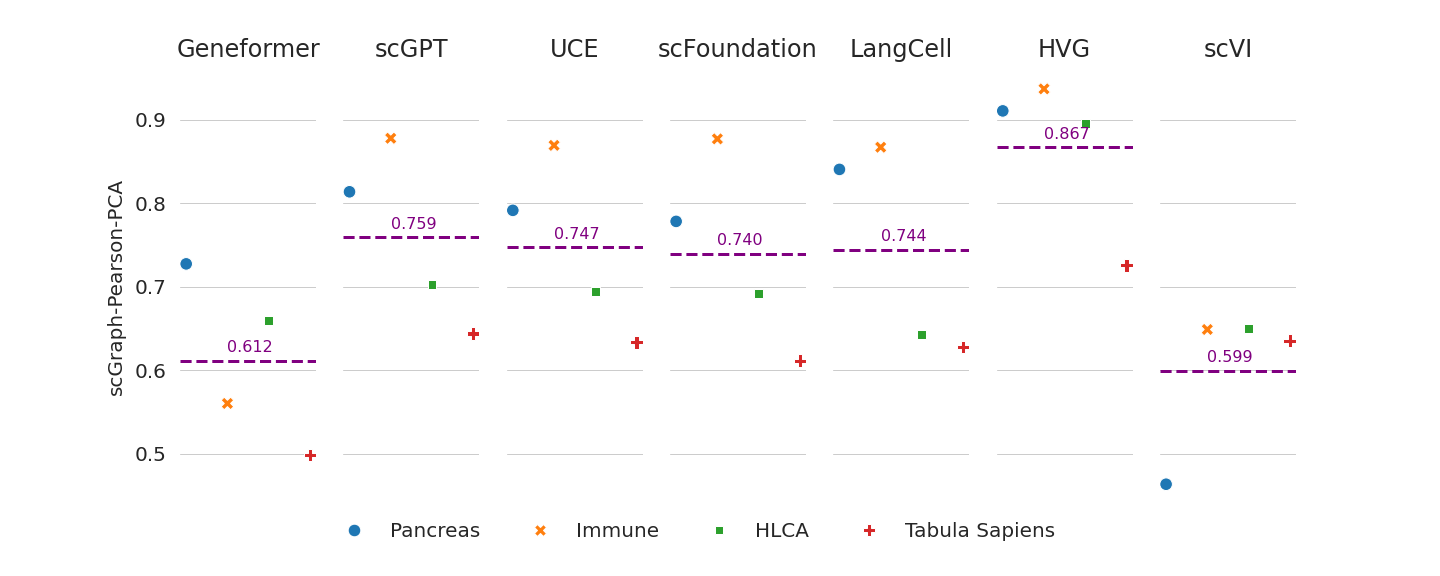

In [77]:
sns.set_style("white")
fig, axes = plt.subplots(1, 7, figsize=(10, 4), sharex=True, sharey=True)
df_grouped = df.groupby("Model")
for i, model in enumerate(model_order):
    df_model = df_grouped.get_group(model)
    if i > 0:
        sns.scatterplot(data=df_model, x="Dataset", y="Pearson-PCA", hue="Dataset", style="Dataset", 
                        ax=axes[i], legend=False, s=40)
    else:
        sns.scatterplot(data=df_model, x="Dataset", y="Pearson-PCA", hue="Dataset", style="Dataset", 
                        ax=axes[i], legend=True, s=40)
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 0), ncol=4, title=None, frameon=False, fontsize=10)
        axes[i].set_ylabel("scGraph-Pearson-PCA")
    
    mean_value = df_model["Pearson-PCA"].mean()
    axes[i].axhline(y=mean_value, color='purple', linestyle='--')
    axes[i].text(1, mean_value+0.01, f'{mean_value:.3f}', color='purple', fontsize=8) 
    
    axes[i].xaxis.set_visible(False)
    axes[i].set_title(model)
    # 删除子图边框
    for spine in ['top', 'right', 'bottom', 'left']:
        axes[i].spines[spine].set_visible(False)

    # 添加网格线
    axes[i].grid(True, which='major', linestyle='-', linewidth=0.5, axis="y")
plt.savefig("figures/clustering/scgraph_pca_all_hvg_with_batchkey.png", dpi=300, bbox_inches='tight')

In [82]:
df = pd.DataFrame()
for dataset in ["HLCA_core", "Tabula_Sapiens_all"]:
    df_ = pd.read_csv(f"output/scGraph/{dataset}.csv", index_col=0)
    df_hvg_wo_batchkey = pd.read_csv(f"output/scGraph_hvg_wo_batchkey/{dataset}.csv", index_col=0)
    # df_.loc["X_scvi"] = df_hvg_wo_batchkey.loc["X_scvi"]
    df_["Dataset"] = dataset_map_dict[dataset]
    df = pd.concat([df, df_], axis=0)
df["Model"] = df.index
df["Model"] = df["Model"].apply(lambda x: model_map_dict.get(x, x))
df

Rank-Counts  Pearson-Counts  Spearman-Counts  Rank-PCA  \
X_geneformer       7.1915          0.7290           0.4978    7.1915   
X_hvg             12.4681          0.8166           0.5961   12.4681   
X_langcell        11.8298          0.8370           0.6136   11.8298   
X_scanvi_emb      15.9149          0.7776           0.5668   15.9149   
X_scgpt           14.8936          0.7759           0.5568   14.8936   
X_scvi            12.7234          0.7960           0.5683   12.7234   
X_uce              8.0851          0.8439           0.6247    8.0851   
X_umap            21.8298          0.4659           0.3461   21.8298   
X_xtrimogene       9.0638          0.8386           0.6073    9.0638   
X_geneformer          NaN          0.7322           0.5766       NaN   
X_hvg                 NaN          0.8467           0.6662       NaN   
X_langcell            NaN          0.8566           0.6265       NaN   
X_pca                 NaN          0.8105           0.6868       NaN   
X_scgpt               NaN          0.8343           0.6185       NaN   
X_scvi                NaN          0.8321           0.6129       NaN   
X_scvi_umap           NaN          0.6033           0.5276       NaN   
X_uce                 NaN          0.8768           0.6516       NaN   
X_umap                NaN          0.6033           0.5276       NaN   
X_xtrimogene          NaN          0.8736           0.6608       NaN   

              Pearson-PCA  Spearman-PCA  Rank-OntoSP  Pearson-OntoSP  \
X_geneformer       0.6601        0.4788       7.6400          0.5591   
X_hvg              0.8957        0.8680      14.3600          0.5287   
X_langcell         0.6425        0.3966      13.0800          0.4791   
X_scanvi_emb       0.6275        0.3975      17.5200          0.4942   
X_scgpt            0.7022        0.4962      16.0800          0.5744   
X_scvi             0.6497        0.4569      13.8800          0.4784   
X_uce              0.6945        0.4595       8.8800          0.5148   
X_umap             0.6408        0.5561      23.5600          0.5890   
X_xtrimogene       0.6919        0.4777       9.7200          0.5680   
X_geneformer       0.4987        0.3380      23.4065          0.2139   
X_hvg              0.7257        0.6358      17.1871          0.3779   
X_langcell         0.6278        0.4335      38.7613          0.4028   
X_pca              0.5818        0.4891      25.8839          0.2009   
X_scgpt            0.6439        0.4691      31.9484          0.2999   
X_scvi             0.6353        0.4683      25.5097          0.3800   
X_scvi_umap        0.4412        0.3832      25.5742          0.5077   
X_uce              0.6334        0.4195      32.0645          0.3891   
X_umap             0.4412        0.3832      25.5742          0.5077   
X_xtrimogene       0.6115        0.4027      33.5871          0.4434   

              Spearman-OntoSP  Rank-Text  Pearson-Text  Spearman-Text  \
X_geneformer           0.4152     7.6400        0.7031         0.4294   
X_hvg                  0.3625    14.3600        0.7470         0.4175   
X_langcell             0.2532    13.0800        0.7432         0.3943   
X_scanvi_emb           0.3286    17.5200        0.7153         0.4053   
X_scgpt                0.4143    16.0800        0.7383         0.4238   
X_scvi                 0.3259    13.8800        0.7061         0.4017   
X_uce                  0.2789     8.8800        0.7727         0.4084   
X_umap                 0.5300    23.5600        0.5618         0.4700   
X_xtrimogene           0.4013     9.7200        0.7818         0.4582   
X_geneformer           0.2895    23.4065        0.3086         0.2915   
X_hvg                  0.2884    17.1871        0.6012         0.3932   
X_langcell             0.3032    38.7613        0.6181         0.3623   
X_pca                  0.1526    25.8839        0.3776         0.2506   
X_scgpt                0.2236    31.9484        0.5325         0.3258   
X_scvi                 0.2995    25.5

In [83]:
df_grouped = df.groupby("Model")[["Pearson-PCA", "Pearson-OntoRWR"]].agg("mean")
df_grouped

Pearson-PCA  Pearson-OntoRWR
Model                                     
Geneformer         0.5794           0.4768
HVG                0.8107           0.6435
LangCell           0.6352           0.6576
UCE                0.6639           0.6954
X_pca              0.5818           0.3915
X_scanvi_emb       0.6275           0.7350
X_scvi_umap        0.4412           0.3252
X_umap             0.5410           0.4073
scFoundation       0.6517           0.6824
scGPT              0.6731           0.6135
scVI               0.6425           0.6199

In [84]:
population = {k: df_grouped.loc[k].values for k in model_order}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['UCE', 'HVG']
Front 2: ['scFoundation', 'scGPT']
Front 3: ['LangCell', 'scVI']
Front 4: ['Geneformer']


In [85]:
population

{'Geneformer': array([0.57938669, 0.47682863]),
 'scGPT': array([0.67306028, 0.61347079]),
 'UCE': array([0.66394821, 0.69544032]),
 'scFoundation': array([0.65170436, 0.68235544]),
 'LangCell': array([0.63519311, 0.65758072]),
 'HVG': array([0.81067125, 0.64349012]),
 'scVI': array([0.64252008, 0.61993807])}

# Cell type annotation

## HLCA

### unseen_ratio = 0
result folder: lr_0.001_l2_1e-06_tesetset_0.2 or lr_0.001_l2_1e-06_tesetset_0.8
1. macro-f1 score (分段), already saved in all_metrics_unseen_0.csv
2. recalculate accuracy score when unseen_ratio > 0
3. compare training data 80% v.s. 20%

In [26]:
dataset_name = "HLCA_core"
# output_folder = f"../OnClass/result/"
output_folder = f"../OnClass/results_best_params/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    params = model_to_params[dataset_name][model]
    lr, l2 = float(params["lr"]), float(params["l2"])
    result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_{lr}_l2_{l2}_testset_0.8/all_metrics_unseen_0.csv")
    df = pd.read_csv(result_path).iloc[:-2, :]
    if model == "xTrimoGene":
        df["model"] = "scFoundation"
    else:
        df["model"] = model
    df_all = pd.concat([df_all, df])
df_all.head()

AUROC   AUPRC  AUROC(seen)  AUPRC(seen)  AUROC(unseen)  AUPRC(unseen)  \
0  0.9993  0.9980       0.9993       0.9980            NaN            NaN   
1  0.9993  0.9981       0.9993       0.9981            NaN            NaN   
2  0.9993  0.9981       0.9993       0.9981            NaN            NaN   
3  0.9992  0.9980       0.9992       0.9980            NaN            NaN   
4  0.9993  0.9981       0.9993       0.9981            NaN            NaN   

   Cohens Kappa  Accuracy@3  Accuracy@5  Accuracy@1  Macro F1  Macro F1 <100  \
0        0.9362      0.9963      0.9990      0.9411    0.9110         0.8531   
1        0.9353      0.9964      0.9989      0.9403    0.9089         0.8494   
2        0.9386      0.9965      0.9991      0.9433    0.9169         0.8731   
3        0.9350      0.9965      0.9990      0.9400    0.9072         0.8151   
4        0.9379      0.9966      0.9990      0.9427    0.9121         0.8407   

   Macro F1 [100, 1000)  Macro F1 [1000, 5000)  Macro F1 >=5000  \
0                0.9018                 0.9222           0.9384   
1                0.8968                 0.9231           0.9372   
2                0.9068                 0.9269           0.9400   
3                0.9029                 0.9234           0.9360   
4                0.9045                 0.9257           0.9395   

   Accuracy@1(nonleaf)    LCAD model  
0               0.5994  2.4266  scVI  
1               0.5872  2.4052  scVI  
2               0.5646  2.4120  scVI  
3               0.5705  2.4077  scVI  
4               0.5707  2.4742  scVI

In [149]:
df_grouped = df_all.groupby("model").agg("mean")
df_grouped

AUROC   AUPRC  AUROC(seen)  AUPRC(seen)  AUROC(unseen)  \
model                                                                   
Geneformer    0.9980  0.9950       0.9980       0.9950            NaN   
LangCell      0.9986  0.9965       0.9986       0.9965            NaN   
UCE           0.9990  0.9976       0.9990       0.9976            NaN   
scFoundation  0.9989  0.9975       0.9989       0.9975            NaN   
scGPT         0.9981  0.9946       0.9981       0.9946            NaN   
scVI          0.9993  0.9980       0.9993       0.9980            NaN   

              AUPRC(unseen)  Cohens Kappa  Accuracy@3  Accuracy@5  Accuracy@1  \
model                                                                           
Geneformer              NaN        0.9125      0.9939      0.9981      0.9193   
LangCell                NaN        0.9274      0.9952      0.9984      0.9329   
UCE                     NaN        0.9361      0.9964      0.9989      0.9410   
scFoundation            NaN        0.9422      0.9966      0.9989      0.9467   
scGPT                   NaN        0.9015      0.9923      0.9974      0.9091   
scVI                    NaN        0.9366      0.9964      0.9990      0.9415   

              Macro F1  Macro F1 <100  Macro F1 [100, 1000)  \
model                                                         
Geneformer      0.8518         0.7119                0.8225   
LangCell        0.8901         0.8216                0.8711   
UCE             0.9138         0.8627                0.9044   
scFoundation    0.9190         0.8735                0.9047   
scGPT           0.8535         0.7206                0.8434   
scVI            0.9112         0.8463                0.9025   

              Macro F1 [1000, 5000)  Macro F1 >=5000  Accuracy@1(nonleaf)  \
model                                                                       
Geneformer                   0.8880           0.9151               0.5684   
LangCell                     0.9065           0.9305               0.5838   
UCE                          0.9265           0.9356               0.6041   
scFoundation                 0.9343           0.9419               0.5913   
scGPT                        0.8742           0.9053               0.5832   
scVI                         0.9243           0.9382               0.5785   

                LCAD  
model                 
Geneformer    2.4020  
LangCell      2.3703  
UCE           2.4142  
scFoundation  2.4082  
scGPT         2.4164  
scVI          2.4251

In [120]:
df_all["LCAD_rank"] = - df_all["LCAD"]
df_grouped = df_all.groupby("model").agg("mean")
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1", "LCAD_rank"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([ 0.91929082,  0.85180745, -2.40203178]), 'LangCell': array([ 0.93294058,  0.89007702, -2.37029303]), 'UCE': array([ 0.94103581,  0.91381305, -2.41417927]), 'scFoundation': array([ 0.94668708,  0.91896087, -2.40822818]), 'scGPT': array([ 0.90909333,  0.85350831, -2.41637356]), 'scVI': array([ 0.94150091,  0.91122556, -2.42510815])}
Front 1: ['LangCell', 'scFoundation']
Front 2: ['Geneformer', 'UCE', 'scVI']
Front 3: ['scGPT']


In [121]:
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.91929082, 0.85180745]), 'LangCell': array([0.93294058, 0.89007702]), 'UCE': array([0.94103581, 0.91381305]), 'scFoundation': array([0.94668708, 0.91896087]), 'scGPT': array([0.90909333, 0.85350831]), 'scVI': array([0.94150091, 0.91122556])}
Front 1: ['scFoundation']
Front 2: ['UCE', 'scVI']
Front 3: ['LangCell']
Front 4: ['Geneformer', 'scGPT']


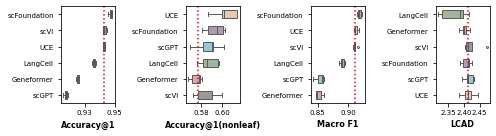

In [27]:
from matplotlib.ticker import FormatStrFormatter
def plot_violin(ax, x, y, data, hue, order, palette, xlabel, median_value):
    # sns.violinplot(x=x, y=y, data=data, hue=hue, width=0.5, alpha=0.8, ax=ax, order=order, palette=palette)
    sns.boxplot(x=x, y=y, data=data, hue=hue, width=0.5, ax=ax, order=order, palette=palette,
                flierprops=dict(marker='o', color='black', markersize=2, linestyle='none'))
    ax.axvline(x=median_value, color='r', linestyle=':')
    ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel(xlabel, fontweight="bold", fontsize=8)

def get_model_order(df, column, ascending=False):
    median_values = df.groupby('model')[column].median().sort_values(ascending=ascending)
    return median_values.index.tolist() 

fig, axes = plt.subplots(1, 4, figsize=(7, 2))
plt.subplots_adjust(wspace=0.1) 

for i, col in enumerate(["Accuracy@1", "Accuracy@1(nonleaf)", "Macro F1", "LCAD"]):
    model_order = get_model_order(df_all, col, ascending=True if col=="LCAD" else False)
    plot_violin(axes[i], col, 'model', df_all, 'model', model_order, custom_palette,
                col, df_all[df_all["model"] == "scVI"][col].median())

plt.tight_layout()
# plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/HLCA_Onclass_Yemb_0107.png", dpi=300, bbox_inches="tight")

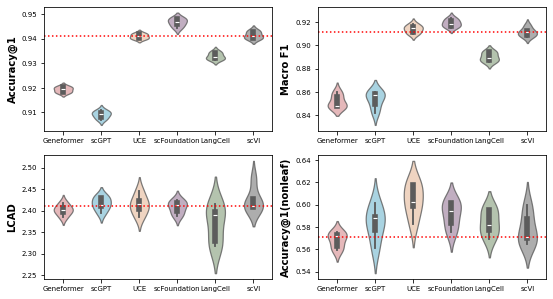

In [27]:
def plot_violin(ax, x, y, data, hue, order, palette, xlabel, median_value):
    sns.violinplot(x=x, y=y, data=data, hue=hue, width=0.5, alpha=0.8, ax=ax, order=order, palette=palette)
    ax.axhline(y=median_value, color='r', linestyle=':')
    ax.set_xlabel("")
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_ylabel(xlabel, fontweight="bold", fontsize=10)

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for i, col in enumerate(["Accuracy@1", "Macro F1", "LCAD", "Accuracy@1(nonleaf)"]):
    plot_violin(axes[i // 2, i % 2], 'model', col, df_all, 'model', model_order_wo_hvg, custom_palette,
                col, df_all[df_all["model"] == "scVI"][col].median())

plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/HLCA_Onclass_Yemb.png", dpi=300, bbox_inches="tight")

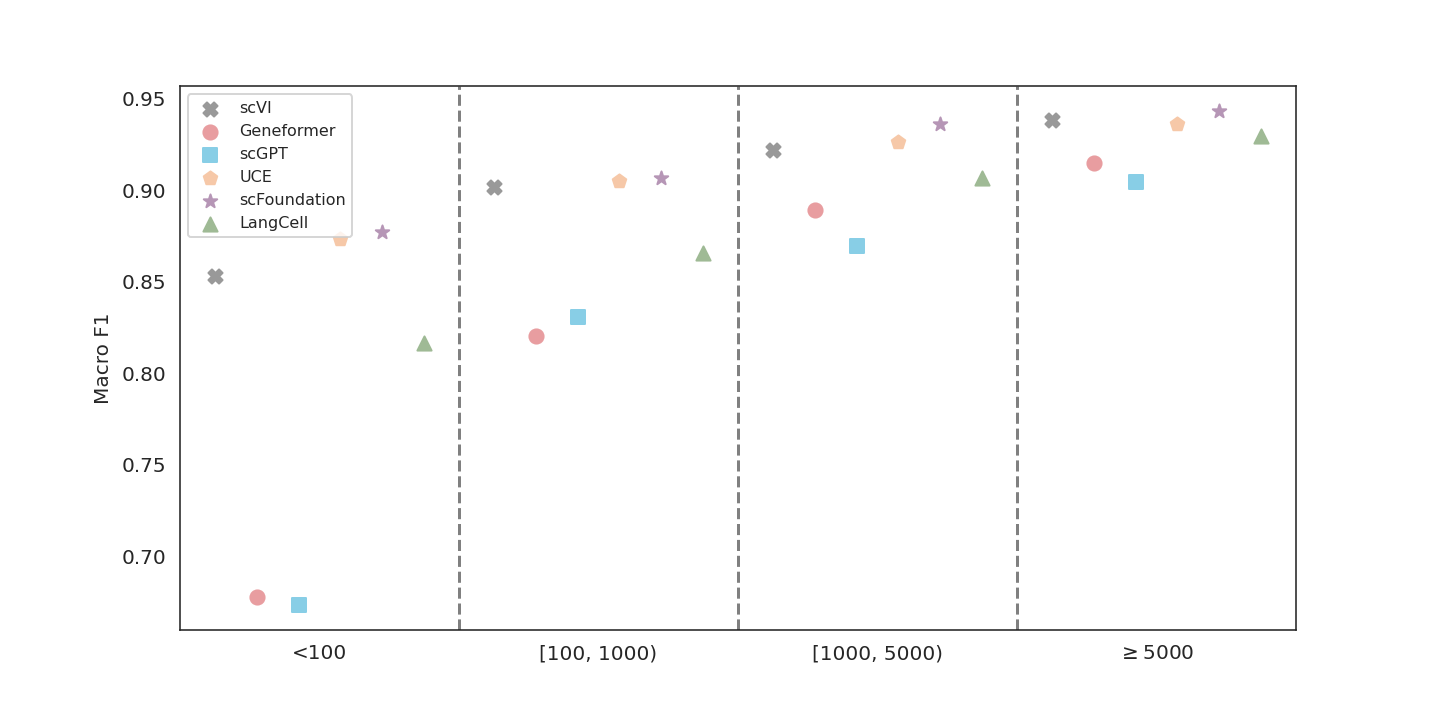

In [93]:
plt.figure(figsize=(10,5))
x = np.arange(1,5)
x_line = [0.5, 1.5, 2.5, 3.5, 4.5]
plt.xlim(0.5, 4.5)
width = 0.15
for i, model_name in enumerate(df_all["model"].unique()):
    x_pos = x + i * width - 2.5 * width  # Adjust x position for each dataset
    y = df_all[df_all["model"]==model_name].values[0, -8:-4].tolist()
    # print(x_pos)
    plt.scatter(x_pos, y, s=50, alpha=1, label=model_name, zorder=2, 
                marker=custom_shape[model_name], color=custom_palette[model_name])
    if model_name == "X":
        x_min = x_line[:-1]
        x_max = x_line[1:]
        xlim = plt.gca().get_xlim()
        for y_, x_min_, x_max_ in zip(y, x_min, x_max):
            print(y_, x_min_, x_max_)
            x_min_ = (x_min_ - xlim[0]) / (xlim[1] - xlim[0])
            x_max_ = (x_max_ - xlim[0]) / (xlim[1] - xlim[0])
            plt.axhline(y=y_, xmin=x_min_, xmax=x_max_, ls="--", color="red",zorder=1)

plt.legend(fontsize=8)
for x in x_line[1:-1]:
    plt.axvline(x=x, ls="--", color="grey")   
plt.ylabel("Macro F1")
plt.xticks(ticks=[1,2,3,4], labels=['<100', '[100, 1000)', '[1000, 5000)', '$\geq$5000'])
plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/HLCA_Onclass_Yemb_macrof1.png", dpi=300, bbox_inches="tight")

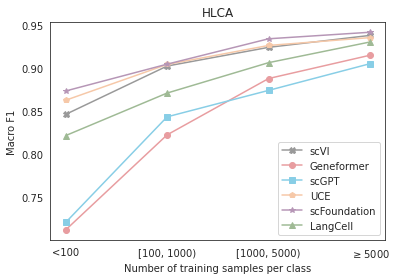

In [101]:
x = np.arange(4)
for i, model_name in enumerate(df_all["model"].unique()):
    y = df_all[df_all["model"]==model_name].values[:, -7:-3].mean(0).tolist()
    plt.plot(x, y, color=custom_palette[model_name], label=model_name, marker=custom_shape[model_name])
    # plt.scatter(x, y, color=custom_palette[model_name])
plt.xticks(x, labels=['<100', '[100, 1000)', '[1000, 5000)', '$\geq$5000'])
plt.xlabel("Number of training samples per class")
plt.ylabel("Macro F1")
plt.legend(ncol=1)
plt.title("HLCA")
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/HLCA_Onclass_Yemb_macrof1_lineplot.png", dpi=300)

### unseen_ratio > 0

#### Confidence-adjusted confidence score
scBERT: evaluate the accuracy of novel cell type and known cell types, separately. Notably, we employed a strict evaluation method for novel cell types with the accuracy calculated on the union set of cells with the novel cell type label and the cells that are predicted as novel cell types

In [95]:
dataset_name = "HLCA_core"
output_folder = f"../OnClass/results_best_params/"
model_ls = ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
result_ls = []
for unseen_ratio in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y_pred_ls = []
    unseen_confidence_ls = []
    for model in model_ls:
        params = model_to_params[dataset_name][model]
        lr, l2 = float(params["lr"]), float(params["l2"])
        for iter in range(5):
            result_file = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_{lr}_l2_{l2}_testset_0.2/{iter}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_file)
            y_true = df["y_true"]
            y_pred = df["y_pred"]

            result = {
                "model": model if model != "xTrimoGene" else "scFoundation",
                "unseen_ratio": unseen_ratio,
                "iter": iter,
            }

            for FPR in [0.05, 0.1, 0.2]:
                cut_off_ratio, number_unkonw = get_FPR(df[df["unseen"]==1].negative_energy, FPR=FPR)
                acc_unknown = accuracy_for_unkonw(y_pred, df["negative_energy"], y_true, number_unkonw, cut_off_ratio=cut_off_ratio)
                result.update({f"Accuracy(FPR={FPR})": acc_unknown})
            
            auroc_softmax = roc_auc_score(1-df["unseen"], df["softmax_score"])
            auprc_softmax = average_precision_score(1-df["unseen"], df["softmax_score"])

            auroc_energy = roc_auc_score(1-df["unseen"], df["negative_energy"])
            auprc_energy = average_precision_score(1-df["unseen"], df["negative_energy"])
            result.update({
                "AUROC(softmax)": auroc_softmax,
                "AUPRC(softmax)": auprc_softmax,
                "AUROC(energy)": auroc_energy,
                "AUPRC(energy)": auprc_energy
                })

            result_ls.append(result)
result_df = pd.DataFrame(result_ls)
result_df

model  unseen_ratio  iter  Accuracy(FPR=0.05)  Accuracy(FPR=0.1)  \
0        scVI           0.1     0              0.5271             0.6464   
1        scVI           0.1     1              0.3002             0.4172   
2        scVI           0.1     2              0.6025             0.7222   
3        scVI           0.1     3              0.7474             0.8413   
4        scVI           0.1     4              0.5997             0.7076   
..        ...           ...   ...                 ...                ...   
145  LangCell           0.9     0              0.4083             0.6201   
146  LangCell           0.9     1              0.4428             0.6848   
147  LangCell           0.9     2              0.6288             0.6768   
148  LangCell           0.9     3              0.1825             0.5006   
149  LangCell           0.9     4              0.1166             0.2589   

     Accuracy(FPR=0.2)  AUROC(softmax)  AUPRC(softmax)  AUROC(energy)  \
0               0.7753          0.8288          0.9257         0.8842   
1               0.5707          0.7563          0.8653         0.7742   
2               0.8293          0.8398          0.9612         0.9069   
3               0.9016          0.9083          0.9379         0.9519   
4               0.8112          0.8323          0.9483         0.8985   
..                 ...             ...             ...            ...   
145             0.8732          0.9120          0.1384         0.9062   
146             0.8410          0.8082          0.0574         0.8961   
147             0.7553          0.8843          0.3080         0.8745   
148             0.7981          0.8834          0.0986         0.8580   
149             0.6550          0.9102          0.1777         0.8121   

     AUPRC(energy)  
0           0.9495  
1           0.8810  
2           0.9776  
3           0.9671  
4           0.9707  
..             ...  
145         0.1938  
146         0.1090  
147         0.4162  
148         0.0713  
149         0.1094  

[150 rows x 10 columns]

In [12]:
# result_df.to_csv("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/hlca_accuracy_unseen.csv",index=False)
result_df = pd.read_csv("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/hlca_accuracy_unseen.csv")

In [99]:
df_grouped = result_df.groupby("model").agg("mean")
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy(FPR=0.05)", "Accuracy(FPR=0.1)", "Accuracy(FPR=0.2)"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.36493527, 0.49370682, 0.67493186]), 'LangCell': array([0.35338765, 0.51442581, 0.71887928]), 'UCE': array([0.45035753, 0.61514088, 0.80408696]), 'scFoundation': array([0.37829598, 0.56082185, 0.75405769]), 'scGPT': array([0.33061169, 0.46212799, 0.66796988]), 'scVI': array([0.36867051, 0.52603342, 0.72424885])}
Front 1: ['UCE']
Front 2: ['scFoundation']
Front 3: ['scVI']
Front 4: ['Geneformer', 'LangCell']
Front 5: ['scGPT']


In [106]:
summary = result_df.groupby(["model", "unseen_ratio"]).agg({"Accuracy(FPR=0.05)": ['mean', 'std']}).reset_index()
summary.columns = ["model", "unseen_ratio", 'mean', 'std']
summary

model  unseen_ratio    mean     std
0     Geneformer           0.1  0.5392  0.1663
1     Geneformer           0.3  0.2972  0.1425
2     Geneformer           0.5  0.3599  0.1415
3     Geneformer           0.7  0.2536  0.1021
4     Geneformer           0.9  0.3748  0.2478
5       LangCell           0.1  0.4816  0.1006
6       LangCell           0.3  0.3471  0.0717
7       LangCell           0.5  0.2970  0.1015
8       LangCell           0.7  0.2855  0.1057
9       LangCell           0.9  0.3558  0.2074
10           UCE           0.1  0.6165  0.1999
11           UCE           0.3  0.3491  0.0811
12           UCE           0.5  0.4202  0.1576
13           UCE           0.7  0.3792  0.1172
14           UCE           0.9  0.4868  0.2955
15  scFoundation           0.1  0.4473  0.2285
16  scFoundation           0.3  0.3320  0.1100
17  scFoundation           0.5  0.3759  0.0674
18  scFoundation           0.7  0.3259  0.0806
19  scFoundation           0.9  0.4104  0.1578
20         scGPT           0.1  0.4725  0.1940
21         scGPT           0.3  0.2735  0.0639
22         scGPT           0.5  0.2892  0.1187
23         scGPT           0.7  0.2706  0.1321
24         scGPT           0.9  0.3472  0.2091
25          scVI           0.1  0.5554  0.1635
26          scVI           0.3  0.2805  0.0361
27          scVI           0.5  0.3164  0.0647
28          scVI           0.7  0.3266  0.1058
29          scVI           0.9  0.3644  0.1596

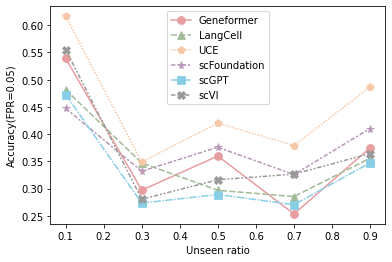

In [108]:
sns.lineplot(x='unseen_ratio', y='mean', data=summary, style='model', hue='model', markers=custom_shape, markersize=8, markeredgecolor=None, palette=custom_palette)
plt.xlabel("Unseen ratio")
plt.ylabel("Accuracy(FPR=0.05)")
ax = plt.gca()
ax.legend(title="")

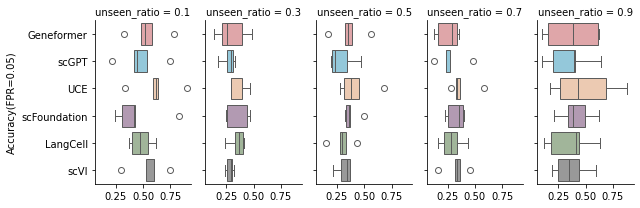

In [189]:
grid = sns.FacetGrid(result_df, col="unseen_ratio", aspect=0.6)
grid.map(sns.boxplot, "Accuracy(FPR=0.05)", "model", data=result_df, hue="model", 
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.05)")
# grid.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/hlca_accuracy_fpr_0.05.png", dpi=300, bbox_inches='tight')

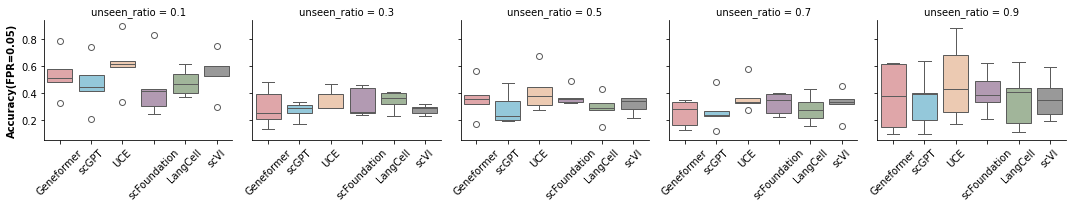

In [19]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.05)", data=result_df, hue="model", 
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.05)", fontweight="bold")
grid.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/hlca_accuracy_fpr_0.05.png", dpi=300, bbox_inches='tight')

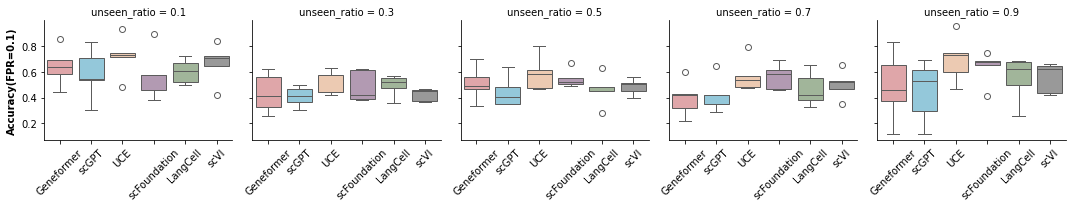

In [20]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.1)", data=result_df, hue="model",
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.1)", fontweight="bold")
grid.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/hlca_accuracy_fpr_0.1.png", dpi=300, bbox_inches='tight')

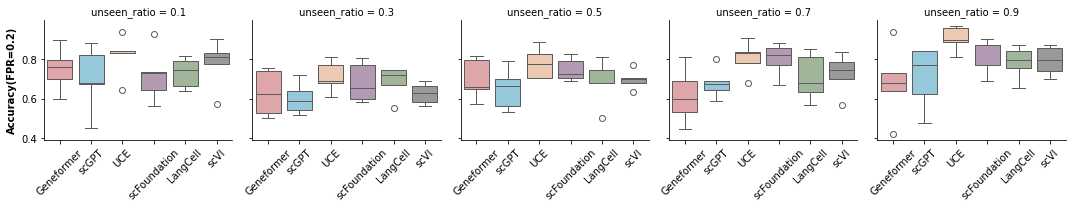

In [21]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.2)", data=result_df, hue="model", 
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.2)", fontweight="bold")
grid.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/hlca_accuracy_fpr_0.2.png", dpi=300, bbox_inches='tight')

#### OOD detection

In [105]:
result_grouped = result_df.groupby(["model", "unseen_ratio"]).agg("mean").reset_index()
result_grouped

model  unseen_ratio  iter  Accuracy(FPR=0.05)  Accuracy(FPR=0.1)  \
0     Geneformer           0.1   2.0              0.5392             0.6421   
1     Geneformer           0.3   2.0              0.2972             0.4339   
2     Geneformer           0.5   2.0              0.3599             0.5097   
3     Geneformer           0.7   2.0              0.2536             0.3952   
4     Geneformer           0.9   2.0              0.3748             0.4876   
5       LangCell           0.1   2.0              0.4816             0.6012   
6       LangCell           0.3   2.0              0.3471             0.4919   
7       LangCell           0.5   2.0              0.2970             0.4646   
8       LangCell           0.7   2.0              0.2855             0.4662   
9       LangCell           0.9   2.0              0.3558             0.5483   
10           UCE           0.1   2.0              0.6165             0.7201   
11           UCE           0.3   2.0              0.3491             0.5003   
12           UCE           0.5   2.0              0.4202             0.5866   
13           UCE           0.7   2.0              0.3792             0.5699   
14           UCE           0.9   2.0              0.4868             0.6988   
15  scFoundation           0.1   2.0              0.4473             0.5762   
16  scFoundation           0.3   2.0              0.3320             0.4862   
17  scFoundation           0.5   2.0              0.3759             0.5470   
18  scFoundation           0.7   2.0              0.3259             0.5616   
19  scFoundation           0.9   2.0              0.4104             0.6331   
20         scGPT           0.1   2.0              0.4725             0.5861   
21         scGPT           0.3   2.0              0.2735             0.4088   
22         scGPT           0.5   2.0              0.2892             0.4439   
23         scGPT           0.7   2.0              0.2706             0.4237   
24         scGPT           0.9   2.0              0.3472             0.4482   
25          scVI           0.1   2.0              0.5554             0.6669   
26          scVI           0.3   2.0              0.2805             0.4212   
27          scVI           0.5   2.0              0.3164             0.4857   
28          scVI           0.7   2.0              0.3266             0.5024   
29          scVI           0.9   2.0              0.3644             0.5539   

    Accuracy(FPR=0.2)  AUROC(softmax)  AUPRC(softmax)  AUROC(energy)  \
0              0.7515          0.7857          0.9086         0.8758   
1              0.6304          0.7858          0.6488         0.8209   
2              0.6981          0.7637          0.5349         0.8435   
3              0.6140          0.7894          0.3471         0.8212   
4              0.6808          0.8490          0.1717         0.8454   
5              0.7312          0.8122          0.9188         0.8619   
6              0.6854          0.8088          0.6837         0.8425   
7              0.6835          0.7730          0.5124         0.8380   
8              0.7098          0.8178          0.3480         0.8488   
9              0.7845          0.8796          0.1560         0.8694   
10             0.8189          0.8180          0.9211         0.9074   
11             0.7105          0.8155          0.6870         0.8584   
12             0.7799          0.7849          0.5434         0.8819   
13             0.8068          0.8418          0.4090         0.8857   
14             0.9042          0.9318          0.3387         0.9144   
15             0.7202          0.8120          0.9157         0.8580   
16             0.6819          0.7956          0.6476         0.8364   
17             0.7473          0.7694          0.4958         0.8625   
18             0.8001          0.8183          0.3436         0.8728   
19             0.8208          0.8820          0.1653         0.8854   
20             0.7006          0.7762          0.

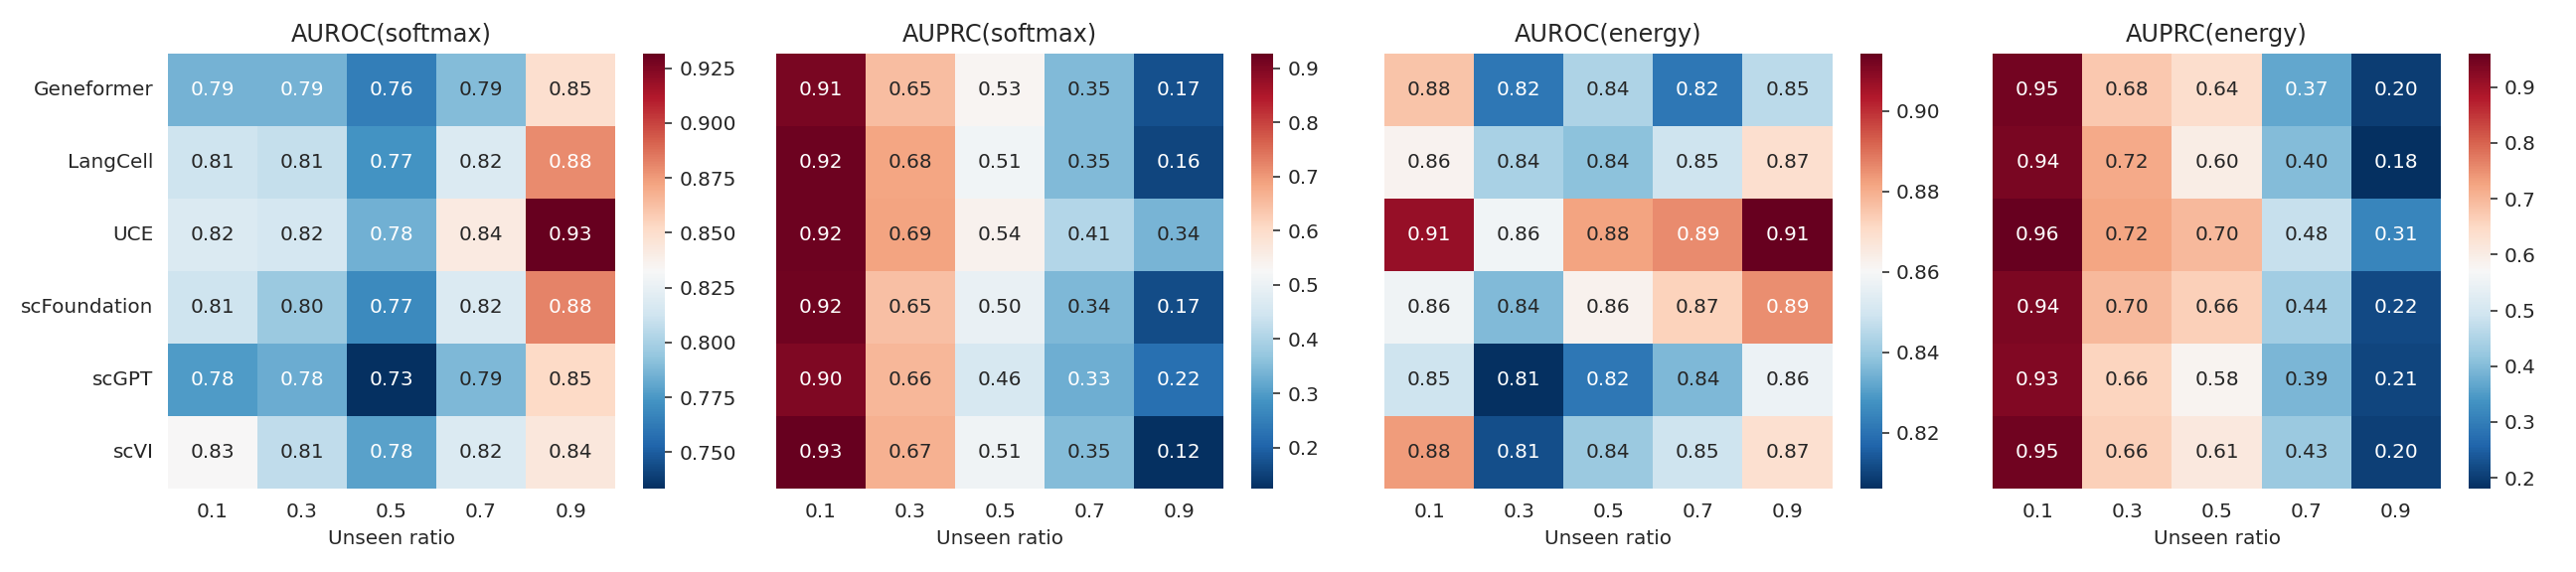

In [110]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharex=True, sharey=False)
for i, col in enumerate(["AUROC(softmax)", "AUPRC(softmax)", "AUROC(energy)", "AUPRC(energy)"]):
    heatmap_df = result_grouped.pivot(index="model", columns="unseen_ratio", values=col)
    sns.heatmap(heatmap_df, annot=True, cmap="RdBu_r", ax=axes[i], fmt='.2f')
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Unseen ratio")
    axes[i].set_title(col)
    if i > 0:
        axes[i].set_yticklabels("")
plt.tight_layout()
plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/hlca_confidence_iid_positive.png", dpi=300, bbox_inches='tight')

## Tabula Sapiens

### unseen_ratio = 0

In [28]:
dataset_name = "Tabula_Sapiens_all"
# output_folder = f"../OnClass/result/"
output_folder = f"../OnClass/results_best_params/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    params = model_to_params[dataset_name][model]
    lr, l2 = float(params["lr"]), float(params["l2"])
    for unseen_ratio in [0]:
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_{lr}_l2_{l2}_testset_0.8/all_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path).iloc[:-2, :]
        if model == "xTrimoGene":
            df["model"] = "scFoundation"
        else:
            df["model"] = model
        df_all = pd.concat([df_all, df])
df_all.head()

AUROC   AUPRC  AUROC(seen)  AUPRC(seen)  AUROC(unseen)  AUPRC(unseen)  \
0  0.9970  0.9917       0.9970       0.9917            NaN            NaN   
1  0.9971  0.9910       0.9971       0.9910            NaN            NaN   
2  0.9968  0.9903       0.9968       0.9903            NaN            NaN   
3  0.9974  0.9913       0.9974       0.9913            NaN            NaN   
4  0.9972  0.9916       0.9972       0.9916            NaN            NaN   

   Cohens Kappa  Accuracy@3  Accuracy@5  Accuracy@1  Macro F1  Macro F1 <100  \
0        0.8612      0.9718      0.9889      0.8656    0.6765         0.5479   
1        0.8584      0.9707      0.9890      0.8629    0.6661         0.5345   
2        0.8630      0.9728      0.9899      0.8673    0.6817         0.5561   
3        0.8619      0.9726      0.9896      0.8662    0.6885         0.5711   
4        0.8690      0.9738      0.9901      0.8731    0.7037         0.5925   

   Macro F1 [100, 1000)  Macro F1 [1000, 5000)  Macro F1 >=5000  \
0                0.7611                 0.8706              NaN   
1                0.7525                 0.8654              NaN   
2                0.7645                 0.8711              NaN   
3                0.7630                 0.8712              NaN   
4                0.7743                 0.8769              NaN   

   Accuracy@1(nonleaf)    LCAD model  
0               0.4793  2.1863  scVI  
1               0.4889  2.1500  scVI  
2               0.4648  2.1811  scVI  
3               0.4717  2.1645  scVI  
4               0.4638  2.1759  scVI

In [45]:
df_all["LCAD_rank"] = - df_all["LCAD"]
df_grouped = df_all.groupby("model").agg("mean")
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1", "LCAD_rank"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([ 0.85780208,  0.61623062, -2.178942  ]), 'LangCell': array([ 0.896001  ,  0.7239172 , -2.10166349]), 'UCE': array([ 0.90902583,  0.78126821, -2.06411778]), 'scFoundation': array([ 0.9128577 ,  0.77673268, -2.02378273]), 'scGPT': array([ 0.83889157,  0.64134797, -2.27596735]), 'scVI': array([ 0.8670034 ,  0.68329797, -2.17155159])}
Front 1: ['UCE', 'scFoundation']
Front 2: ['LangCell']
Front 3: ['scVI']
Front 4: ['Geneformer', 'scGPT']


In [46]:
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.85780208, 0.61623062]), 'LangCell': array([0.896001 , 0.7239172]), 'UCE': array([0.90902583, 0.78126821]), 'scFoundation': array([0.9128577 , 0.77673268]), 'scGPT': array([0.83889157, 0.64134797]), 'scVI': array([0.8670034 , 0.68329797])}
Front 1: ['UCE', 'scFoundation']
Front 2: ['LangCell']
Front 3: ['scVI']
Front 4: ['Geneformer', 'scGPT']


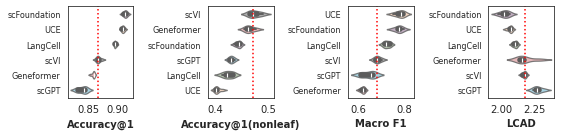

In [103]:
def plot_violin(ax, x, y, data, hue, order, palette, xlabel, median_value):
    sns.violinplot(x=x, y=y, data=data, hue=hue, width=0.5, alpha=0.8, ax=ax, order=order, palette=palette,
                   flierprops=dict(marker='o', color='black', markersize=2, linestyle='none'))
    ax.axvline(x=median_value, color='r', linestyle=':')
    ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel(xlabel, fontweight="bold")

def get_model_order(df, column, ascending=False):
    median_values = df.groupby('model')[column].median().sort_values(ascending=ascending)
    return median_values.index.tolist() 

fig, axes = plt.subplots(1, 4, figsize=(8, 2))

for i, col in enumerate(["Accuracy@1", "Accuracy@1(nonleaf)", "Macro F1", "LCAD"]):
    model_order = get_model_order(df_all, col, ascending=True if col=="LCAD" else False)
    plot_violin(axes[i], col, 'model', df_all, 'model', model_order, custom_palette,
                col, df_all[df_all["model"] == "scVI"][col].median())
    
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/Tabula_Onclass_Yemb_0107.png", dpi=300, bbox_inches="tight")

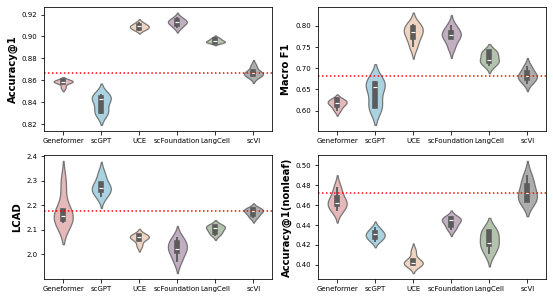

In [29]:
def plot_violin(ax, x, y, data, hue, order, palette, xlabel, median_value):
    sns.violinplot(x=x, y=y, data=data, hue=hue, width=0.5, alpha=0.8, ax=ax, order=order, palette=palette)
    ax.axhline(y=median_value, color='r', linestyle=':')
    ax.set_xlabel("")
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_ylabel(xlabel, fontweight="bold", fontsize=10)

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for i, col in enumerate(["Accuracy@1", "Macro F1", "LCAD", "Accuracy@1(nonleaf)"]):
    plot_violin(axes[i // 2, i % 2], 'model', col, df_all, 'model', model_order_wo_hvg, custom_palette,
                col, df_all[df_all["model"] == "scVI"][col].median())

plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/Tabula_Onclass_Yemb.png", dpi=300, bbox_inches="tight")

In [64]:
df_all[df_all["model"]=="scVI"]

AUROC   AUPRC  AUROC(seen)  AUPRC(seen)  AUROC(unseen)  AUPRC(unseen)  \
0  0.9970  0.9917       0.9970       0.9917            NaN            NaN   
1  0.9971  0.9910       0.9971       0.9910            NaN            NaN   
2  0.9968  0.9903       0.9968       0.9903            NaN            NaN   
3  0.9974  0.9913       0.9974       0.9913            NaN            NaN   
4  0.9972  0.9916       0.9972       0.9916            NaN            NaN   

   Cohens Kappa  Accuracy@3  Accuracy@5  Accuracy@1  Macro F1  Macro F1 <100  \
0        0.8612      0.9718      0.9889      0.8656    0.6765         0.5479   
1        0.8584      0.9707      0.9890      0.8629    0.6661         0.5345   
2        0.8630      0.9728      0.9899      0.8673    0.6817         0.5561   
3        0.8619      0.9726      0.9896      0.8662    0.6885         0.5711   
4        0.8690      0.9738      0.9901      0.8731    0.7037         0.5925   

   Macro F1 [100, 1000)  Macro F1 [1000, 5000)  Macro F1 >=5000  \
0                0.7611                 0.8706              NaN   
1                0.7525                 0.8654              NaN   
2                0.7645                 0.8711              NaN   
3                0.7630                 0.8712              NaN   
4                0.7743                 0.8769              NaN   

   Accuracy@1(nonleaf)    LCAD model  LCAD_rank  
0               0.4793  2.1863  scVI    -2.1863  
1               0.4889  2.1500  scVI    -2.1500  
2               0.4648  2.1811  scVI    -2.1811  
3               0.4717  2.1645  scVI    -2.1645  
4               0.4638  2.1759  scVI    -2.1759

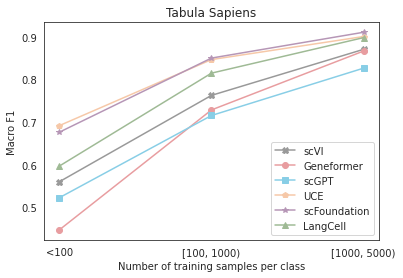

In [89]:
# plot one time --> average of five times
x = np.arange(3)
for i, model_name in enumerate(df_all["model"].unique()):
    y = df_all[df_all["model"]==model_name].values[:, -7:-4].mean(0).tolist()
    plt.plot(x, y, color=custom_palette[model_name], label=model_name, marker=custom_shape[model_name])
    # plt.scatter(x, y, color=custom_palette[model_name])
plt.xticks(x, labels=['<100', '[100, 1000)', '[1000, 5000)'])
plt.xlabel("Number of training samples per class")
plt.ylabel("Macro F1")
plt.legend(ncol=1)
plt.title("Tabula Sapiens")
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/Tabula_Onclass_Yemb_macrof1_lineplot.png", dpi=300)

### unseen_ratio > 0

#### Distribution of confidence scores

In [129]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"../OnClass/results_best_params/"
pred_df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    params = model_to_params[dataset_name][model]
    lr, l2 = float(params["lr"]), float(params["l2"])
    for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
        for seed in range(5):
            result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_{lr}_l2_{l2}_testset_0.2/{seed}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_path)
            if model == "xTrimoGene":
                df["model"] = "scFoundation"
            else:
                df["model"] = model
            df["unseen_ratio"] = unseen_ratio
            df["seed"] = seed
            pred_df_all = pd.concat([pred_df_all, df])
pred_df_all.head()

y_true      y_pred  y_pred_all  softmax_score  energy_score  \
0  CL:0002623  CL:0002518  CL:0002518         0.5603        0.2656   
1  CL:0002623  CL:0000646  CL:0000646         0.6433       -1.1183   
2  CL:0000233  CL:0000232  CL:0000232         0.9871       -3.1622   
3  CL:0002623  CL:0002518  CL:0002518         0.6919       -2.8209   
4  CL:0002623  CL:0000746  CL:0000746         0.9546       -2.1236   

   negative_energy  unseen model  unseen_ratio  seed  
0          -0.2656       1  scVI           0.1     0  
1           1.1183       1  scVI           0.1     0  
2           3.1622       1  scVI           0.1     0  
3           2.8209       1  scVI           0.1     0  
4           2.1236       1  scVI           0.1     0

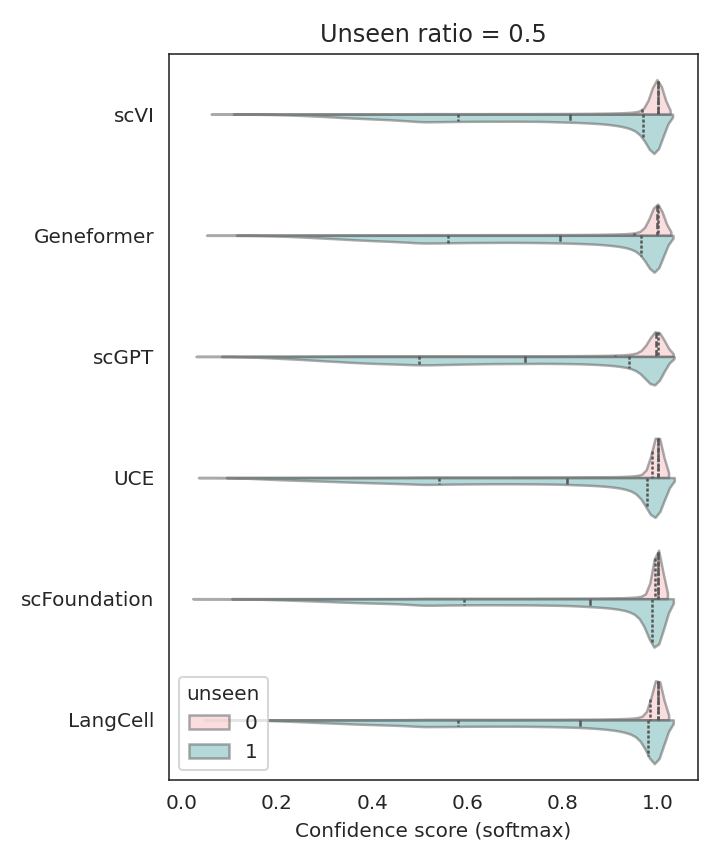

In [130]:
# visualize probs distribution
unseen_ratio = 0.5
plt.figure(figsize=(5,6))
sns.violinplot(data=pred_df_all[pred_df_all["unseen_ratio"]==unseen_ratio], x="softmax_score", y="model", hue="unseen",
               split=True, 
               inner="quart", fill=True,
               palette={0: "#ffb6b9", 1: "#61c0bf"},
               alpha=0.5
               )
plt.xlabel("Confidence score (softmax)")
plt.ylabel("")
plt.title(f"Unseen ratio = {unseen_ratio}")
plt.tight_layout()

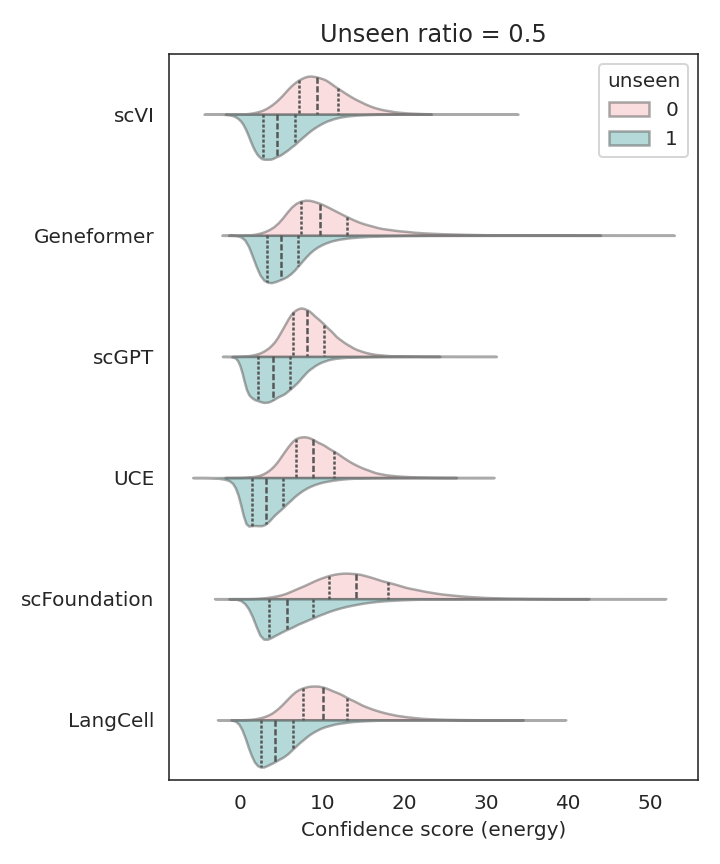

In [131]:
unseen_ratio = 0.5
plt.figure(figsize=(5,6))
sns.violinplot(data=pred_df_all[pred_df_all["unseen_ratio"]==unseen_ratio], x="negative_energy", y="model", hue="unseen",
               split=True, 
               inner="quart", fill=True,
               palette={0: "#ffb6b9", 1: "#61c0bf"},
               alpha=0.5
               )
plt.xlabel("Confidence score (energy)")
plt.ylabel("")
plt.title(f"Unseen ratio = {unseen_ratio}")
plt.tight_layout()

#### Confidence-adjusted confidence score
scBERT: evaluate the accuracy of novel cell type and known cell types, separately. Notably, we employed a strict evaluation method for novel cell types with the accuracy calculated on the union set of cells with the novel cell type label and the cells that are predicted as novel cell types

In [ ]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"../OnClass/results_best_params/"
model_ls = ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
result_ls = []
for unseen_ratio in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y_pred_ls = []
    unseen_confidence_ls = []
    for model in model_ls:
        params = model_to_params[dataset_name][model]
        lr, l2 = float(params["lr"]), float(params["l2"])
        for iter in range(5):
            result_file = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_{lr}_l2_{l2}_testset_0.2/{iter}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_file)
            y_true = df["y_true"]
            y_pred = df["y_pred"]

            result = {
                "model": model if model != "xTrimoGene" else "scFoundation",
                "unseen_ratio": unseen_ratio,
                "iter": iter,
            }

            for FPR in [0.05, 0.1, 0.2]:
                cut_off_ratio, number_unkonw = get_FPR(df[df["unseen"]==1].negative_energy, FPR=FPR)
                acc_unknown = accuracy_for_unkonw(y_pred, df["negative_energy"], y_true, number_unkonw, cut_off_ratio=cut_off_ratio)
                result.update({f"Accuracy(FPR={FPR})": acc_unknown})
            
            auroc_softmax = roc_auc_score(1-df["unseen"], df["softmax_score"])
            auprc_softmax = average_precision_score(1-df["unseen"], df["softmax_score"])

            auroc_energy = roc_auc_score(1-df["unseen"], df["negative_energy"])
            auprc_energy = average_precision_score(1-df["unseen"], df["negative_energy"])
            result.update({
                "AUROC(softmax)": auroc_softmax,
                "AUPRC(softmax)": auprc_softmax,
                "AUROC(energy)": auroc_energy,
                "AUPRC(energy)": auprc_energy
                })

            result_ls.append(result)
result_df = pd.DataFrame(result_ls)
result_df

In [22]:
# result_df.to_csv("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_accuracy_unseen.csv",index=False)
result_df = pd.read_csv("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_accuracy_unseen.csv")

In [31]:
df_grouped = result_df.groupby("model").agg("mean")
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy(FPR=0.05)", "Accuracy(FPR=0.1)", "Accuracy(FPR=0.2)"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.3859947 , 0.52441459, 0.67559759]), 'LangCell': array([0.4790014 , 0.62279622, 0.7779991 ]), 'UCE': array([0.53270768, 0.67175439, 0.80858481]), 'scFoundation': array([0.46521699, 0.62439884, 0.78460485]), 'scGPT': array([0.43695119, 0.56614411, 0.70502481]), 'scVI': array([0.41754955, 0.55556853, 0.70707006])}
Front 1: ['UCE']
Front 2: ['LangCell', 'scFoundation']
Front 3: ['scGPT', 'scVI']
Front 4: ['Geneformer']


In [89]:
summary = result_df.groupby(["model", "unseen_ratio"]).agg({"Accuracy(FPR=0.05)": ['mean', 'std']}).reset_index()
summary.columns = ["model", "unseen_ratio", 'mean', 'std']
summary

model  unseen_ratio    mean     std
0     Geneformer           0.1  0.2586  0.1802
1     Geneformer           0.3  0.3363  0.0944
2     Geneformer           0.5  0.3893  0.0454
3     Geneformer           0.7  0.4234  0.1119
4     Geneformer           0.9  0.5223  0.1996
5       LangCell           0.1  0.3632  0.1206
6       LangCell           0.3  0.4468  0.0924
7       LangCell           0.5  0.4727  0.0722
8       LangCell           0.7  0.5175  0.1165
9       LangCell           0.9  0.5948  0.1628
10           UCE           0.1  0.3784  0.2048
11           UCE           0.3  0.4823  0.1081
12           UCE           0.5  0.5014  0.0811
13           UCE           0.7  0.5878  0.1488
14           UCE           0.9  0.7136  0.1445
15  scFoundation           0.1  0.3635  0.1577
16  scFoundation           0.3  0.3434  0.1688
17  scFoundation           0.5  0.4560  0.0505
18  scFoundation           0.7  0.4942  0.0868
19  scFoundation           0.9  0.6690  0.1070
20         scGPT           0.1  0.2799  0.1388
21         scGPT           0.3  0.3629  0.1177
22         scGPT           0.5  0.3948  0.0533
23         scGPT           0.7  0.4754  0.0844
24         scGPT           0.9  0.6717  0.1174
25          scVI           0.1  0.3091  0.1239
26          scVI           0.3  0.3955  0.0785
27          scVI           0.5  0.4156  0.0655
28          scVI           0.7  0.3992  0.1032
29          scVI           0.9  0.5684  0.1067

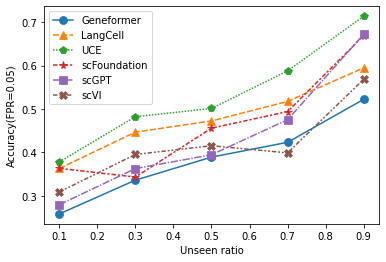

In [104]:
sns.lineplot(x='unseen_ratio', y='mean', data=summary, style='model', hue='model', markers=custom_shape, markersize=8, markeredgecolor=None)
plt.xlabel("Unseen ratio")
plt.ylabel("Accuracy(FPR=0.05)")
ax = plt.gca()
ax.legend(title="")

# add error bar
# palette = sns.color_palette()
# models = summary['model'].unique()
# for i, model in enumerate(models):
#     model_data = summary[summary['model'] == model]
#     plt.errorbar(x=model_data['unseen_ratio'], 
#                  y=model_data['mean'], 
#                  yerr=model_data['std'], 
#                  fmt='none', 
#                  capsize=5, 
#                  ecolor=palette[i], 
#                  elinewidth=2) 
# plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_accuracy_fpr_0.05.png", dpi=300, bbox_inches='tight')

In [ ]:
from matplotlib.ticker import FormatStrFormatter
def plot_violin(ax, x, y, data, hue, order, palette, xlabel, median_value):
    # sns.violinplot(x=x, y=y, data=data, hue=hue, width=0.5, alpha=0.8, ax=ax, order=order, palette=palette)
    sns.boxplot(x=x, y=y, data=data, hue=hue, width=0.5, ax=ax, order=order, palette=palette, 
                flierprops=dict(marker='o', color='black', markersize=2, linestyle='none'))
    ax.axvline(x=median_value, color='r', linestyle=':')
    ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=7)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel(xlabel, fontweight="bold")

def get_model_order(df, column, ascending=False):
    median_values = df.groupby('model')[column].median().sort_values(ascending=ascending)
    return median_values.index.tolist() 

cols = ["Accuracy@1", "Macro F1", "LCAD"]
fig, axes = plt.subplots(1, len(cols), figsize=(2*len(cols)-1, 2.3))

for i, col in enumerate(cols):
    model_order = get_model_order(df_all, col, ascending=True if col=="LCAD" else False)
    plot_violin(axes[i], col, 'model', df_all, 'model', model_order, custom_palette,
                col, df_all[df_all["model"] == "scVI"][col].median())
fig.suptitle("Transfer from Tabula Sapiens to HLCA", fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/tabula_to_hlca.png", dpi=300, bbox_inches='tight')

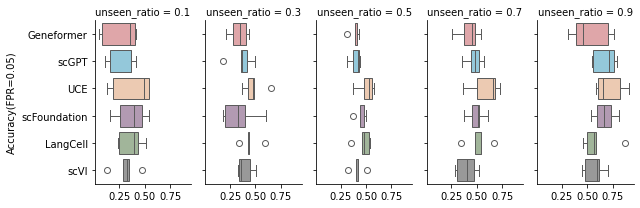

In [185]:
grid = sns.FacetGrid(result_df, col="unseen_ratio", aspect=0.6)
grid.map(sns.boxplot, "Accuracy(FPR=0.05)", "model", data=result_df, hue="model", 
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.05)")
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_accuracy_fpr_0.05.png", dpi=300, bbox_inches='tight')

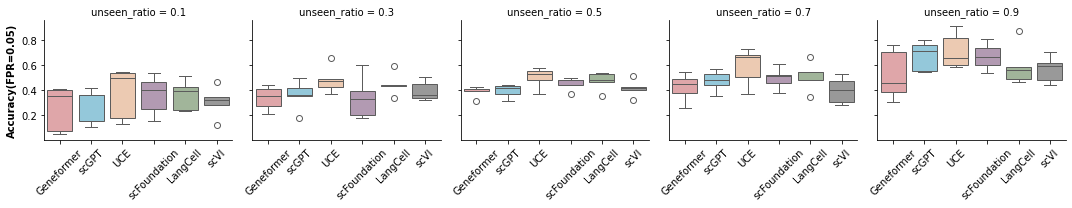

In [23]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.05)", data=result_df, hue="model", 
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.05)", fontweight="bold")
grid.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_accuracy_fpr_0.05.png", dpi=300, bbox_inches='tight')

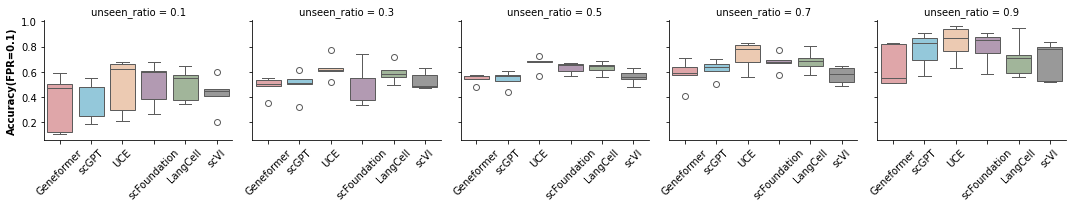

In [24]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.1)", data=result_df, hue="model",
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.1)", fontweight="bold")
grid.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_accuracy_fpr_0.1.png", dpi=300, bbox_inches='tight')

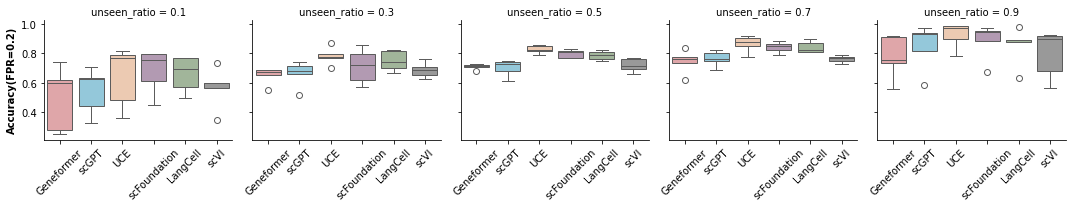

In [25]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.2)", data=result_df, hue="model", 
         palette=custom_palette, order=model_order_wo_hvg)
grid.set_axis_labels('', "Accuracy(FPR=0.2)", fontweight="bold")
grid.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_accuracy_fpr_0.2.png", dpi=300, bbox_inches='tight')

#### OOD detection

In [139]:
result_grouped = result_df.groupby(["model", "unseen_ratio"]).agg("mean").reset_index()
result_grouped

model  unseen_ratio  iter  Accuracy(FPR=0.05)  Accuracy(FPR=0.1)  \
0     Geneformer           0.1   2.0              0.2586             0.3594   
1     Geneformer           0.3   2.0              0.3363             0.4880   
2     Geneformer           0.5   2.0              0.3893             0.5475   
3     Geneformer           0.7   2.0              0.4234             0.5837   
4     Geneformer           0.9   2.0              0.5223             0.6434   
5       LangCell           0.1   2.0              0.3632             0.4984   
6       LangCell           0.3   2.0              0.4468             0.5934   
7       LangCell           0.5   2.0              0.4727             0.6317   
8       LangCell           0.7   2.0              0.5175             0.6834   
9       LangCell           0.9   2.0              0.5948             0.7071   
10           UCE           0.1   2.0              0.3784             0.4949   
11           UCE           0.3   2.0              0.4823             0.6292   
12           UCE           0.5   2.0              0.5014             0.6684   
13           UCE           0.7   2.0              0.5878             0.7320   
14           UCE           0.9   2.0              0.7136             0.8343   
15  scFoundation           0.1   2.0              0.3635             0.5067   
16  scFoundation           0.3   2.0              0.3434             0.5130   
17  scFoundation           0.5   2.0              0.4560             0.6304   
18  scFoundation           0.7   2.0              0.4942             0.6789   
19  scFoundation           0.9   2.0              0.6690             0.7931   
20         scGPT           0.1   2.0              0.2799             0.3901   
21         scGPT           0.3   2.0              0.3629             0.5012   
22         scGPT           0.5   2.0              0.3948             0.5441   
23         scGPT           0.7   2.0              0.4754             0.6204   
24         scGPT           0.9   2.0              0.6717             0.7749   
25          scVI           0.1   2.0              0.3091             0.4238   
26          scVI           0.3   2.0              0.3955             0.5304   
27          scVI           0.5   2.0              0.4156             0.5600   
28          scVI           0.7   2.0              0.3992             0.5726   
29          scVI           0.9   2.0              0.5684             0.6910   

    Accuracy(FPR=0.2)  AUROC(softmax)  AUPRC(softmax)  AUROC(energy)  \
0              0.4969          0.7137          0.8579         0.7366   
1              0.6506          0.7773          0.7164         0.8160   
2              0.7099          0.8028          0.5558         0.8529   
3              0.7445          0.8281          0.3791         0.8601   
4              0.7761          0.8802          0.3597         0.8649   
5              0.6612          0.7742          0.8960         0.8311   
6              0.7487          0.8277          0.7808         0.8712   
7              0.7862          0.8281          0.5867         0.8868   
8              0.8411          0.8721          0.4751         0.9039   
9              0.8528          0.9256          0.3729         0.9081   
10             0.6443          0.7805          0.8907         0.8368   
11             0.7806          0.8276          0.7874         0.8896   
12             0.8285          0.8427          0.6175         0.9073   
13             0.8642          0.8816          0.5345         0.9210   
14             0.9253          0.9464          0.6118         0.9484   
15             0.6815          0.7800          0.8982         0.8404   
16             0.7133          0.8145          0.7526         0.8481   
17             0.7992          0.8403          0.5998         0.8895   
18             0.8437          0.8725          0.4605         0.9014   
19             0.8853          0.9274          0.3707         0.9249   
20             0.5466          0.7342          0.

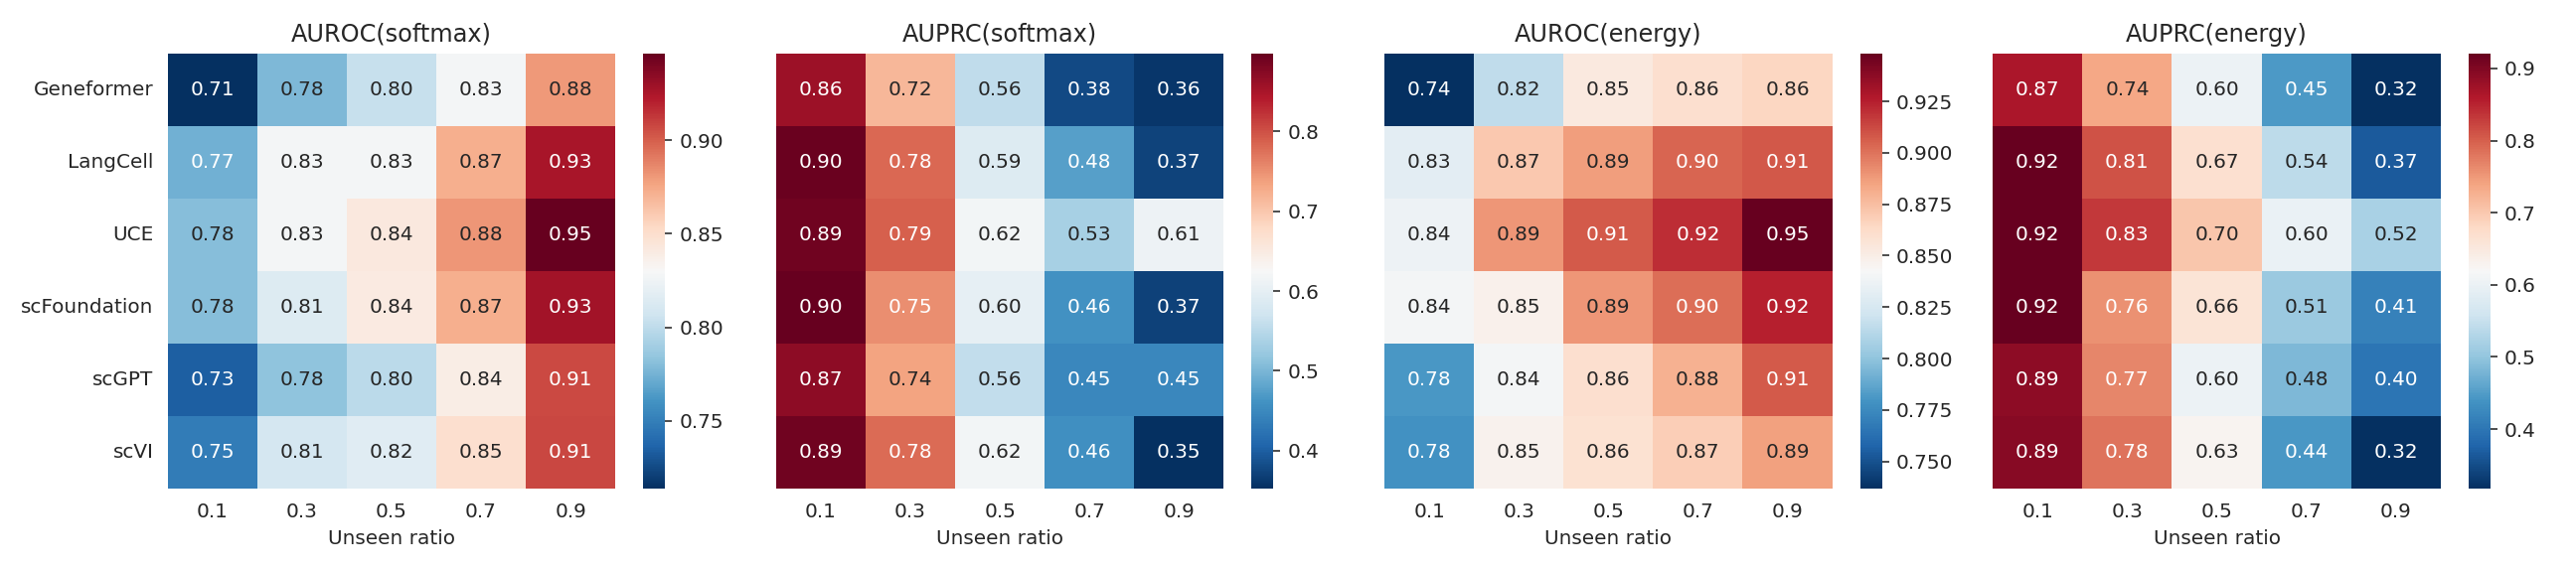

In [140]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharex=True, sharey=False)
for i, col in enumerate(["AUROC(softmax)", "AUPRC(softmax)", "AUROC(energy)", "AUPRC(energy)"]):
    heatmap_df = result_grouped.pivot(index="model", columns="unseen_ratio", values=col)
    sns.heatmap(heatmap_df, annot=True, cmap="RdBu_r", ax=axes[i], fmt='.2f')
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Unseen ratio")
    axes[i].set_title(col)
    if i > 0:
        axes[i].set_yticklabels("")
plt.tight_layout()
plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/novel_cells/tabula_confidence_iid_positive.png", dpi=300, bbox_inches='tight')

## Cross dataset label transfer

### Tabula to HLCA

In [170]:
source_dataset = "Tabula_Sapiens_all"
target_dataset = "HLCA_core"
output_folder = f"../OnClass/results_best_params/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    params = model_to_params[source_dataset][model]
    lr, l2 = float(params["lr"]), float(params["l2"])
    result_path = os.path.join(output_folder, model, "onclass_dot_product", 
                               source_dataset, f"lr_{lr}_l2_{l2}_testset_0.8/all_metrics_transfer_{target_dataset}.csv")
    df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
    df["model"] = model if model != "xTrimoGene" else "scFoundation"
    df_all = pd.concat([df_all, df])
df_all

unseen_ratio  Accuracy@1  Macro F1    LCAD         model
iter                                                          
0.0            0.0      0.6109    0.0842  2.9309          scVI
1.0            0.0      0.6060    0.0764  2.8358          scVI
2.0            0.0      0.6095    0.0807  2.9438          scVI
3.0            0.0      0.6202    0.0825  2.7777          scVI
4.0            0.0      0.6105    0.0801  2.9362          scVI
0.0            0.0      0.6650    0.0898  2.8003    Geneformer
1.0            0.0      0.6714    0.0897  2.4860    Geneformer
2.0            0.0      0.6595    0.0929  2.5097    Geneformer
3.0            0.0      0.6794    0.0776  2.4619    Geneformer
4.0            0.0      0.6495    0.0830  2.5371    Geneformer
0.0            0.0      0.6990    0.0858  2.6242         scGPT
1.0            0.0      0.6610    0.0802  2.4786         scGPT
2.0            0.0      0.6831    0.0860  2.4601         scGPT
3.0            0.0      0.6750    0.0822  2.4356         scGPT
4.0            0.0      0.6516    0.0732  2.3395         scGPT
0.0            0.0      0.6818    0.0954  2.0123           UCE
1.0            0.0      0.6706    0.0844  1.9285           UCE
2.0            0.0      0.6619    0.0846  2.1009           UCE
3.0            0.0      0.6696    0.0969  2.0220           UCE
4.0            0.0      0.6628    0.0833  2.1102           UCE
0.0            0.0      0.6626    0.0849  2.0723  scFoundation
1.0            0.0      0.6852    0.0800  2.1132  scFoundation
2.0            0.0      0.6680    0.0858  2.2866  scFoundation
3.0            0.0      0.6644    0.0806  2.2244  scFoundation
4.0            0.0      0.6793    0.0846  2.1852  scFoundation
0.0            0.0      0.6604    0.0753  2.8289      LangCell
1.0            0.0      0.6376    0.0766  3.1246      LangCell
2.0            0.0      0.6560    0.0805  2.8878      LangCell
3.0            0.0      0.6424    0.0840  2.5871      LangCell
4.0            0.0      0.6679    0.0849  2.5631      LangCell

In [143]:
df_all["LCAD_rank"] = - df_all["LCAD"]
df_grouped = df_all.groupby("model").agg("mean")
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1", "LCAD_rank"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([ 0.66497263,  0.08659671, -2.5589799 ]), 'LangCell': array([ 0.65286571,  0.08026233, -2.79830363]), 'UCE': array([ 0.66933571,  0.08892166, -2.03479574]), 'scFoundation': array([ 0.67190901,  0.08318657, -2.17635071]), 'scGPT': array([ 0.67394331,  0.08148226, -2.46761235]), 'scVI': array([ 0.61143785,  0.08078325, -2.88487515])}
Front 1: ['UCE', 'scFoundation', 'scGPT']
Front 2: ['Geneformer']
Front 3: ['LangCell', 'scVI']


In [144]:
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.66497263, 0.08659671]), 'LangCell': array([0.65286571, 0.08026233]), 'UCE': array([0.66933571, 0.08892166]), 'scFoundation': array([0.67190901, 0.08318657]), 'scGPT': array([0.67394331, 0.08148226]), 'scVI': array([0.61143785, 0.08078325])}
Front 1: ['UCE', 'scFoundation', 'scGPT']
Front 2: ['Geneformer']
Front 3: ['LangCell', 'scVI']


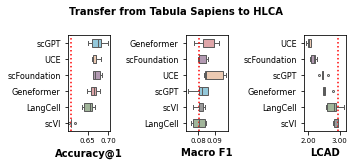

In [171]:
from matplotlib.ticker import FormatStrFormatter
def plot_violin(ax, x, y, data, hue, order, palette, xlabel, median_value):
    # sns.violinplot(x=x, y=y, data=data, hue=hue, width=0.5, alpha=0.8, ax=ax, order=order, palette=palette)
    sns.boxplot(x=x, y=y, data=data, hue=hue, width=0.5, ax=ax, order=order, palette=palette, 
                flierprops=dict(marker='o', color='black', markersize=2, linestyle='none'))
    ax.axvline(x=median_value, color='r', linestyle=':')
    ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=7)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel(xlabel, fontweight="bold")

def get_model_order(df, column, ascending=False):
    median_values = df.groupby('model')[column].median().sort_values(ascending=ascending)
    return median_values.index.tolist() 

cols = ["Accuracy@1", "Macro F1", "LCAD"]
fig, axes = plt.subplots(1, len(cols), figsize=(2*len(cols)-1, 2.3))

for i, col in enumerate(cols):
    model_order = get_model_order(df_all, col, ascending=True if col=="LCAD" else False)
    plot_violin(axes[i], col, 'model', df_all, 'model', model_order, custom_palette,
                col, df_all[df_all["model"] == "scVI"][col].median())
fig.suptitle("Transfer from Tabula Sapiens to HLCA", fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/tabula_to_hlca.png", dpi=300, bbox_inches='tight')

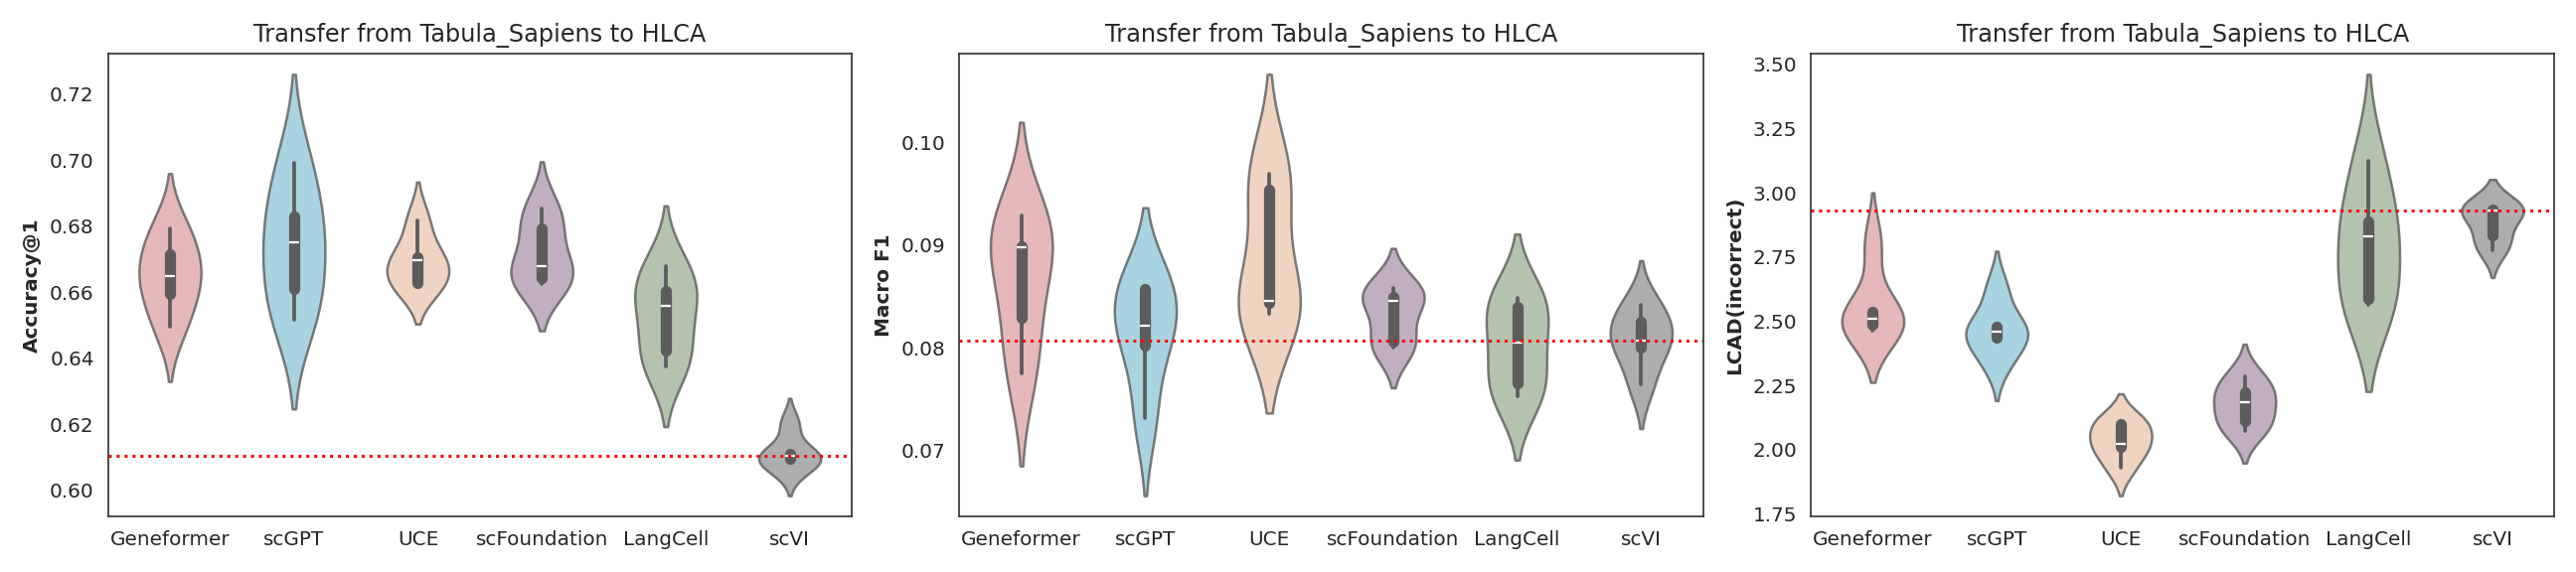

In [146]:
fig, axes = plt.subplots(1,3, figsize=(18,4))

sns.violinplot(df_all, x='model', y='Accuracy@1', hue="model", width=0.5, alpha=0.8, ax=axes[0],
               order=model_order_wo_hvg, palette=custom_palette)
axes[0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0].set_xlabel("")
axes[0].set_ylabel("Accuracy@1", fontweight="bold")
axes[0].set_title("Transfer from Tabula_Sapiens to HLCA")

sns.violinplot(df_all, x='model', y='Macro F1', hue="model", width=0.5, alpha=0.8, ax=axes[1],
               order=model_order_wo_hvg, palette=custom_palette)
axes[1].axhline(y=df_all[df_all["model"]=="scVI"]['Macro F1'].median(), color='r', linestyle=':')
axes[1].set_xlabel("")
axes[1].set_ylabel("Macro F1", fontweight="bold")
axes[1].set_title("Transfer from Tabula_Sapiens to HLCA")


sns.violinplot(df_all, x='model', y='LCAD', hue="model", width=0.5, alpha=0.8, ax=axes[2],
               order=model_order_wo_hvg, palette=custom_palette)
axes[2].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD'].median(), color='r', linestyle=':')
axes[2].set_xlabel("")
axes[2].set_ylabel("LCAD(incorrect)", fontweight="bold")
axes[2].set_title("Transfer from Tabula_Sapiens to HLCA")

plt.tight_layout()
plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/tabula_to_hlca.png", dpi=300, bbox_inches='tight')

### HLCA to Tabula

In [45]:
source_dataset = "HLCA_core"
target_dataset = "Tabula_Sapiens_all"
output_folder = f"../OnClass/results_best_params/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    params = model_to_params[source_dataset][model]
    lr, l2 = float(params["lr"]), float(params["l2"])
    result_path = os.path.join(output_folder, model, "onclass_dot_product", 
                               source_dataset, f"lr_{lr}_l2_{l2}_testset_0.8/all_metrics_transfer_{target_dataset}.csv")
    df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
    df["model"] = model if model != "xTrimoGene" else "scFoundation"
    df_all = pd.concat([df_all, df])
df_all

unseen_ratio  Accuracy@1  Macro F1    LCAD         model
iter                                                          
0.0            0.0      0.7898    0.2542  2.2402          scVI
1.0            0.0      0.7974    0.2595  2.1981          scVI
2.0            0.0      0.7949    0.2571  2.1939          scVI
3.0            0.0      0.7848    0.2503  2.2063          scVI
4.0            0.0      0.7853    0.2569  2.2667          scVI
0.0            0.0      0.7657    0.2299  2.3297    Geneformer
1.0            0.0      0.7767    0.2414  2.3964    Geneformer
2.0            0.0      0.7628    0.2386  2.3580    Geneformer
3.0            0.0      0.7778    0.2416  2.3968    Geneformer
4.0            0.0      0.7784    0.2426  2.3004    Geneformer
0.0            0.0      0.6382    0.2201  2.0641         scGPT
1.0            0.0      0.6081    0.2163  2.1270         scGPT
2.0            0.0      0.6081    0.2016  2.0333         scGPT
3.0            0.0      0.6024    0.2022  1.9702         scGPT
4.0            0.0      0.6148    0.2068  2.0916         scGPT
0.0            0.0      0.8131    0.2802  2.2279           UCE
1.0            0.0      0.8341    0.2777  2.2871           UCE
2.0            0.0      0.8270    0.2849  2.2564           UCE
3.0            0.0      0.8225    0.2846  2.1710           UCE
4.0            0.0      0.8303    0.2860  2.2805           UCE
0.0            0.0      0.7664    0.2570  2.1635  scFoundation
1.0            0.0      0.7857    0.2530  2.1883  scFoundation
2.0            0.0      0.7842    0.2674  2.2342  scFoundation
3.0            0.0      0.7911    0.2652  2.1247  scFoundation
4.0            0.0      0.7826    0.2541  2.1660  scFoundation
0.0            0.0      0.7529    0.2474  2.3134      LangCell
1.0            0.0      0.7628    0.2373  2.1913      LangCell
2.0            0.0      0.7698    0.2547  2.1917      LangCell
3.0            0.0      0.7747    0.2415  2.2306      LangCell
4.0            0.0      0.7680    0.2401  2.1947      LangCell

In [46]:
df_all["LCAD_rank"] = - df_all["LCAD"]
df_grouped = df_all.groupby("model").agg("mean")
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1", "LCAD_rank"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([ 0.7722865 ,  0.23880406, -2.3562378 ]), 'LangCell': array([ 0.76565577,  0.24420721, -2.22432249]), 'UCE': array([ 0.82538845,  0.28266984, -2.24460473]), 'scFoundation': array([ 0.78202853,  0.25932158, -2.1753326 ]), 'scGPT': array([ 0.61433599,  0.20941044, -2.05724713]), 'scVI': array([ 0.79045266,  0.25559449, -2.22104297])}
Front 1: ['UCE', 'scFoundation', 'scGPT', 'scVI']
Front 2: ['Geneformer', 'LangCell']


In [47]:
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.7722865 , 0.23880406]), 'LangCell': array([0.76565577, 0.24420721]), 'UCE': array([0.82538845, 0.28266984]), 'scFoundation': array([0.78202853, 0.25932158]), 'scGPT': array([0.61433599, 0.20941044]), 'scVI': array([0.79045266, 0.25559449])}
Front 1: ['UCE']
Front 2: ['scFoundation', 'scVI']
Front 3: ['Geneformer', 'LangCell']
Front 4: ['scGPT']


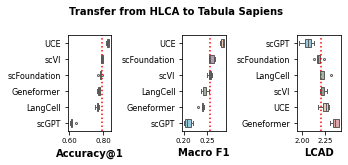

In [48]:
from matplotlib.ticker import FormatStrFormatter
def plot_violin(ax, x, y, data, hue, order, palette, xlabel, median_value):
    # sns.violinplot(x=x, y=y, data=data, hue=hue, width=0.5, alpha=0.8, ax=ax, order=order, palette=palette)
    sns.boxplot(x=x, y=y, data=data, hue=hue, width=0.5, ax=ax, order=order, palette=palette, 
                flierprops=dict(marker='o', color='black', markersize=2, linestyle='none'))
    ax.axvline(x=median_value, color='r', linestyle=':')
    ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=7)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel(xlabel, fontweight="bold")

def get_model_order(df, column, ascending=False):
    median_values = df.groupby('model')[column].median().sort_values(ascending=ascending)
    return median_values.index.tolist() 

cols = ["Accuracy@1", "Macro F1", "LCAD"]
fig, axes = plt.subplots(1, len(cols), figsize=(2*len(cols)-1, 2.3))

for i, col in enumerate(cols):
    model_order = get_model_order(df_all, col, ascending=True if col=="LCAD" else False)
    plot_violin(axes[i], col, 'model', df_all, 'model', model_order, custom_palette,
                col, df_all[df_all["model"] == "scVI"][col].median())
# plt.title("Transfer from HLCA to Tabula_Sapiens")
fig.suptitle("Transfer from HLCA to Tabula Sapiens", fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/hlca_to_tabula.png", dpi=300, bbox_inches='tight')

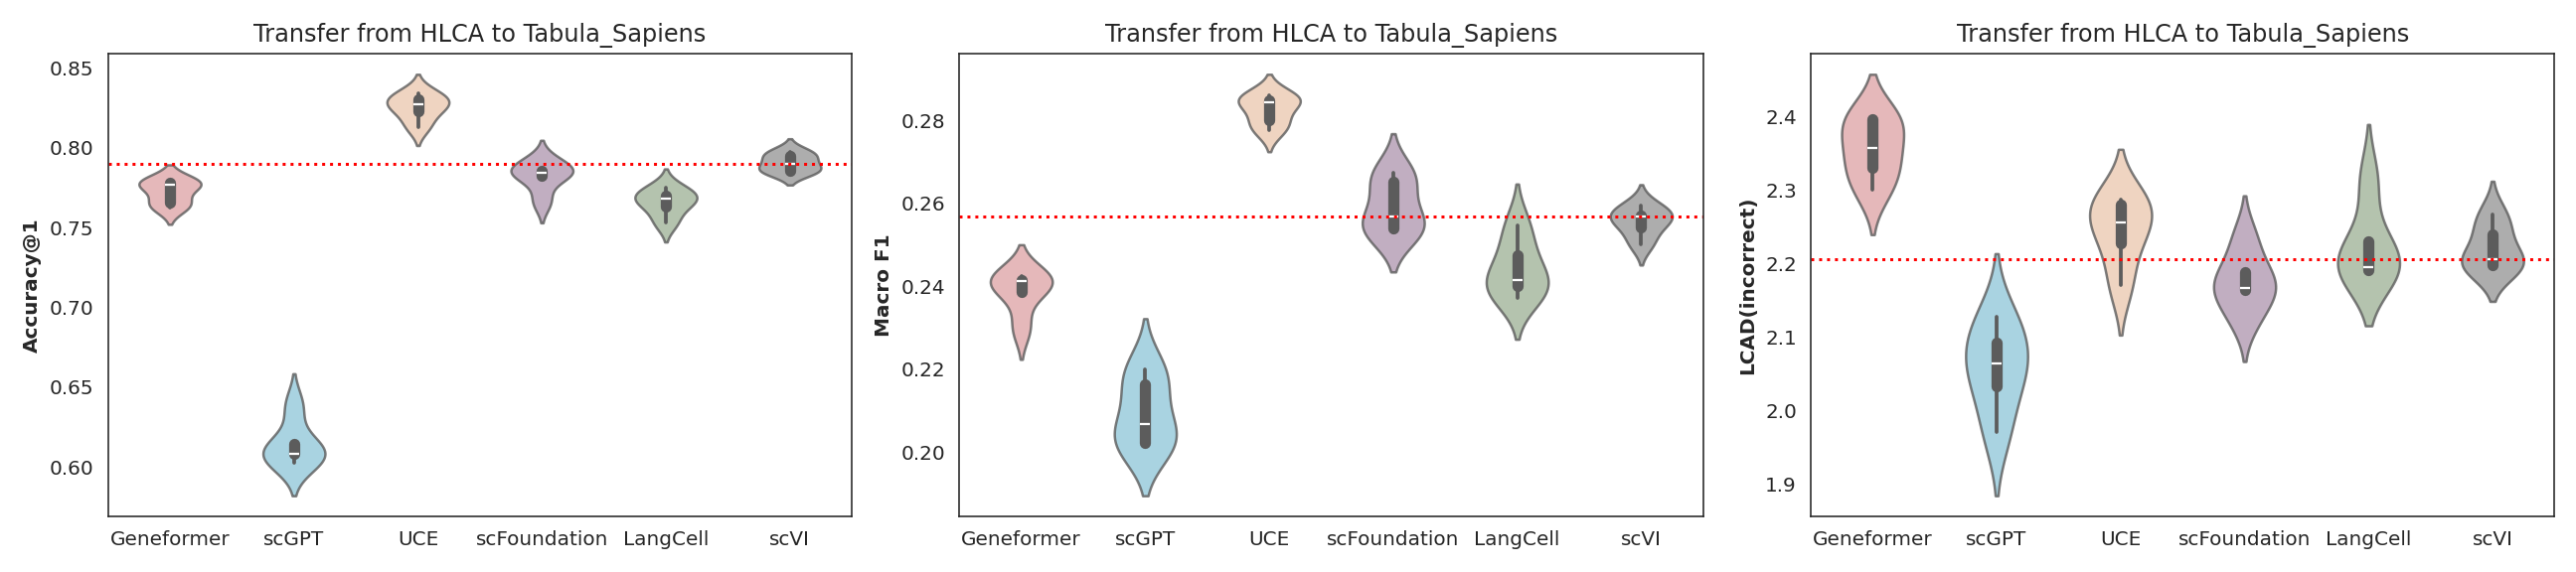

In [151]:
fig, axes = plt.subplots(1,3, figsize=(18,4))

sns.violinplot(df_all, x='model', y='Accuracy@1', hue="model", width=0.5, alpha=0.8, ax=axes[0],
               order=model_order_wo_hvg, palette=custom_palette)
axes[0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0].set_xlabel("")
axes[0].set_ylabel("Accuracy@1", fontweight="bold")
axes[0].set_title("Transfer from HLCA to Tabula_Sapiens")

sns.violinplot(df_all, x='model', y='Macro F1', hue="model", width=0.5, alpha=0.8, ax=axes[1],
               order=model_order_wo_hvg, palette=custom_palette)
axes[1].axhline(y=df_all[df_all["model"]=="scVI"]['Macro F1'].median(), color='r', linestyle=':')
axes[1].set_xlabel("")
axes[1].set_ylabel("Macro F1", fontweight="bold")
axes[1].set_title("Transfer from HLCA to Tabula_Sapiens")


sns.violinplot(df_all, x='model', y='LCAD', hue="model", width=0.5, alpha=0.8, ax=axes[2],
               order=model_order_wo_hvg, palette=custom_palette)
axes[2].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD'].median(), color='r', linestyle=':')
axes[2].set_xlabel("")
axes[2].set_ylabel("LCAD(incorrect)", fontweight="bold")
axes[2].set_title("Transfer from HLCA to Tabula_Sapiens")

plt.tight_layout()
plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/hlca_to_tabula.png", dpi=300, bbox_inches='tight')

#### cell type distribution

In [ ]:
target_labels = {'CL:0000860', 'CL:0002543', 'CL:0000875', 'CL:0000077', 'CL:0002062', 'CL:0000786', 'CL:0000186', 
                'CL:0002138', 'CL:0002063', 'CL:0000097', 'CL:0000158', 'CL:0002399', 'CL:0002144', 'CL:0000037'}
adata = sc.read("../data/datasets/Tabula_Sapiens_all.h5ad")
adata_selected = adata[adata.obs["cell_type_ontology_term_id"].isin(target_labels)]

In [15]:
hlca_adata = sc.read("../data/datasets/HLCA_core.h5ad")
hlca_adata_selected = hlca_adata[hlca_adata.obs["cell_type_ontology_term_id"].isin(target_labels)]

In [16]:
adata_selected.obs["cell_type_ontology_term_id"].value_counts()

cell_type_ontology_term_id
CL:0000860    13387
CL:0000786    11545
CL:0002063     9146
CL:0002144     5089
CL:0002543     3379
CL:0000186     3070
CL:0000097     2238
CL:0000158     2116
CL:0002138     1052
CL:0000875     1044
CL:0000037      794
CL:0002399      306
CL:0002062      211
CL:0000077       41
Name: count, dtype: int64

In [ ]:
hlca_adata_selected.obs["cell_type_ontology_term_id"].value_counts()

cell_type_ontology_term_id
CL:0002063    62405
CL:0000158    36023
CL:0002144    23205
CL:0000860    17695
CL:0002543    12975
CL:0002399     9133
CL:0000875     8834
CL:0002062     7937
CL:0000097     6623
CL:0002138     4595
CL:0000786     1773
CL:0000186      716
CL:0000077      230
CL:0000037       60
Name: count, dtype: int64

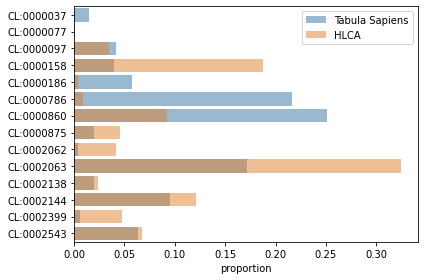

In [26]:
sns.barplot(adata_selected.obs["cell_type_ontology_term_id"].value_counts(normalize=True), alpha=0.5, orient="h", label="Tabula Sapiens")
sns.barplot(hlca_adata_selected.obs["cell_type_ontology_term_id"].value_counts(normalize=True), alpha=0.5, orient="h", label="HLCA")
plt.legend()
plt.ylabel("")
plt.tight_layout()
plt.savefig("../figures/cell_annotation/overlap_category_distribution.png",dpi=300, bbox_inches='tight')

#### Tissue-specific performance

In [8]:
target_labels = {'CL:0000860', 'CL:0002543', 'CL:0000875', 'CL:0000077', 'CL:0002062', 'CL:0000786', 'CL:0000186', 
                'CL:0002138', 'CL:0002063', 'CL:0000097', 'CL:0000158', 'CL:0002399', 'CL:0002144', 'CL:0000037'}
# read adata
adata = sc.read("../data/datasets/Tabula_Sapiens_all.h5ad")

# select the subset with the target labels
adata_selected = adata[adata.obs["cell_type_ontology_term_id"].isin(target_labels)]

# report the tissue-specific accuracy
tissue = adata_selected.obs["tissue_in_publication"].to_list()

In [ ]:
value_counts = adata_selected.obs["tissue_in_publication"].value_counts().reset_index()
fig = px.pie(
    value_counts,
    names="tissue_in_publication",
    values="count"
)

In [47]:
fig.show()

In [11]:
source_dataset = "HLCA_core"
target_dataset = "Tabula_Sapiens_all"
output_folder = f"../OnClass/results_best_params/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    df_model = pd.DataFrame()
    params = model_to_params[source_dataset][model]
    lr, l2 = float(params["lr"]), float(params["l2"])
    for iter in range(5):
        result_path = os.path.join(output_folder, model, "onclass_dot_product", 
                                   source_dataset, f"lr_{lr}_l2_{l2}_testset_0.8/{iter}/0/{target_dataset}/pred_label.csv")
        df = pd.read_csv(result_path)
        df["tissue"] = tissue
        df["iter"] = iter
        df_model = pd.concat([df_model, df], axis=0)
    accuracy_per_tissue = df_model.groupby(['tissue', 'iter']).apply(lambda x: (x['y_true'] == x['y_pred']).mean())
    accuracy_per_tissue = accuracy_per_tissue.groupby(['tissue']).agg("mean").reset_index().rename(columns={0: 'Accuracy'})
    accuracy_per_tissue["model"] = model if model != "xTrimoGene" else "scFoundation"
    df_all = pd.concat([df_all, accuracy_per_tissue], axis=0)
df_all

tissue  Accuracy     model
0       Bladder  0.517811      scVI
1         Blood  0.970966      scVI
2   Bone_Marrow  0.797781      scVI
3           Eye  0.937255      scVI
4           Fat  0.027668      scVI
..          ...       ...       ...
17       Thymus  0.775536  LangCell
18       Tongue  0.704043  LangCell
19      Trachea  0.958454  LangCell
20       Uterus  0.244186  LangCell
21  Vasculature  0.968586  LangCell

[132 rows x 3 columns]

In [12]:
df_all = df_all.reset_index(drop=True)
df_max_acc = df_all.loc[df_all.groupby('tissue')['Accuracy'].idxmax()].reset_index(drop=True)
df_max_acc.model.value_counts()

model
UCE             12
scVI             4
scFoundation     3
scGPT            2
Geneformer       1
Name: count, dtype: int64

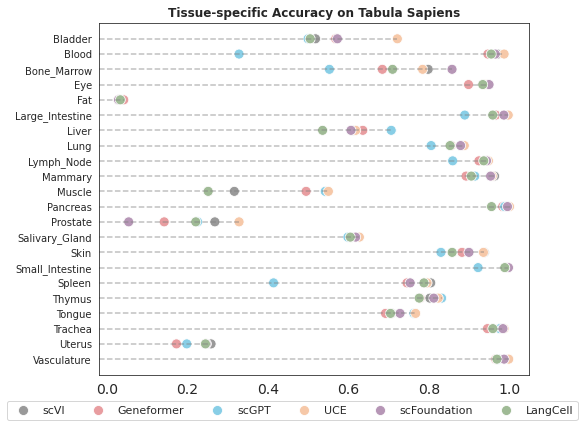

In [32]:
sns.set_style('white')
plt.figure(figsize=(8,6))
# pal = sns.color_palette("husl", 6)  
scatter = sns.scatterplot(df_all, y="tissue", x="Accuracy", hue="model", s=100, palette=custom_palette)
yticklabels = scatter.get_yticklabels()
max_values = df_all.groupby('tissue')['Accuracy'].max()
xlim = scatter.get_xlim()
ax = plt.gca()
for i, label in enumerate(scatter.get_yticklabels()):
    dataset = label.get_text()
    ax.axhline(y=i, xmin=0, xmax=(max_values[dataset] - xlim[0])/(xlim[1] - xlim[0]), color='gray', linestyle='--', alpha=0.5)
    # print(dataset, max_values[dataset])

# plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
plt.legend(ncol=6, loc="center", bbox_to_anchor=(.45,-0.1), fontsize=11)
plt.xticks(fontsize=14)
plt.title("Tissue-specific Accuracy on Tabula Sapiens", fontweight="bold", fontsize=12)
plt.tight_layout()
plt.savefig("../figures/cell_annotation/best_params_scVI_with_batchkey/hlca_to_tabula_tissue_acc.png", dpi=300, bbox_inches='tight')

## Model complementary

1. Dataset: Tabula_Sapiens_all
2. Setting: 20% training, 80% test, unseen_ratio=0
3. Plot: Heatmaps representing performance of pairwise model combinations in terms of Accuracy@1 or Macro F1

### Tabula to HLCA

In [20]:
source_dataset = "Tabula_Sapiens_all"
target_dataset = "HLCA_core"
combinations = pd.read_csv(f"../figures/model_complement_transfer_{source_dataset}_to_{target_dataset}.csv")
combinations.head()

iter      model1        model2  Accuracy@1  Macro F1
0     0  Geneformer         scGPT    0.739735  0.121073
1     0  Geneformer           UCE    0.718731  0.119384
2     0  Geneformer      LangCell    0.712160  0.101890
3     0  Geneformer  scFoundation    0.700927  0.117296
4     0       scGPT           UCE    0.738382  0.135777

In [21]:
output_folder = f"../OnClass/results_best_params/"
single_model_result = []
single_model_acc = defaultdict(list)
single_model_f1 = defaultdict(list)
for model in ["Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
	params = model_to_params[source_dataset][model]
	lr, l2 = float(params["lr"]), float(params["l2"])
	result_path = os.path.join(output_folder, model, "onclass_dot_product", 
								source_dataset, f"lr_{lr}_l2_{l2}_testset_0.8/all_metrics_transfer_{target_dataset}.csv")
	df = pd.read_csv(result_path)
	model = model if model != "xTrimoGene" else "scFoundation"
	for iter in range(5):
		single_model_result.append(
			{
				"iter": iter,
				"model1": model,
				"model2": model,
				"Accuracy@1": df["Accuracy@1"].values[iter],
				"Macro F1": df["Macro F1"].values[iter],
			}
		)
		single_model_acc[model].append(df["Accuracy@1"].values[iter])
		single_model_f1[model].append(df["Macro F1"].values[iter])
single_model_result = pd.DataFrame.from_dict(single_model_result)

In [22]:
result = pd.concat([combinations, single_model_result],axis=0)
result_grouped = result.groupby(["model1", "model2"]).agg("mean").reset_index()
result_grouped

model1        model2  iter  Accuracy@1  Macro F1
0     Geneformer    Geneformer   2.0    0.664973  0.086597
1     Geneformer      LangCell   2.0    0.713289  0.111455
2     Geneformer           UCE   2.0    0.714510  0.116603
3     Geneformer  scFoundation   2.0    0.706409  0.116749
4     Geneformer         scGPT   2.0    0.737971  0.114872
5       LangCell      LangCell   2.0    0.652866  0.080262
6       LangCell  scFoundation   2.0    0.707931  0.111494
7            UCE      LangCell   2.0    0.713011  0.110840
8            UCE           UCE   2.0    0.669336  0.088922
9            UCE  scFoundation   2.0    0.703438  0.112137
10  scFoundation  scFoundation   2.0    0.671909  0.083187
11         scGPT      LangCell   2.0    0.719170  0.111603
12         scGPT           UCE   2.0    0.725341  0.117833
13         scGPT  scFoundation   2.0    0.718377  0.111817
14         scGPT         scGPT   2.0    0.673943  0.081482

In [23]:
result_grouped["acc_improve"] = result_grouped.apply(lambda x: x["Accuracy@1"]-max(np.mean(single_model_acc[x["model1"]]), np.mean(single_model_acc[x["model2"]])), axis=1)
result_grouped["f1_improve"] = result_grouped.apply(lambda x: x["Macro F1"]-max(np.mean(single_model_f1[x["model1"]]), np.mean(single_model_f1[x["model2"]])), axis=1)
result_grouped

model1        model2  iter  Accuracy@1  Macro F1   acc_improve  \
0     Geneformer    Geneformer   2.0    0.664973  0.086597  0.000000e+00   
1     Geneformer      LangCell   2.0    0.713289  0.111455  4.831637e-02   
2     Geneformer           UCE   2.0    0.714510  0.116603  4.517388e-02   
3     Geneformer  scFoundation   2.0    0.706409  0.116749  3.449980e-02   
4     Geneformer         scGPT   2.0    0.737971  0.114872  6.402780e-02   
5       LangCell      LangCell   2.0    0.652866  0.080262  0.000000e+00   
6       LangCell  scFoundation   2.0    0.707931  0.111494  3.602214e-02   
7            UCE      LangCell   2.0    0.713011  0.110840  4.367547e-02   
8            UCE           UCE   2.0    0.669336  0.088922  0.000000e+00   
9            UCE  scFoundation   2.0    0.703438  0.112137  3.152900e-02   
10  scFoundation  scFoundation   2.0    0.671909  0.083187  0.000000e+00   
11         scGPT      LangCell   2.0    0.719170  0.111603  4.522695e-02   
12         scGPT           UCE   2.0    0.725341  0.117833  5.139747e-02   
13         scGPT  scFoundation   2.0    0.718377  0.111817  4.443404e-02   
14         scGPT         scGPT   2.0    0.673943  0.081482  1.110223e-16   

      f1_improve  
0   0.000000e+00  
1   2.485789e-02  
2   2.768129e-02  
3   3.015218e-02  
4   2.827528e-02  
5   0.000000e+00  
6   2.830712e-02  
7   2.191847e-02  
8   0.000000e+00  
9   2.321552e-02  
10  1.387779e-17  
11  3.012038e-02  
12  2.891155e-02  
13  2.862993e-02  
14  0.000000e+00

In [24]:
heatmap_df = result_grouped.pivot(index="model1", columns="model2", values="Accuracy@1")
for i, row in enumerate(heatmap_df.index):
    for j, col in enumerate(heatmap_df.columns):
        if i < j:  
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["Accuracy@1"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["Accuracy@1"].values[0]
        elif i > j:
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["acc_improve"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["acc_improve"].values[0]
        else:
            heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==row)]["Accuracy@1"].values[0]
heatmap_df = heatmap_df.astype(float)
heatmap_df

model2        Geneformer  LangCell       UCE  scFoundation     scGPT
model1                                                              
Geneformer      0.664973  0.713289  0.714510      0.706409  0.737971
LangCell        0.048316  0.652866  0.713011      0.707931  0.719170
UCE             0.045174  0.043675  0.669336      0.703438  0.725341
scFoundation    0.034500  0.036022  0.031529      0.671909  0.718377
scGPT           0.064028  0.045227  0.051397      0.044434  0.673943

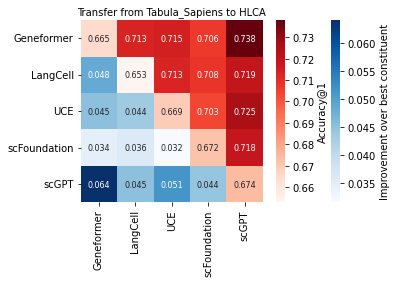

In [25]:
data = heatmap_df.values
mask_upper = np.triu(np.ones_like(data, dtype=bool))
mask_lower = np.tril(np.ones_like(data, dtype=bool),k=-1)

ax1 = sns.heatmap(data, mask=mask_upper, cmap='Blues', annot=True, annot_kws={"fontsize": 8}, fmt=".3f", 
            cbar_kws={'label': "Improvement over best constituent"}, square=True)
ax2 = sns.heatmap(data, mask=mask_lower, cmap='Reds', annot=True, annot_kws={"fontsize": 8}, fmt=".3f", 
                  xticklabels=heatmap_df.index, yticklabels=heatmap_df.index,
                  cbar_kws={'label': "Accuracy@1"}, square=True)
plt.title("Transfer from Tabula_Sapiens to HLCA", fontsize=10)
plt.tight_layout()
plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/tabula_to_hlca_complement.png", dpi=300, bbox_inches='tight')

### HLCA to Tabula

In [26]:
source_dataset = "HLCA_core"
target_dataset = "Tabula_Sapiens_all"
combinations = pd.read_csv(f"../figures/model_complement_transfer_{source_dataset}_to_{target_dataset}.csv")
combinations.head()

iter      model1        model2  Accuracy@1  Macro F1
0     0  Geneformer         scGPT    0.769067  0.244215
1     0  Geneformer           UCE    0.808754  0.267021
2     0  Geneformer      LangCell    0.776105  0.245716
3     0  Geneformer  scFoundation    0.786383  0.252900
4     0       scGPT           UCE    0.800348  0.266207

In [27]:
output_folder = f"../OnClass/results_best_params/"
single_model_result = []
single_model_acc = defaultdict(list)
single_model_f1 = defaultdict(list)
for model in ["Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
	params = model_to_params[source_dataset][model]
	lr, l2 = float(params["lr"]), float(params["l2"])
	result_path = os.path.join(output_folder, model, "onclass_dot_product", source_dataset, f"lr_{lr}_l2_{l2}_testset_0.8/all_metrics_transfer_{target_dataset}.csv")
	df = pd.read_csv(result_path)
	model = model if model != "xTrimoGene" else "scFoundation"
	for iter in range(5):
		single_model_result.append(
			{
				"iter": iter,
				"model1": model,
				"model2": model,
				"Accuracy@1": df["Accuracy@1"].values[iter],
				"Macro F1": df["Macro F1"].values[iter],
			}
		)
		single_model_acc[model].append(df["Accuracy@1"].values[iter])
		single_model_f1[model].append(df["Macro F1"].values[iter])
single_model_result = pd.DataFrame.from_dict(single_model_result)

In [28]:
result = pd.concat([combinations, single_model_result],axis=0)
result_grouped = result.groupby(["model1", "model2"]).agg("mean").reset_index()
result_grouped

model1        model2  iter  Accuracy@1  Macro F1
0     Geneformer    Geneformer   2.0    0.772286  0.238804
1     Geneformer      LangCell   2.0    0.785589  0.251869
2     Geneformer           UCE   2.0    0.820109  0.274316
3     Geneformer  scFoundation   2.0    0.796855  0.261226
4     Geneformer         scGPT   2.0    0.768685  0.252435
5       LangCell      LangCell   2.0    0.765656  0.244207
6       LangCell  scFoundation   2.0    0.790352  0.265613
7            UCE      LangCell   2.0    0.808001  0.275112
8            UCE           UCE   2.0    0.825388  0.282670
9            UCE  scFoundation   2.0    0.808888  0.274636
10  scFoundation  scFoundation   2.0    0.782029  0.259322
11         scGPT      LangCell   2.0    0.768707  0.252781
12         scGPT           UCE   2.0    0.802224  0.270016
13         scGPT  scFoundation   2.0    0.774859  0.260764
14         scGPT         scGPT   2.0    0.614336  0.209410

In [29]:
result_grouped["acc_improve"] = result_grouped.apply(lambda x: x["Accuracy@1"]-max(np.mean(single_model_acc[x["model1"]]), np.mean(single_model_acc[x["model2"]])), axis=1)
result_grouped["f1_improve"] = result_grouped.apply(lambda x: x["Macro F1"]-max(np.mean(single_model_f1[x["model1"]]), np.mean(single_model_f1[x["model2"]])), axis=1)
result_grouped

model1        model2  iter  Accuracy@1  Macro F1   acc_improve  \
0     Geneformer    Geneformer   2.0    0.772286  0.238804  0.000000e+00   
1     Geneformer      LangCell   2.0    0.785589  0.251869  1.330263e-02   
2     Geneformer           UCE   2.0    0.820109  0.274316 -5.279119e-03   
3     Geneformer  scFoundation   2.0    0.796855  0.261226  1.482646e-02   
4     Geneformer         scGPT   2.0    0.768685  0.252435 -3.601782e-03   
5       LangCell      LangCell   2.0    0.765656  0.244207  0.000000e+00   
6       LangCell  scFoundation   2.0    0.790352  0.265613  8.323037e-03   
7            UCE      LangCell   2.0    0.808001  0.275112 -1.738740e-02   
8            UCE           UCE   2.0    0.825388  0.282670 -2.220446e-16   
9            UCE  scFoundation   2.0    0.808888  0.274636 -1.650006e-02   
10  scFoundation  scFoundation   2.0    0.782029  0.259322  0.000000e+00   
11         scGPT      LangCell   2.0    0.768707  0.252781  3.051406e-03   
12         scGPT           UCE   2.0    0.802224  0.270016 -2.316448e-02   
13         scGPT  scFoundation   2.0    0.774859  0.260764 -7.169868e-03   
14         scGPT         scGPT   2.0    0.614336  0.209410  0.000000e+00   

      f1_improve  
0   0.000000e+00  
1   7.662081e-03  
2  -8.354108e-03  
3   1.904783e-03  
4   1.363046e-02  
5  -5.551115e-17  
6   6.291671e-03  
7  -7.558234e-03  
8   0.000000e+00  
9  -8.034318e-03  
10 -5.551115e-17  
11  8.573305e-03  
12 -1.265370e-02  
13  1.441972e-03  
14  0.000000e+00

In [30]:
heatmap_df = result_grouped.pivot(index="model1", columns="model2", values="Accuracy@1")
for i, row in enumerate(heatmap_df.index):
    for j, col in enumerate(heatmap_df.columns):
        if i < j:  
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["Accuracy@1"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["Accuracy@1"].values[0]
        elif i > j:
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["acc_improve"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["acc_improve"].values[0]
        else:
            heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==row)]["Accuracy@1"].values[0]
heatmap_df = heatmap_df.astype(float)
heatmap_df

model2        Geneformer  LangCell       UCE  scFoundation     scGPT
model1                                                              
Geneformer      0.772286  0.785589  0.820109      0.796855  0.768685
LangCell        0.013303  0.765656  0.808001      0.790352  0.768707
UCE            -0.005279 -0.017387  0.825388      0.808888  0.802224
scFoundation    0.014826  0.008323 -0.016500      0.782029  0.774859
scGPT          -0.003602  0.003051 -0.023164     -0.007170  0.614336

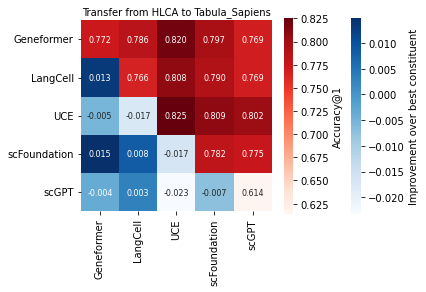

In [31]:
data = heatmap_df.values
mask_upper = np.triu(np.ones_like(data, dtype=bool))
mask_lower = np.tril(np.ones_like(data, dtype=bool),k=-1)

ax1 = sns.heatmap(data, mask=mask_upper, cmap='Blues', annot=True, annot_kws={"fontsize": 8}, fmt=".3f", 
            cbar_kws={'label': "Improvement over best constituent", "pad":0.1}, square=True)
ax2 = sns.heatmap(data, mask=mask_lower, cmap='Reds', annot=True, annot_kws={"fontsize": 8}, fmt=".3f", 
                  xticklabels=heatmap_df.index, yticklabels=heatmap_df.index,
                  cbar_kws={'label': "Accuracy@1"}, square=True)
plt.title("Transfer from HLCA to Tabula_Sapiens", fontsize=10)
plt.tight_layout()
plt.savefig("figures/cell_annotation/best_params_scVI_with_batchkey/hlca_to_tabula_complement.png", dpi=300, bbox_inches='tight')

# CancerFinder (leave-one-tissue-out)

## AUROC/AURPC

In [129]:
model_list = ["X", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
tissue_list = ["Blood", "Brain", "Bone", "Eye"]

scVI_model_list = ["scVI_integrated_Patient", "scVI_integrated_dataset", 
                   "scVI_integrated_tumor", "scVI_integrated_tissue"]

### Compare scVI with different batch_key (default parameters)

In [11]:
result_dir = "../SequencingCancerFinder/optuna_results"
df_all = pd.DataFrame()
for tissue in tissue_list:
    df = pd.DataFrame()
    auroc_ls, auprc_ls = [], []
    batchkey_ls = []
    for model in scVI_model_list:
        optuna_results = pd.read_csv(os.path.join(result_dir, model, "optuna_all_trials.csv"))
        bs, dropout, lr, decay = optuna_results.loc[optuna_results["value"].idxmax(), :][1:]
        with open(os.path.join(result_dir, model, f"bs_{int(bs)}_lr_{lr}_drop_{dropout:.2f}_decay_{decay}", tissue, "train_log_val.txt")) as f:
            res = f.readlines()[-2:]
            auroc, auprc = res[0].strip().split(": ")[1], res[1].strip().split(": ")[1]
            auroc_ls.append(float(auroc))
            auprc_ls.append(float(auprc))
            batchkey_ls.append(model.split("_")[-1])
    df["Batch_key"] = batchkey_ls
    df["AUROC"] = auroc_ls
    df["AUPRC"] = auprc_ls
    df["Tissue"] = tissue
    df_all = pd.concat([df_all, df], axis=0)
df_all

Batch_key   AUROC   AUPRC Tissue
0   Patient  0.7335  0.6256  Blood
1   dataset  0.7258  0.6557  Blood
2     tumor  0.7060  0.6347  Blood
3    tissue  0.7623  0.6918  Blood
0   Patient  0.7633  0.8951  Brain
1   dataset  0.7883  0.8836  Brain
2     tumor  0.6718  0.8583  Brain
3    tissue  0.7370  0.8981  Brain
0   Patient  0.7078  0.8071   Bone
1   dataset  0.7758  0.8624   Bone
2     tumor  0.6522  0.7596   Bone
3    tissue  0.7824  0.8618   Bone
0   Patient  0.9687  0.9887    Eye
1   dataset  0.9645  0.9875    Eye
2     tumor  0.9636  0.9868    Eye
3    tissue  0.9632  0.9873    Eye

In [47]:
# the best batch key on average is "tissue"
df_all.groupby(["Batch_key"])[["AUROC", "AUPRC"]].agg("mean")

AUROC     AUPRC
Batch_key                    
Patient    0.793325  0.829125
dataset    0.813600  0.847300
tissue     0.811225  0.859750
tumor      0.748400  0.809850

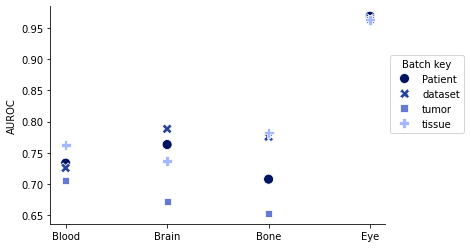

In [51]:
colors = ["#001360", "#28439c", "#647ad4", "#a5b7ff"]
sns.scatterplot(df_all, x="Tissue", y="AUROC", style="Batch_key", hue="Batch_key", s=100, 
                palette=colors)
# sns.stripplot(df_all, x="Tissue", y="AUROC", hue="Batch_key", s=10, 
#               palette="Blues")   
sns.despine(top=True, right=True, left=False, bottom=False)
ax = plt.gca()
ax.legend(loc="upper left", ncol=1, frameon=True, bbox_to_anchor=(1, 0.8), title="Batch key")
plt.xlabel("")
plt.savefig("../figures/cancer_finder/scvi_batchkey_auroc.png", dpi=300, bbox_inches='tight')

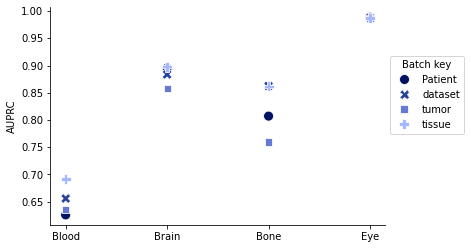

In [52]:
colors = ["#001360", "#28439c", "#647ad4", "#a5b7ff"]
sns.scatterplot(df_all, x="Tissue", y="AUPRC", style="Batch_key", hue="Batch_key", s=100, 
                palette=colors)
sns.despine(top=True, right=True, left=False, bottom=False)
ax = plt.gca()
ax.legend(loc="upper left", ncol=1, frameon=True, bbox_to_anchor=(1, 0.8), title="Batch key")
plt.xlabel("")
plt.savefig("../figures/cancer_finder/scvi_batchkey_auprc.png", dpi=300, bbox_inches='tight')

### Plot relative improvement to raw counts

In [53]:
# load optimized results
result_dir = "../SequencingCancerFinder/optuna_results"
df_all = pd.DataFrame()
model_list = ["X", "scVI_integrated_tissue", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
for tissue in tissue_list:
    df = pd.DataFrame()
    auroc_ls, auprc_ls = [], []
    model_ls = []
    for model in model_list:
        optuna_results = pd.read_csv(os.path.join(result_dir, model, "optuna_all_trials.csv"))
        bs, dropout, lr, decay = optuna_results.loc[optuna_results["value"].idxmax(), :][1:]
        with open(os.path.join(result_dir, model, f"bs_{int(bs)}_lr_{lr}_drop_{dropout:.2f}_decay_{decay}", tissue, "train_log_val.txt")) as f:
            res = f.readlines()[-2:]
            auroc, auprc = res[0].strip().split(": ")[1], res[1].strip().split(": ")[1]
            if model == "X":  
                auroc_base, auprc_base = float(auroc), float(auprc)
            else:
                auroc_ls.append(float(auroc)-auroc_base)
                auprc_ls.append(float(auprc)-auprc_base)
                model_ls.append(model_map_dict.get(model, model))
    df["Model"] = model_ls
    df["AUROC"] = auroc_ls
    df["AUPRC"] = auprc_ls
    df["Tissue"] = tissue
    df_all = pd.concat([df_all, df], axis=0)
df_all

Model   AUROC   AUPRC Tissue
0          scVI  0.1681  0.1899  Blood
1    Geneformer  0.0925  0.0599  Blood
2         scGPT  0.2069  0.2290  Blood
3           UCE  0.1525  0.1444  Blood
4  scFoundation  0.0011 -0.0352  Blood
5      LangCell  0.1021  0.0892  Blood
0          scVI -0.1209 -0.0565  Brain
1    Geneformer -0.1027 -0.0416  Brain
2         scGPT -0.1206 -0.0685  Brain
3           UCE  0.0659  0.0247  Brain
4  scFoundation  0.0365  0.0166  Brain
5      LangCell -0.0489 -0.0157  Brain
0          scVI  0.2151  0.1742   Bone
1    Geneformer  0.0511  0.0510   Bone
2         scGPT  0.2122  0.1724   Bone
3           UCE  0.0838  0.0600   Bone
4  scFoundation  0.1416  0.0907   Bone
5      LangCell  0.0752  0.0611   Bone
0          scVI  0.0165  0.0088    Eye
1    Geneformer -0.0464 -0.0244    Eye
2         scGPT  0.0307  0.0132    Eye
3           UCE  0.0232  0.0070    Eye
4  scFoundation  0.0190  0.0034    Eye
5      LangCell -0.0535 -0.0283    Eye

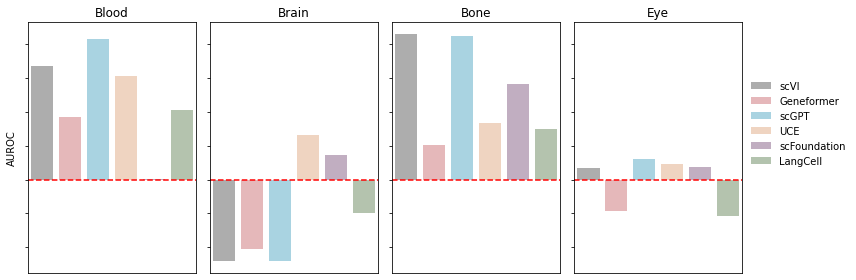

In [64]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=False, sharey=True)
for i, tissue in enumerate(tissue_list):
    df = df_all[df_all["Tissue"]==tissue]
    if i == len(tissue_list) - 1: 
        sns.barplot(data=df, x="Model", y="AUROC", hue="Model", ax=axes[i], 
                    alpha=0.8, palette=custom_palette, legend="brief")
    else:
        sns.barplot(data=df, x="Model", y="AUROC", hue="Model", ax=axes[i], 
                    alpha=0.8, palette=custom_palette)
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].set_xlabel("")
    axes[i].set_xticklabels([])
    axes[i].tick_params(axis='x', which='both', length=0)
    axes[i].set_title(tissue)
    axes[i].axhline(y=0, color='red', ls="--")
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 0.8), ncol=1, title=None, frameon=False, fontsize=10)
plt.tight_layout()
# plt.savefig("../figures/cancer_finder/auroc_all.png", dpi=300, bbox_inches='tight')

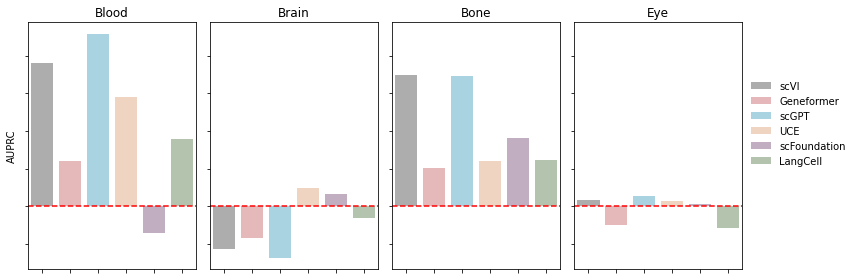

In [65]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=False, sharey=False)
for i, tissue in enumerate(tissue_list):
    df = df_all[df_all["Tissue"]==tissue]
    if i == len(tissue_list) - 1: 
        sns.barplot(data=df, x="AUPRC", y="Model", hue="Model", ax=axes[i], 
                    alpha=0.8, palette=custom_palette, legend="brief", orient="h")
    else:
        sns.barplot(data=df, x="AUPRC", y="Model", hue="Model", ax=axes[i], 
                    alpha=0.8, palette=custom_palette, orient="h")
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].set_ylabel("")
    axes[i].set_title(tissue)
    # axes[i].set_xlim(-0.25,0.25)
    axes[i].axvline(x=0, color='red', ls="--")
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 0.8), ncol=1, title=None, frameon=False, fontsize=10)
# plt.savefig("../figures/cancer_finder/auprc_all.png", dpi=300, bbox_inches='tight')

### Absolute metrics

In [15]:
# load optimized results
result_dir = "../SequencingCancerFinder/optuna_results"
df_all = pd.DataFrame()
model_list = ["X", "scVI_integrated_tissue", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
for t_id, tissue in enumerate(tissue_list):
    df = pd.DataFrame()
    auroc_ls, auprc_ls = [], []
    model_ls = []
    for model in model_list:
        optuna_results = pd.read_csv(os.path.join(result_dir, model, "optuna_all_trials.csv"))
        bs, dropout, lr, decay = optuna_results.loc[optuna_results["value"].idxmax(), :][1:]
        if t_id == 0:
            print(f"Best params for model {model}:", bs, dropout, lr, decay)
        with open(os.path.join(result_dir, model, f"bs_{int(bs)}_lr_{lr}_drop_{dropout:.2f}_decay_{decay}", tissue, "train_log_val.txt")) as f:
            res = f.readlines()[-2:]
            auroc, auprc = res[0].strip().split(": ")[1], res[1].strip().split(": ")[1]
            auroc_ls.append(float(auroc))
            auprc_ls.append(float(auprc))
            model_ls.append(model_map_dict.get(model, model))
    df["Model"] = model_ls
    df["AUROC"] = auroc_ls
    df["AUPRC"] = auprc_ls
    df["Tissue"] = tissue
    df_all = pd.concat([df_all, df], axis=0)
df_all = df_all.reset_index(drop=True)
df_all

Best params for model X: 256.0 0.25 0.005 1e-06
Best params for model scVI_integrated_tissue: 128.0 0.1 0.005 1e-05
Best params for model Geneformer: 128.0 0.1 0.005 1e-05
Best params for model scGPT: 128.0 0.25 0.001 1e-05
Best params for model UCE: 128.0 0.1 0.005 1e-06
Best params for model xTrimoGene: 256.0 0.1 0.005 1e-05
Best params for model LangCell: 256.0 0.1 0.005 1e-05


Model   AUROC   AUPRC Tissue
0            Raw  0.5942  0.5019  Blood
1           scVI  0.7623  0.6918  Blood
2     Geneformer  0.6867  0.5618  Blood
3          scGPT  0.8011  0.7309  Blood
4            UCE  0.7467  0.6463  Blood
5   scFoundation  0.5953  0.4667  Blood
6       LangCell  0.6963  0.5911  Blood
7            Raw  0.8579  0.9546  Brain
8           scVI  0.7370  0.8981  Brain
9     Geneformer  0.7552  0.9130  Brain
10         scGPT  0.7373  0.8861  Brain
11           UCE  0.9238  0.9793  Brain
12  scFoundation  0.8944  0.9712  Brain
13      LangCell  0.8090  0.9389  Brain
14           Raw  0.5673  0.6876   Bone
15          scVI  0.7824  0.8618   Bone
16    Geneformer  0.6184  0.7386   Bone
17         scGPT  0.7795  0.8600   Bone
18           UCE  0.6511  0.7476   Bone
19  scFoundation  0.7089  0.7783   Bone
20      LangCell  0.6425  0.7487   Bone
21           Raw  0.9467  0.9785    Eye
22          scVI  0.9632  0.9873    Eye
23    Geneformer  0.9003  0.9541    Eye
24         scGPT  0.9774  0.9917    Eye
25           UCE  0.9699  0.9855    Eye
26  scFoundation  0.9657  0.9819    Eye
27      LangCell  0.8932  0.9502    Eye

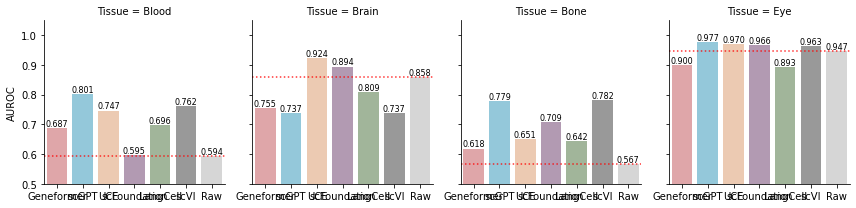

In [13]:
grid = sns.FacetGrid(df_all, col="Tissue")
# grid.map(sns.barplot, "Model", "AUROC", data=df_all, hue="Model", 
#          palette=custom_palette, order=model_order_wo_hvg+["Raw"])

def barplot_with_text(data, **kwargs):
    order = model_order_wo_hvg + ["Raw"]
    sns.barplot(data=data, x="Model", y="AUROC", hue="Model", palette=custom_palette, order=order)
    for index, model in enumerate(order):
        if model in data["Model"].values:
            value = data.set_index("Model").loc[model, "AUROC"]
            plt.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    plt.axhline(y=data.set_index("Model").loc["Raw", "AUROC"], color="red", linestyle=':', alpha=0.8)
grid.map_dataframe(barplot_with_text) # map_datafrmae：不需要传递data参数
grid.set_axis_labels('', "AUROC")
# grid.set_xticklabels([])
plt.ylim(0.5,1.05)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 0.8), ncol=1, title=None, frameon=False, fontsize=10)
plt.tight_layout()
# plt.savefig("../figures/cancer_finder/auroc_all_absolute.png", 
#             dpi=300, bbox_inches='tight')

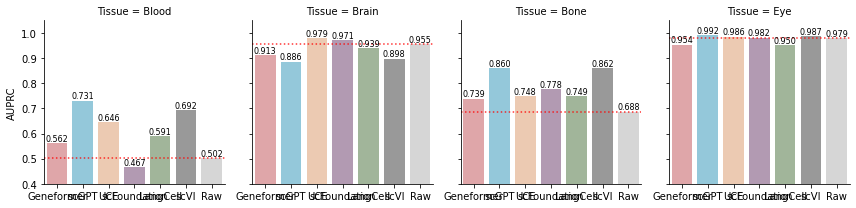

In [ ]:
grid = sns.FacetGrid(df_all, col="Tissue")

def barplot_with_text(data, **kwargs):
    order = model_order_wo_hvg + ["Raw"]
    sns.barplot(data=data, x="Model", y="AUPRC", hue="Model", palette=custom_palette, order=order)
    for index, model in enumerate(order):
        if model in data["Model"].values:
            value = data.set_index("Model").loc[model, "AUPRC"]
            plt.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    plt.axhline(y=data.set_index("Model").loc["Raw", "AUPRC"], color="red", linestyle=':', alpha=0.8)
grid.map_dataframe(barplot_with_text) # map_datafrmae：不需要传递data参数
grid.set_axis_labels('', "AUPRC")
# grid.set_xticklabels([])
plt.ylim(0.4,1.05)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 0.8), ncol=1, title=None, frameon=False, fontsize=10)
plt.tight_layout()
# plt.savefig("../figures/cancer_finder/auprc_all_absolute.png", 
#             dpi=300, bbox_inches='tight')

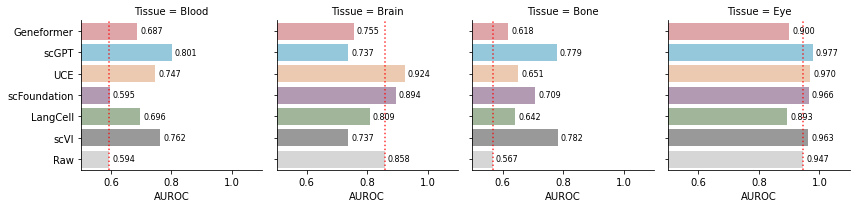

In [17]:
grid = sns.FacetGrid(df_all, col="Tissue")
# grid.map(sns.barplot, "Model", "AUPRC", data=df_all, hue="Model", 
#          palette=custom_palette, order=model_order_wo_hvg+["Raw"])

def barplot_with_text(data, **kwargs):
    order = model_order_wo_hvg + ["Raw"] 
    sns.barplot(data=data, x="AUROC", y="Model", hue="Model", palette=custom_palette, order=order, orient="h")
    for index, model in enumerate(order):
        if model in data["Model"].values:
            value = data.set_index("Model").loc[model, "AUROC"]
            plt.text(value+0.01, index, f'{value:.3f}', ha='left', va='center', fontsize=8)
    plt.axvline(x=data.set_index("Model").loc["Raw", "AUROC"], color="red", linestyle=':', alpha=0.8)
grid.map_dataframe(barplot_with_text) # map_datafrmae：不需要传递data参数
grid.set_axis_labels('AUROC', "")
# grid.set_xticklabels([])
plt.xlim(0.5,1.1)
plt.tight_layout()
plt.savefig("../figures/cancer_finder/auroc_all_absolute_orienth.png", 
            dpi=300, bbox_inches='tight')

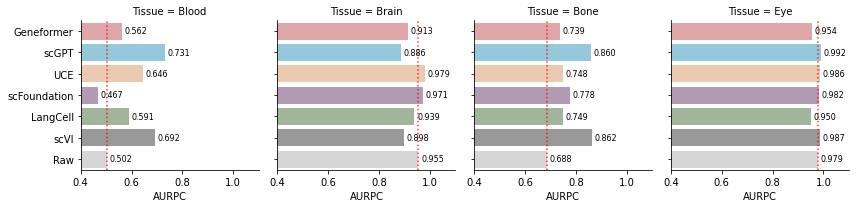

In [18]:
grid = sns.FacetGrid(df_all, col="Tissue")
# grid.map(sns.barplot, "Model", "AUPRC", data=df_all, hue="Model", 
#          palette=custom_palette, order=model_order_wo_hvg+["Raw"])

def barplot_with_text(data, **kwargs):
    order = model_order_wo_hvg + ["Raw"] 
    sns.barplot(data=data, x="AUPRC", y="Model", hue="Model", palette=custom_palette, order=order, orient="h")
    for index, model in enumerate(order):
        if model in data["Model"].values:
            value = data.set_index("Model").loc[model, "AUPRC"]
            plt.text(value+0.01, index, f'{value:.3f}', ha='left', va='center', fontsize=8)
    plt.axvline(x=data.set_index("Model").loc["Raw", "AUPRC"], color="red", linestyle=':', alpha=0.8)
grid.map_dataframe(barplot_with_text) # map_datafrmae：不需要传递data参数
grid.set_axis_labels('AURPC', "")
# grid.set_xticklabels([])
plt.xlim(0.4,1.1)
plt.tight_layout()
plt.savefig("../figures/cancer_finder/auprc_all_absolute_orienth.png", 
            dpi=300, bbox_inches='tight')

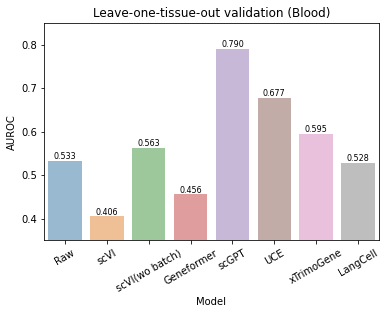

In [90]:
sns.barplot(data=df, x="Model", y="AUROC", hue="Model", alpha=0.5)
for index, value in enumerate(df["AUROC"].values):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)
plt.title(f"Leave-one-tissue-out validation ({tissue})")
plt.ylim(0.35, 0.85)
plt.xticks(ticks=np.arange(len(model_list)),
           labels=["Raw", "scVI", "scVI(wo batch)", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], 
           rotation=30)
plt.xlabel("")
plt.tight_layout()
plt.savefig(f"../figures/cancer_finder/{tissue}_auroc.png", dpi=300)

### Average performance

In [51]:
# load optimized results
result_dir = "../SequencingCancerFinder/optuna_results"
result = pd.DataFrame()
model_list = ["X", "scVI_integrated_tissue", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
for tissue in tissue_list:
    df = pd.DataFrame()
    auroc_ls, auprc_ls = [], []
    model_ls = []
    for model in model_list:
        optuna_results = pd.read_csv(os.path.join(result_dir, model, "optuna_all_trials.csv"))
        bs, dropout, lr, decay = optuna_results.loc[optuna_results["value"].idxmax(), :][1:]
        with open(os.path.join(result_dir, model, f"bs_{int(bs)}_lr_{lr}_drop_{dropout:.2f}_decay_{decay}", tissue, "train_log_val.txt")) as f:
            res = f.readlines()[-2:]
            auroc, auprc = res[0].strip().split(": ")[1], res[1].strip().split(": ")[1]
            auroc_ls.append(float(auroc))
            auprc_ls.append(float(auprc))
            model_ls.append(model_map_dict.get(model, model))
    df["Model"] = model_ls
    df["AUROC"] = auroc_ls
    df["AUPRC"] = auprc_ls
    df["Tissue"] = tissue
    result = pd.concat([result, df], axis=0)
result

Model   AUROC   AUPRC Tissue
0           Raw  0.5942  0.5019  Blood
1          scVI  0.7623  0.6918  Blood
2    Geneformer  0.6867  0.5618  Blood
3         scGPT  0.8011  0.7309  Blood
4           UCE  0.7467  0.6463  Blood
5  scFoundation  0.5953  0.4667  Blood
6      LangCell  0.6963  0.5911  Blood
0           Raw  0.8579  0.9546  Brain
1          scVI  0.7370  0.8981  Brain
2    Geneformer  0.7552  0.9130  Brain
3         scGPT  0.7373  0.8861  Brain
4           UCE  0.9238  0.9793  Brain
5  scFoundation  0.8944  0.9712  Brain
6      LangCell  0.8090  0.9389  Brain
0           Raw  0.5673  0.6876   Bone
1          scVI  0.7824  0.8618   Bone
2    Geneformer  0.6184  0.7386   Bone
3         scGPT  0.7795  0.8600   Bone
4           UCE  0.6511  0.7476   Bone
5  scFoundation  0.7089  0.7783   Bone
6      LangCell  0.6425  0.7487   Bone
0           Raw  0.9467  0.9785    Eye
1          scVI  0.9632  0.9873    Eye
2    Geneformer  0.9003  0.9541    Eye
3         scGPT  0.9774  0.9917    Eye
4           UCE  0.9699  0.9855    Eye
5  scFoundation  0.9657  0.9819    Eye
6      LangCell  0.8932  0.9502    Eye

In [120]:
mean_df = result.set_index("Tissue").groupby(["Model"]).agg("mean").reset_index()
std_df = result.set_index("Tissue").groupby(["Model"]).agg("std").reset_index()

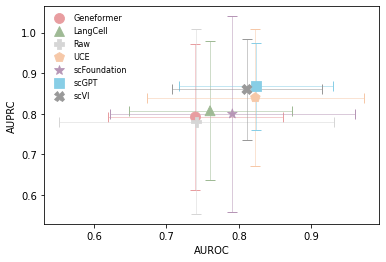

In [122]:
# plot auroc and auprc in a single figure
ax = sns.scatterplot(mean_df, x="AUROC", y="AUPRC", hue="Model", style="Model",
                    palette=custom_palette, markers=custom_shape, s=100, edgecolor=None,
                    zorder=2)
for model in std_df['Model'].unique():
    idx = std_df[std_df['Model'] == model].index[0]
    plt.errorbar(mean_df.loc[idx, 'AUROC'], mean_df.loc[idx, 'AUPRC'], 
                yerr=std_df.loc[idx, 'AUPRC'], 
                xerr=std_df.loc[idx, 'AUROC'], 
                fmt='none', ecolor=custom_palette[model], capsize=5, elinewidth=0.5,
                zorder=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 1), 
                title=None, frameon=False, fontsize=8) # title_fontsize
plt.savefig("figures/cancer_finder/auroc_auprc.png", dpi=300, bbox_inches='tight')

In [123]:
keys = mean_df["Model"]
values = mean_df.loc[:, ["AUROC", "AUPRC"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.74015 , 0.791875]), 'LangCell': array([0.76025 , 0.807225]), 'Raw': array([0.741525, 0.78065 ]), 'UCE': array([0.822875, 0.839675]), 'scFoundation': array([0.791075, 0.799525]), 'scGPT': array([0.823825, 0.867175]), 'scVI': array([0.811225, 0.85975 ])}
Front 1: ['scGPT']
Front 2: ['UCE', 'scVI']
Front 3: ['LangCell', 'scFoundation']
Front 4: ['Geneformer', 'Raw']


In [132]:
for tissue in result["Tissue"].unique():
    df = result[result["Tissue"]==tissue]
    keys = df["Model"]
    values = df.loc[:, ["AUROC", "AUPRC"]].values
    population = {k:v for k,v in zip(keys, values)}
    print(f"========== {tissue} ==========")
    fronts = non_dominated_sort(population)
    for i, front in enumerate(fronts):
        print(f"Front {i + 1}: {front}")

========== Blood ==========
Front 1: ['scGPT']
Front 2: ['scVI']
Front 3: ['UCE']
Front 4: ['LangCell']
Front 5: ['Geneformer']
Front 6: ['Raw', 'scFoundation']
========== Brain ==========
Front 1: ['UCE']
Front 2: ['scFoundation']
Front 3: ['Raw']
Front 4: ['LangCell']
Front 5: ['Geneformer']
Front 6: ['scVI', 'scGPT']
========== Bone ==========
Front 1: ['scVI']
Front 2: ['scGPT']
Front 3: ['scFoundation']
Front 4: ['UCE', 'LangCell']
Front 5: ['Geneformer']
Front 6: ['Raw']
========== Eye ==========
Front 1: ['scGPT']
Front 2: ['scVI', 'UCE']
Front 3: ['scFoundation']
Front 4: ['Raw']
Front 5: ['Geneformer']
Front 6: ['LangCell']


## Roughness index (lower is better)

In [ ]:
model_list = ["X", "scVI_integrated_tissue", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
tissue_list = ['Blood', 'Brain', 'Bone', 'Eye']
rogi_df = pd.DataFrame()
rogi_df["model"] = model_list
for tissue in tissue_list:
    print(f"Calculating ROGI for the adata from tissue: {tissue}")
    rogi_ls = []
    adata = sc.read_h5ad(f"../output/TISCH/{tissue}.h5ad")
    np.random.seed(42)
    sample_pos = np.random.choice(adata.obs[adata.obs["label"]==1].index, 5000, replace=False)
    sample_neg = np.random.choice(adata.obs[adata.obs["label"]==0].index, 5000, replace=False)
    adata_subset = adata[adata.obs.index.isin(np.concatenate([sample_neg, sample_pos]))]
    for model in model_list:
        if model == "X":
            ri = RoughnessIndex(X=adata_subset.X.toarray(), Y=adata_subset.obs['label'], metric='euclidean', verbose=False)        
        else:
            ri = RoughnessIndex(X=adata_subset.obsm[model], Y=adata_subset.obs['label'], metric='euclidean', verbose=False)        
        rogi = ri.compute_index(min_dt=0.01)
        rogi_ls.append(rogi)
    rogi_df[tissue] = rogi_ls

Calculating ROGI for the adata from tissue: Blood


In [25]:
model_list = ["X", "scVI_integrated_tissue", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
tissue_list = ['Blood', 'Brain', 'Bone', 'Eye']
rogi_df = pd.DataFrame()
rogi_df["model"] = model_list
for (tissue1, tissue2) in list(itertools.combinations(tissue_list, 2)):
    print(f"Calculating ROGI for the combination of: {tissue1} + {tissue2}")
    rogi_ls = []
    adata = sc.read_h5ad(f"../output/TISCH/{tissue1}.h5ad")
    np.random.seed(42)
    sample_pos = np.random.choice(adata.obs[adata.obs["label"]==1].index, 1000, replace=False)
    sample_neg = np.random.choice(adata.obs[adata.obs["label"]==0].index, 1000, replace=False)
    adata_subset = adata[adata.obs.index.isin(np.concatenate([sample_neg, sample_pos]))]

    adata = sc.read_h5ad(f"../output/TISCH/{tissue2}.h5ad")
    sample_pos = np.random.choice(adata.obs[adata.obs["label"]==1].index, 1000, replace=False)
    sample_neg = np.random.choice(adata.obs[adata.obs["label"]==0].index, 1000, replace=False)
    adata_subset = adata_subset.concatenate(adata[adata.obs.index.isin(np.concatenate([sample_neg, sample_pos]))])
    print(adata_subset.X.shape)

    for model in model_list:
        if model == "X":
            ri = RoughnessIndex(X=adata_subset.X.toarray(), Y=adata_subset.obs['label'], metric='euclidean', verbose=False)        
        else:
            ri = RoughnessIndex(X=adata_subset.obsm[model], Y=adata_subset.obs['label'], metric='euclidean', verbose=False)        
        rogi = ri.compute_index(min_dt=0.01)
        rogi_ls.append(rogi)
    rogi_df[f"{tissue1}_{tissue2}"] = rogi_ls

Calculating ROGI for the combination of: Blood + Brain


/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


(4000, 10112)
Calculating ROGI for the combination of: Blood + Bone


/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


(4000, 11556)
Calculating ROGI for the combination of: Blood + Eye


/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


(4000, 11986)
Calculating ROGI for the combination of: Brain + Bone


/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


(4000, 11151)
Calculating ROGI for the combination of: Brain + Eye


/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


(4000, 12132)
Calculating ROGI for the combination of: Bone + Eye


/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


(4000, 16568)


In [40]:
for tissue in tissue_list:
    rogi_df[tissue] = rogi_df.loc[:, [col for col in rogi_df.columns if tissue in col]].mean(1)
rogi_df

model  Blood_Brain  Blood_Bone  Blood_Eye  Brain_Bone  \
0                       X     0.763469    0.789371   0.737472    0.780748   
1  scVI_integrated_tissue     0.726005    0.740819   0.704324    0.726927   
2              Geneformer     0.803406    0.805553   0.748929    0.792617   
3                   scGPT     0.712971    0.688925   0.653224    0.747748   
4                     UCE     0.767616    0.727067   0.755577    0.777678   
5              xTrimoGene     0.672733    0.776516   0.740643    0.763510   
6                LangCell     0.757820    0.781528   0.752251    0.769848   

   Brain_Eye  Bone_Eye     Blood     Brain      Bone       Eye  
0   0.756271  0.788011  0.763437  0.766829  0.786043  0.760585  
1   0.706549  0.724912  0.723716  0.719827  0.730886  0.711929  
2   0.769704  0.773619  0.785963  0.788576  0.790596  0.764084  
3   0.711612  0.687924  0.685040  0.724110  0.708199  0.684253  
4   0.744389  0.615146  0.750087  0.763228  0.706630  0.705038  
5   0.727323  0.737391  0.729964  0.721188  0.759139  0.735119  
6   0.742994  0.774253  0.763866  0.756887  0.775209  0.756499

In [131]:
# rogi_df.to_csv("../figures/cancer_finder/cancer_finder_rogi_pairwise.csv", index=False)
rogi_df = pd.read_csv("../figures/cancer_finder/cancer_finder_rogi_pairwise.csv", usecols=["model"]+tissue_list)
rogi_df["model"] = rogi_df["model"].apply(lambda x: model_map_dict.get(x, x))
rogi_df = rogi_df.set_index("model")
rogi_df

Blood   Brain    Bone     Eye
model                                       
Raw           0.7634  0.7668  0.7860  0.7606
scVI          0.7237  0.7198  0.7309  0.7119
Geneformer    0.7860  0.7886  0.7906  0.7641
scGPT         0.6850  0.7241  0.7082  0.6843
UCE           0.7501  0.7632  0.7066  0.7050
scFoundation  0.7300  0.7212  0.7591  0.7351
LangCell      0.7639  0.7569  0.7752  0.7565

0.7634373276645124 0.5 1.5
0.7668294331922909 1.5 2.5
0.7860434476927264 2.5 3.5
0.7605848927643697 3.5 4.5


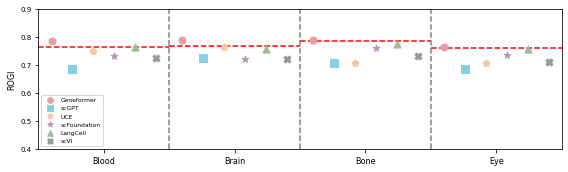

In [136]:
plt.figure(figsize=(8,2.5))
x = np.arange(1,5)
x_line = [0.5, 1.5, 2.5, 3.5, 4.5]
plt.xlim(0.5, 4.5)
plt.ylim(0.4, 0.9)
width = 0.16
for i, model_name in enumerate(model_order_wo_hvg + ["Raw"]):
    x_pos = x + i * width - 2.5 * width  # Adjust x position for each dataset
    y = rogi_df.loc[model_name, :]
    # print(x_pos)
    if model_name == "Raw":
        x_min = x_line[:-1]
        x_max = x_line[1:]
        xlim = plt.gca().get_xlim()
        for y_, x_min_, x_max_ in zip(y, x_min, x_max):
            print(y_, x_min_, x_max_)
            x_min_ = (x_min_ - xlim[0]) / (xlim[1] - xlim[0])
            x_max_ = (x_max_ - xlim[0]) / (xlim[1] - xlim[0])
            plt.axhline(y=y_, xmin=x_min_, xmax=x_max_, ls="--", color="red",zorder=1)
    else:
        plt.scatter(x_pos, y, s=50, color=custom_palette[model_name], alpha=1, label=model_name, zorder=2,
            marker=custom_shape[model_name])
plt.legend(fontsize=6, markerscale=0.8)
for x in x_line[1:-1]:
    plt.axvline(x=x, ls="--", color="grey")   
plt.ylabel("ROGI", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(ticks=[1,2,3,4], labels=['Blood', 'Brain', 'Bone', 'Eye'], fontsize=8)
plt.tight_layout()
plt.savefig("../figures/cancer_finder/tissue_rogi.png", dpi=300)

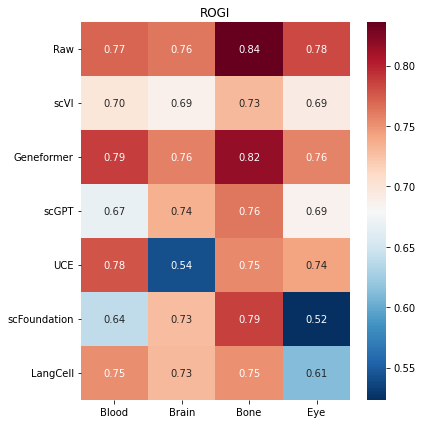

In [48]:
heatmap_df = rogi_df
plt.figure(figsize=(6,6))
ax = sns.heatmap(heatmap_df, annot=True, cmap="RdBu_r", fmt=".2f")
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("ROGI")
plt.tight_layout()
# plt.savefig("figures/cancer_finder/tissue_rogi_heatmap.png", dpi=300, bbox_inches="tight")

### Correlation of ROGI and model performance

In [52]:
x = result.groupby("Model")[["AUROC", "AUPRC"]].agg("mean").reset_index()
x = x.set_index("Model")
x

AUROC     AUPRC
Model                           
Geneformer    0.740150  0.791875
LangCell      0.760250  0.807225
Raw           0.741525  0.780650
UCE           0.822875  0.839675
scFoundation  0.791075  0.799525
scGPT         0.823825  0.867175
scVI          0.811225  0.859750

In [53]:
y = rogi_df.mean(1).to_frame("ROGI")
y

ROGI
model                 
Raw           0.769224
scVI          0.721589
Geneformer    0.782305
scGPT         0.700401
UCE           0.731246
scFoundation  0.736353
LangCell      0.763115

In [54]:
df = pd.merge(x, y, left_index=True, right_index=True)
df

AUROC     AUPRC      ROGI
Geneformer    0.740150  0.791875  0.782305
LangCell      0.760250  0.807225  0.763115
Raw           0.741525  0.780650  0.769224
UCE           0.822875  0.839675  0.731246
scFoundation  0.791075  0.799525  0.736353
scGPT         0.823825  0.867175  0.700401
scVI          0.811225  0.859750  0.721589

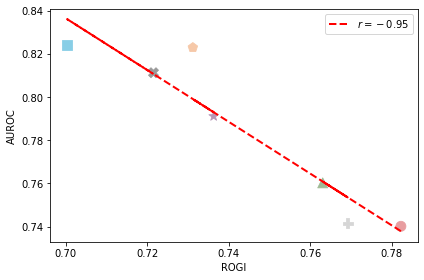

In [56]:
df_plot = df.copy()
df_plot["Model"] = df.index
r, p_value = pearsonr(df["AUROC"], df["ROGI"])
ax = sns.scatterplot(df_plot, x="ROGI", y="AUROC", hue="Model", style="Model", s=100,
                     markers=custom_shape, palette=custom_palette,
                     edgecolor=None, legend=None)
coef = np.polyfit(df["ROGI"], df["AUROC"], 1)
poly = np.poly1d(coef)
ax.plot(df["ROGI"], poly(df["ROGI"]), linestyle="--", color="red", linewidth=2, label=f"$r = {r:.2f}$")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/cancer_finder/auroc_rogi_regplot.png", dpi=300, bbox_inches="tight")

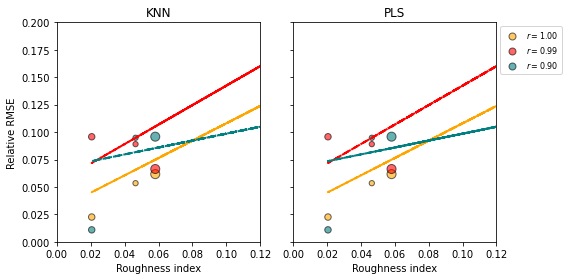

In [57]:
# 示例数据（替换为你的实际数据）
np.random.seed(42)
roughness_index = np.random.rand(30)
relative_rmse_1 = 0.8 * roughness_index + 0.05 * np.random.rand(30)
relative_rmse_2 = 0.9 * roughness_index + 0.1 * np.random.rand(30)
relative_rmse_3 = 0.3 * roughness_index + 0.15 * np.random.rand(30)

weights = np.random.rand(30) * 100  # 权重决定点大小

# 计算 Pearson 相关系数
r1, _ = pearsonr(roughness_index, relative_rmse_1)
r2, _ = pearsonr(roughness_index, relative_rmse_2)
r3, _ = pearsonr(roughness_index, relative_rmse_3)

# 配置绘图参数
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
models = ["KNN", "PLS"]
colors = ["orange", "red", "teal"]
rmse_data = [relative_rmse_1, relative_rmse_2, relative_rmse_3]
r_values = [r1, r2, r3]

# 绘制每个模型的散点图
for ax, model in zip(axes, models):
    for rmse, color, r in zip(rmse_data, colors, r_values):
        ax.scatter(roughness_index, rmse, s=weights, color=color, alpha=0.6, edgecolor='k', label=f"$r = {r:.2f}$")
        # 添加拟合线
        coef = np.polyfit(roughness_index, rmse, 1)
        poly = np.poly1d(coef)
        ax.plot(roughness_index, poly(roughness_index), linestyle="--", color=color, linewidth=2)

    # 设置轴和标题
    ax.set_title(model, fontsize=12)
    ax.set_xlabel("Roughness index", fontsize=10)
    ax.set_xlim(0, 0.12)
    ax.set_ylim(0, 0.2)

# 设置左轴
axes[0].set_ylabel("Relative RMSE", fontsize=10)

# 调整布局和图例
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [85]:
df.corr()

AUROC     AUPRC      ROGI
AUROC  1.000000  0.890011 -0.731283
AUPRC  0.890011  1.000000 -0.508652
ROGI  -0.731283 -0.508652  1.000000

In [89]:
df.corr(method="spearman")

AUROC     AUPRC      ROGI
AUROC  1.000000  0.892857 -0.464286
AUPRC  0.892857  1.000000 -0.428571
ROGI  -0.464286 -0.428571  1.000000

In [25]:
pearsonr(df["AUROC"], df["ROGI"])

PearsonRResult(statistic=-0.7312833603627763, pvalue=0.061819693896920894)

In [88]:
pearsonr(df["AUPRC"], df["ROGI"])

PearsonRResult(statistic=-0.508652305681315, pvalue=0.24371232556634914)

## UMAP visualization

In [1]:
tissue_list = ['Blood', 'Brain', 'Bone', 'Eye']
tissue_list

['Blood', 'Brain', 'Bone', 'Eye']

In [5]:
adata_list = []
for i, tissue in enumerate(tissue_list):
    adata = sc.read_h5ad(f"../output/TISCH/{tissue}.h5ad")
    adata.obs["Tissue"] = tissue
    adata_list.append(adata)
adata_all = ad.concat(adata_list, join='outer')

In [173]:
adata_all.obs["Tissue"]

Cell
AML328-D113_ATTAAGCATTTC                 Blood
AML328-D113_GAAATGCCCCAT                 Blood
AML328-D113_GGGTGGCGAAAC                 Blood
AML328-D113_TAACTAAGCTAC                 Blood
AML328-D113_TCGTTAGTTATT                 Blood
                                         ...  
GSM4147100_UMM067L@TCGCGTTGTGTTAAGA-1      Eye
GSM4147100_UMM067L@TCTGGAACATTAACCG-1      Eye
GSM4147100_UMM067L@TGAGCATAGCGTGAAC-1      Eye
GSM4147100_UMM067L@TTAGGACCAAAGTCAA-1      Eye
GSM4147100_UMM067L@TTCCCAGAGTCAATAG-1      Eye
Name: Tissue, Length: 267390, dtype: object

In [ ]:
model = "scVI_integrated"
sc.pp.neighbors(adata_all, use_rep=model)
sc.tl.umap(adata_all)
fig = sc.pl.umap(adata_all, color=['Celltype (malignancy)', 'Tissue'], wspace=0.3, return_fig=True)
fig.savefig(f"../figures/cancer_finder/{model}_umap.png", dpi=300, bbox_inches='tight')

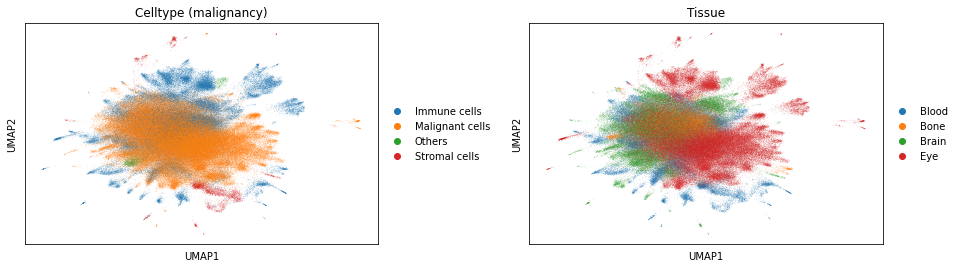

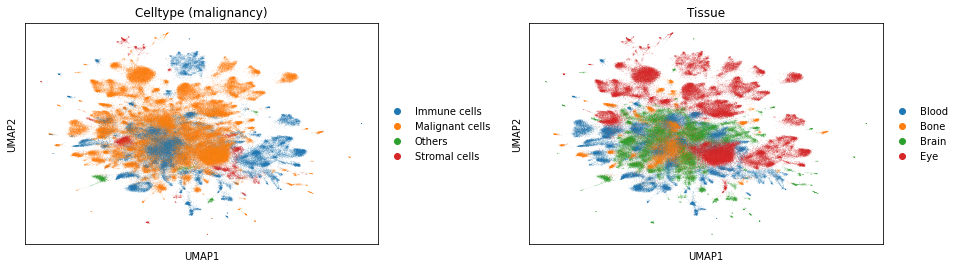

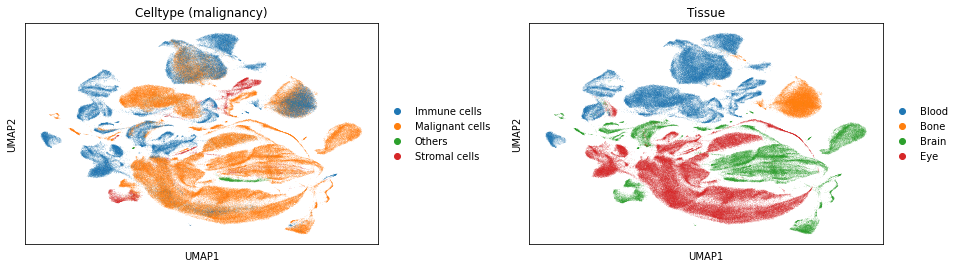

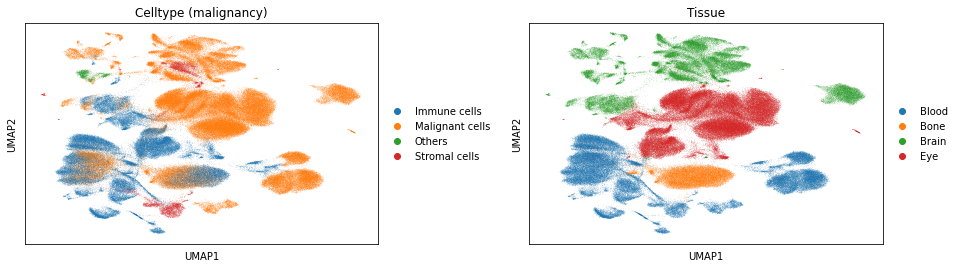

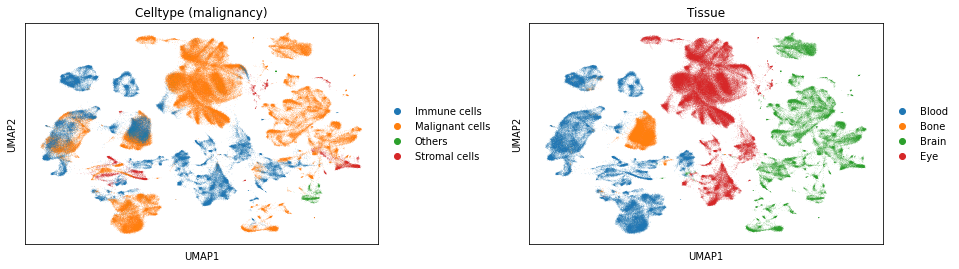

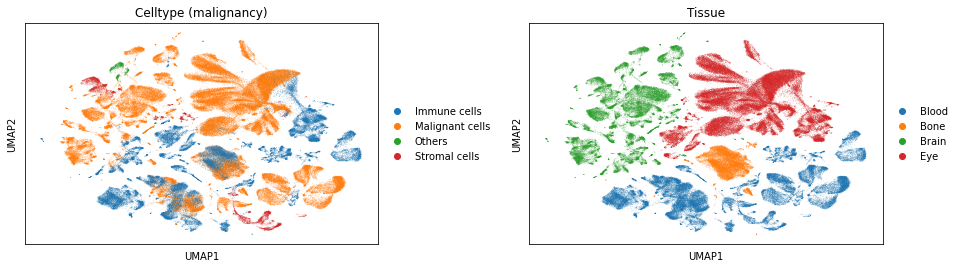

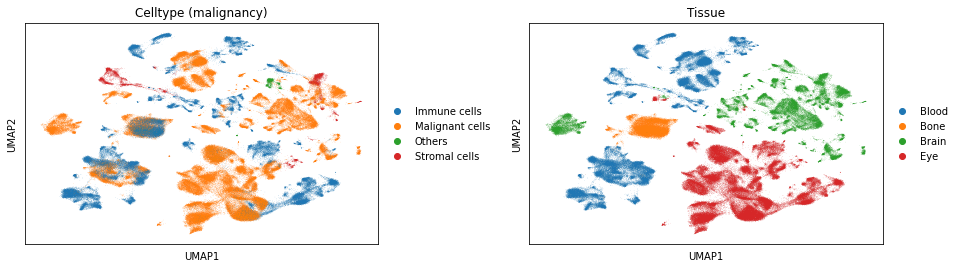

In [182]:
for model in model_list[1:]:
    sc.pp.neighbors(adata_all, use_rep=model)
    sc.tl.umap(adata_all)
    fig = sc.pl.umap(adata_all, color=['Celltype (malignancy)', 'Tissue'], wspace=0.3, return_fig=True)
    fig.savefig(f"../figures/cancer_finder/{model}_umap.png", dpi=300, bbox_inches='tight')

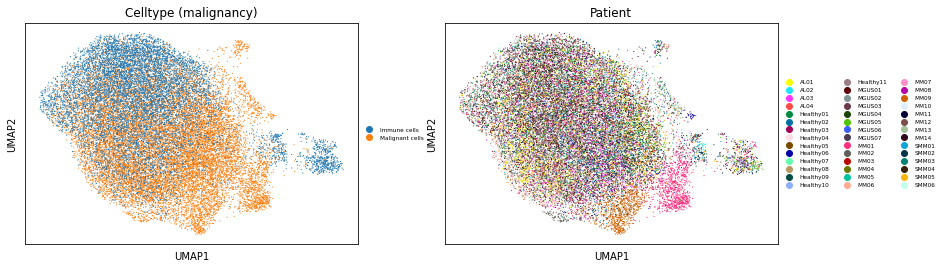

In [157]:
sc.pp.neighbors(adata, use_rep='scGPT')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Celltype (malignancy)', 'Patient'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

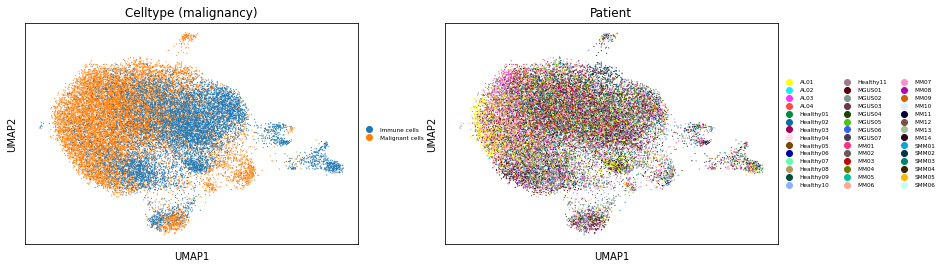

In [158]:
sc.pp.neighbors(adata, use_rep='scVI')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Celltype (malignancy)', 'Patient'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

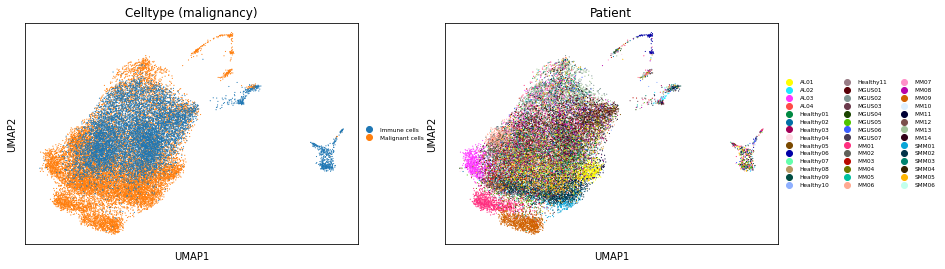

In [159]:
sc.pp.neighbors(adata, use_rep='UCE')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Celltype (malignancy)', 'Patient'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

# Drug sensitivity

In [109]:
result = pd.read_csv("../figures/drug_sensitivity/drug_sensitivity.csv", delimiter="\t")
result.head()

Drug   AUROC   AUPRC         Model
0      Sorafenib  0.8400  0.8400  scFoundation
1     NVP-TAE684  0.8400  0.8737  scFoundation
2  PLX4720_451Lu  0.6600  0.6755  scFoundation
3      Etoposide  0.6800  0.6227  scFoundation
4      Sorafenib  0.7819  0.7393         scGPT

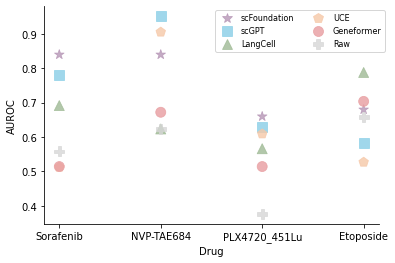

In [25]:
# sns.stripplot(result, x="Drug", y="AUROC", hue="Model", s=10, 
#               palette=custom_palette)
sns.scatterplot(result, x="Drug", y="AUROC", style="Model", hue="Model", s=100, 
                palette=custom_palette, markers=custom_shape, alpha=0.8, edgecolor=None)
sns.despine(top=True, right=True, left=False, bottom=False)
ax = plt.gca()
# ax.legend(loc="upper left", ncol=3, title="Model", frameon=True, bbox_to_anchor=(1, 0.8))
ax.legend(loc="upper left", ncol=2, fontsize=8, bbox_to_anchor=(0.5, 1))
plt.savefig("../figures/drug_sensitivity/drug_auroc_1105.png", dpi=300, bbox_inches='tight')

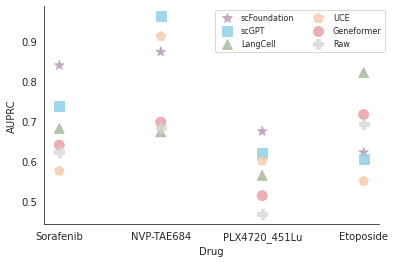

In [27]:
sns.set_style('white')
sns.scatterplot(result, x="Drug", y="AUPRC", style="Model", hue="Model", s=100, 
                palette=custom_palette, markers=custom_shape, alpha=0.8, edgecolor=None)
sns.despine(top=True, right=True, left=False, bottom=False)
ax = plt.gca()
# ax.legend(loc="upper left", ncol=1, title="Model", frameon=True, bbox_to_anchor=(1, 0.8))
ax.legend(loc="upper left", ncol=2, fontsize=8, bbox_to_anchor=(0.5, 1))
plt.savefig("../figures/drug_sensitivity/drug_auprc_1105.png", dpi=300, bbox_inches='tight')

## Roughness index (lower is better)

In [11]:
rogi_result = []
drug_ls = ["Sorafenib", "Etoposide", "NVP-TAE684", "PLX4720_451Lu"]
model_ls = ["geneformer", "scgpt", "uce", "xTrimoGene", "langcell", "Raw"]
for drug in drug_ls:
    for model in model_ls:
        folder = f"./xTrimoGene/SCAD/data_allen/{drug}/{model}/stratified_emb/before_training"
        for split_id in range(1,6):
            bulk_train_X = pd.read_csv(os.path.join(folder, "source_5_folds", f"split{split_id}", "X_train_source.tsv"), delimiter="\t", index_col=0)
            bulk_train_Y = pd.read_csv(os.path.join(folder, "source_5_folds", f"split{split_id}", "Y_train_source.tsv"), delimiter="\t", index_col=0)
            sc_train_X = pd.read_csv(os.path.join(folder, "target_5_folds", f"split{split_id}", "X_train_target.tsv"), delimiter="\t", index_col=0)
            sc_train_Y = pd.read_csv(os.path.join(folder, "target_5_folds", f"split{split_id}", "Y_train_target.tsv"), delimiter="\t", index_col=0)
            
            ri = RoughnessIndex(X=bulk_train_X, Y=bulk_train_Y, metric='euclidean', verbose=False)        
            rogi_bulk = ri.compute_index(min_dt=0.01)
            ri = RoughnessIndex(X=sc_train_X, Y=sc_train_Y, metric='euclidean', verbose=False)        
            rogi_sc = ri.compute_index(min_dt=0.01)            
            ri = RoughnessIndex(X=pd.concat([sc_train_X, bulk_train_X]) , Y=pd.concat([sc_train_Y, bulk_train_Y]), metric='euclidean', verbose=False)        
            rogi_all = ri.compute_index(min_dt=0.01)

            rogi_result.append(
                {"drug": drug,
                 "model": model_map_dict.get(model, model),
                 "split": split_id,
                 "ROGI(Bulk)": rogi_bulk,
                 "ROGI(Single-cell)": rogi_sc,
                 "ROGI(Combined)": rogi_all}
            )

In [137]:
# rogi_df = pd.DataFrame.from_dict(rogi_result)
# rogi_df.to_csv("../figures/drug_sensitivity/cancer_finder_rogi.csv", index=False)
rogi_df = pd.read_csv("../figures/drug_sensitivity/cancer_finder_rogi.csv")
rogi_df_grouped = rogi_df.groupby(["drug", "model"]).agg("mean").reset_index()
rogi_df_grouped

drug         model  split  ROGI(Bulk)  ROGI(Single-cell)  \
0       Etoposide    Geneformer    3.0      0.3883             0.7491   
1       Etoposide      LangCell    3.0      0.3767             0.7316   
2       Etoposide           Raw    3.0      0.3869             0.8448   
3       Etoposide           UCE    3.0      0.3799             0.7579   
4       Etoposide  scFoundation    3.0      0.3823             0.7114   
5       Etoposide         scGPT    3.0      0.3776             0.7564   
6      NVP-TAE684    Geneformer    3.0      0.4595             0.7121   
7      NVP-TAE684      LangCell    3.0      0.4463             0.6398   
8      NVP-TAE684           Raw    3.0      0.4562             0.7251   
9      NVP-TAE684           UCE    3.0      0.4472             0.6514   
10     NVP-TAE684  scFoundation    3.0      0.4600             0.5893   
11     NVP-TAE684         scGPT    3.0      0.4606             0.5237   
12  PLX4720_451Lu    Geneformer    3.0      0.4952             0.7593   
13  PLX4720_451Lu      LangCell    3.0      0.4805             0.6880   
14  PLX4720_451Lu           Raw    3.0      0.4987             0.7311   
15  PLX4720_451Lu           UCE    3.0      0.4815             0.7159   
16  PLX4720_451Lu  scFoundation    3.0      0.4776             0.6976   
17  PLX4720_451Lu         scGPT    3.0      0.4827             0.6900   
18      Sorafenib    Geneformer    3.0      0.4181             0.7121   
19      Sorafenib      LangCell    3.0      0.4150             0.6398   
20      Sorafenib           Raw    3.0      0.4132             0.7251   
21      Sorafenib           UCE    3.0      0.4120             0.6476   
22      Sorafenib  scFoundation    3.0      0.4207             0.5237   
23      Sorafenib         scGPT    3.0      0.4207             0.5237   

    ROGI(Combined)  
0           0.6674  
1           0.6899  
2           0.8417  
3           0.7205  
4           0.6605  
5           0.7153  
6           0.5473  
7           0.5567  
8           0.6230  
9           0.5555  
10          0.5159  
11          0.4817  
12          0.5348  
13          0.5525  
14          0.5922  
15          0.5592  
16          0.5523  
17          0.5586  
18          0.5245  
19          0.5385  
20          0.6190  
21          0.5349  
22          0.4581  
23          0.4581

0.6898963007229952 0.5 1.5
0.5567450531616973 1.5 2.5
0.55248997753356 2.5 3.5
0.5384555114759948 3.5 4.5


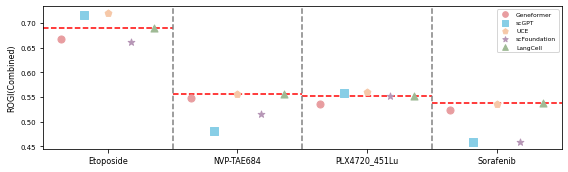

In [138]:
plt.figure(figsize=(8,2.5))
x = np.arange(1,5)
x_line = [0.5, 1.5, 2.5, 3.5, 4.5]
plt.xlim(0.5, 4.5)
width = 0.18
for i, model_name in enumerate(model_order_scFM+["Raw"]):
    if model_name == "Raw":
        x_min = x_line[:-1]
        x_max = x_line[1:]
        xlim = plt.gca().get_xlim()
        for y_, x_min_, x_max_ in zip(y, x_min, x_max):
            print(y_, x_min_, x_max_)
            x_min_ = (x_min_ - xlim[0]) / (xlim[1] - xlim[0])
            x_max_ = (x_max_ - xlim[0]) / (xlim[1] - xlim[0])
            plt.axhline(y=y_, xmin=x_min_, xmax=x_max_, ls="--", color="red",zorder=1)
    else:
        x_pos = x + i * width - 2 * width  # Adjust x position for each dataset
        y = rogi_df_grouped[rogi_df_grouped["model"]==model_name]["ROGI(Combined)"].tolist()
        # print(x_pos, y)
        plt.scatter(x_pos, y, s=50, color=custom_palette[model_name], alpha=1, label=model_name, zorder=2,
                    marker=custom_shape[model_name])

plt.legend(fontsize=6, markerscale=0.8)
for x in x_line[1:-1]:
    plt.axvline(x=x, ls="--", color="grey")   
plt.ylabel("ROGI(Combined)", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(ticks=[1,2,3,4], labels=rogi_df_grouped["drug"].unique(), fontsize=8)
plt.tight_layout()
plt.savefig("../figures/drug_sensitivity/drug_rogi.png", dpi=300)

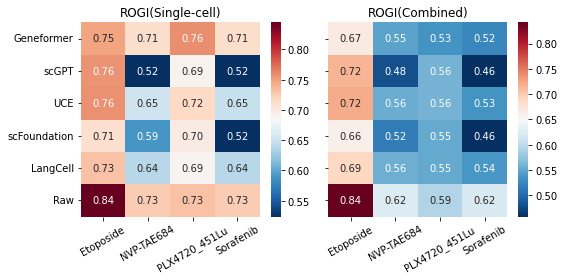

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)
for i, col in enumerate(["ROGI(Single-cell)", "ROGI(Combined)"]):
    heatmap_df = rogi_df_grouped.pivot(index="model", columns="drug", values=col)
    # heatmap_df.sort_index()
    # Map the sort order to a dictionary for use as a key
    sort_key = {value: idx for idx, value in enumerate(model_order_scFM+["Raw"])}
    # Sort the DataFrame
    sorted_df = heatmap_df.sort_index(key=lambda x: x.map(sort_key))
    sns.heatmap(sorted_df, annot=True, fmt=".2f", cmap="RdBu_r", ax=axes[i])
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].set_title(col)
    xticklabels = axes[i].get_xticklabels()
    axes[i].set_xticklabels(xticklabels, rotation=30)
    if i > 0:
        axes[i].set_yticklabels("")
plt.tight_layout()
# plt.savefig("figures/drug_sensitivity/drug_rogi_heatmap.png", dpi=300)

### Correlation of ROGI and model performance

In [82]:
x = result.groupby("Model")[["AUROC", "AUPRC"]].agg("mean").reset_index()
x = x.set_index("Model")
x

AUROC     AUPRC
Model                           
Geneformer    0.601125  0.643050
LangCell      0.667350  0.686075
Raw           0.554175  0.617675
UCE           0.638600  0.660425
scFoundation  0.755000  0.752975
scGPT         0.736525  0.732425

In [83]:
y = rogi_df_grouped.groupby("model")[["ROGI(Combined)"]].agg("mean").reset_index()
y = y.set_index("model")
y

ROGI(Combined)
model                       
Geneformer          0.568500
LangCell            0.584397
Raw                 0.668955
UCE                 0.592523
scFoundation        0.546730
scGPT               0.553412

In [84]:
df = pd.merge(x, y, left_index=True, right_index=True)
df

AUROC     AUPRC  ROGI(Combined)
Model                                           
Geneformer    0.601125  0.643050        0.568500
LangCell      0.667350  0.686075        0.584397
Raw           0.554175  0.617675        0.668955
UCE           0.638600  0.660425        0.592523
scFoundation  0.755000  0.752975        0.546730
scGPT         0.736525  0.732425        0.553412

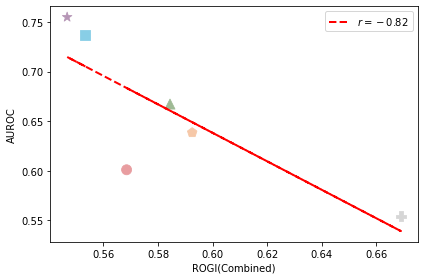

In [86]:
df_plot = df.copy()
df_plot["Model"] = df.index
r, p_value = pearsonr(df["AUROC"], df["ROGI(Combined)"])
ax = sns.scatterplot(df_plot, x="ROGI(Combined)", y="AUROC", hue="Model", style="Model", s=100,
                     markers=custom_shape, palette=custom_palette,
                     edgecolor=None, legend=None)
coef = np.polyfit(df["ROGI(Combined)"], df["AUROC"], 1)
poly = np.poly1d(coef)
ax.plot(df["ROGI(Combined)"], poly(df["ROGI(Combined)"]), linestyle="--", color="red", linewidth=2, label=f"$r = {r:.2f}$")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/drug_sensitivity/auroc_rogi_regplot.png", dpi=300, bbox_inches="tight")

In [73]:
# w/o pvalue
df.corr()

AUROC     AUPRC  ROGI(Combined)
AUROC           1.000000  0.994668       -0.821632
AUPRC           0.994668  1.000000       -0.794775
ROGI(Combined) -0.821632 -0.794775        1.000000

In [29]:
pearsonr(df["AUROC"], df["ROGI(Combined)"])

PearsonRResult(statistic=-0.8216319009808691, pvalue=0.04488536164495736)

In [30]:
spearmanr(df["AUROC"], df["ROGI(Combined)"])

SignificanceResult(statistic=-0.8285714285714287, pvalue=0.04156268221574334)

In [31]:
pearsonr(df["AUPRC"], df["ROGI(Combined)"])

PearsonRResult(statistic=-0.7947749112472168, pvalue=0.05885423846295497)

In [32]:
spearmanr(df["AUPRC"], df["ROGI(Combined)"])

SignificanceResult(statistic=-0.8285714285714287, pvalue=0.04156268221574334)

In [31]:
for drug in drug_ls:
    x = result[result["Drug"]==drug].sort_values(by="Model", key=lambda x: x.map(sort_key))["AUROC"]
    y = rogi_df_grouped[rogi_df_grouped["drug"]==drug].sort_values(by="model", key=lambda x: x.map(sort_key))["ROGI(Combined)"]
    print(x, y)
    pearsonr_coeff = pearsonr(x, y)
    spearmanr_coeff = spearmanr(x, y)
    print(pearsonr_coeff, spearmanr_coeff)

16    0.5142
4     0.7819
12    0.5125
0     0.8400
8     0.6917
20    0.5583
Name: AUROC, dtype: float64 18    0.524464
23    0.458141
21    0.534873
22    0.458141
19    0.538456
20    0.619015
Name: ROGI(Combined), dtype: float64
PearsonRResult(statistic=-0.7238391705811674, pvalue=0.10386652983458669) SignificanceResult(statistic=-0.5217939320872036, pvalue=0.28834323380039373)
19    0.7039
7     0.5842
15    0.5270
3     0.6800
11    0.7880
23    0.6587
Name: AUROC, dtype: float64 0    0.667449
5    0.715260
3    0.720495
4    0.660534
1    0.689896
2    0.841656
Name: ROGI(Combined), dtype: float64
PearsonRResult(statistic=-0.23994521706554378, pvalue=0.6469894422364861) SignificanceResult(statistic=-0.6, pvalue=0.20799999999999982)
17    0.6722
5     0.9514
13    0.9056
1     0.8400
9     0.6236
21    0.6236
Name: AUROC, dtype: float64 6     0.547262
11    0.481668
9     0.555489
10    0.515925
7     0.556745
8     0.622989
Name: ROGI(Combined), dtype: float64
PearsonRResult(sta

## Average performance

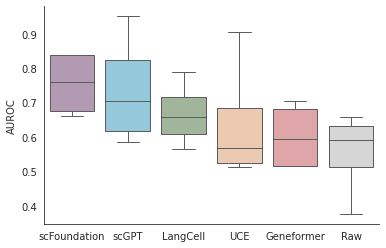

In [178]:
sns.boxplot(result, x="Model", y="AUROC", hue="Model", palette=custom_palette, width=0.8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("")
plt.savefig("figures/drug_sensitivity/average_auroc.png", dpi=300, bbox_inches='tight')

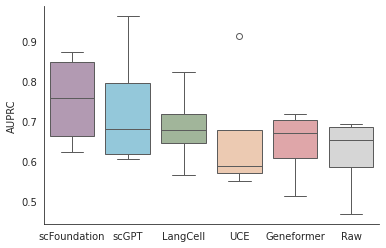

In [179]:
sns.boxplot(result, x="Model", y="AUPRC", hue="Model", palette=custom_palette, width=0.8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("")
plt.savefig("figures/drug_sensitivity/average_auprc.png", dpi=300, bbox_inches='tight')

In [302]:
mean_df = result.set_index("Drug").groupby(["Model"]).agg("mean").reset_index()
std_df = result.set_index("Drug").groupby(["Model"]).agg("std").reset_index()

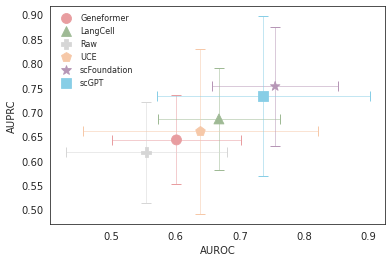

In [225]:
# plot auroc and auprc in a single figure
ax = sns.scatterplot(mean_df, x="AUROC", y="AUPRC", hue="Model", style="Model",
                    palette=custom_palette, markers=custom_shape, s=100, edgecolor=None,
                    zorder=2)
for model in std_df['Model'].unique():
    idx = std_df[std_df['Model'] == model].index[0]
    plt.errorbar(mean_df.loc[idx, 'AUROC'], mean_df.loc[idx, 'AUPRC'], 
                yerr=std_df.loc[idx, 'AUPRC'], 
                xerr=std_df.loc[idx, 'AUROC'], 
                fmt='none', ecolor=custom_palette[model], capsize=5, elinewidth=0.5,
                zorder=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 1), 
                title=None, frameon=False, fontsize=8) # title_fontsize
plt.savefig("figures/drug_sensitivity/auroc_auprc.png", dpi=300, bbox_inches='tight')

In [304]:
keys = mean_df["Model"]
values = mean_df.loc[:, ["AUROC", "AUPRC"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.601125, 0.64305 ]), 'LangCell': array([0.66735 , 0.686075]), 'Raw': array([0.554175, 0.617675]), 'UCE': array([0.6386  , 0.660425]), 'scFoundation': array([0.755   , 0.752975]), 'scGPT': array([0.736525, 0.732425])}
Front 1: ['scFoundation']
Front 2: ['scGPT']
Front 3: ['LangCell']
Front 4: ['UCE']
Front 5: ['Geneformer']
Front 6: ['Raw']


In [307]:
for drug in result["Drug"].unique():
    df = result[result["Drug"]==drug]
    keys = df["Model"]
    values = df.loc[:, ["AUROC", "AUPRC"]].values
    population = {k:v for k,v in zip(keys, values)}
    print(f"========== {drug} ==========")
    fronts = non_dominated_sort(population)
    for i, front in enumerate(fronts):
        print(f"Front {i + 1}: {front}")

========== Sorafenib ==========
Front 1: ['scFoundation']
Front 2: ['scGPT']
Front 3: ['LangCell']
Front 4: ['Geneformer', 'Raw']
Front 5: ['UCE']
========== NVP-TAE684 ==========
Front 1: ['scGPT']
Front 2: ['UCE']
Front 3: ['scFoundation']
Front 4: ['Geneformer']
Front 5: ['Raw']
Front 6: ['LangCell']
========== PLX4720_451Lu ==========
Front 1: ['scFoundation']
Front 2: ['scGPT']
Front 3: ['UCE']
Front 4: ['LangCell']
Front 5: ['Geneformer']
Front 6: ['Raw']
========== Etoposide ==========
Front 1: ['LangCell']
Front 2: ['Geneformer']
Front 3: ['scFoundation', 'Raw']
Front 4: ['scGPT']
Front 5: ['UCE']


# General figures

## Task correlation

In [11]:
file = "../figures/overall_ranking/funkyheatmap_summary_overall.xlsx"
data = pd.read_excel(file, sheet_name="data").set_index("id")
data

Overall ranking  Overall ranking_scIB  Overall ranking_scGraph  \
id                                                                             
Raw                       NaN                   NaN                      NaN   
HVG                       NaN                   1.0                      1.0   
scVI                      NaN                   1.0                      4.0   
scFoundation              1.0                   4.0                      2.0   
UCE                       2.0                   3.0                      1.0   
scGPT                     3.0                   2.0                      2.0   
LangCell                  4.0                   5.0                      3.0   
Geneformer                5.0                   6.0                      5.0   

              Overall ranking_annotation  Overall ranking_cancer  \
id                                                                 
Raw                                  NaN                     5.0   
HVG                                  NaN                     NaN   
scVI                                 3.0                     3.0   
scFoundation                         2.0                     1.0   
UCE                                  1.0                     2.0   
scGPT                                5.0                     2.0   
LangCell                             4.0                     4.0   
Geneformer                           5.0                     6.0   

              Overall ranking_sensitivity  
id                                         
Raw                                   5.0  
HVG                                   NaN  
scVI                                  NaN  
scFoundation                          1.0  
UCE                                   4.0  
scGPT                                 2.0  
LangCell                              3.0  
Geneformer                            4.0

In [ ]:
task_corr = data.iloc[:, 1:].corr(method="spearman")
task_corr

Overall ranking_scIB  Overall ranking_scGraph  \
Overall ranking_scIB                     1.000000                 0.449560   
Overall ranking_scGraph                  0.449560                 1.000000   
Overall ranking_annotation               0.260897                 0.602941   
Overall ranking_cancer                   0.463817                 0.808824   
Overall ranking_sensitivity              0.359092                 0.157895   

                             Overall ranking_annotation  \
Overall ranking_scIB                           0.260897   
Overall ranking_scGraph                        0.602941   
Overall ranking_annotation                     1.000000   
Overall ranking_cancer                         0.573529   
Overall ranking_sensitivity                   -0.026316   

                             Overall ranking_cancer  \
Overall ranking_scIB                       0.463817   
Overall ranking_scGraph                    0.808824   
Overall ranking_annotation                 0.573529   
Overall ranking_cancer                     1.000000   
Overall ranking_sensitivity                0.750000   

                             Overall ranking_sensitivity  
Overall ranking_scIB                            0.359092  
Overall ranking_scGraph                         0.157895  
Overall ranking_annotation                     -0.026316  
Overall ranking_cancer                          0.750000  
Overall ranking_sensitivity                     1.000000

<AxesSubplot: >

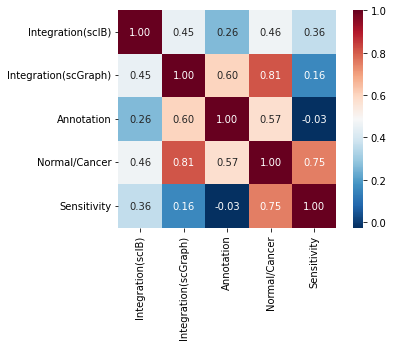

In [26]:
mask = np.triu(np.ones_like(task_corr, dtype=bool))
ticks = ["Integration(scIB)", "Integration(scGraph)", "Annotation", "Normal/Cancer", "Sensitivity"]
sns.heatmap(task_corr, annot=True, cmap="RdBu_r", fmt='.2f', xticklabels=ticks, yticklabels=ticks, square=True)  
# plt.savefig("figures/overall_ranking/task_spearman_corr.png", dpi=300, bbox_inches="tight")

## Overall ranking

In [48]:
# python >= 3.10
import funkyheatmappy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from funkyheatmappy.funkyheatmappy import position_arguments

In [138]:
file = "../figures/overall_ranking/funkyheatmap_summary_copy.xlsx"
data = pd.read_excel(file, sheet_name="data")
column_info = pd.read_excel(file, sheet_name="column_info")
column_group = pd.read_excel(file, sheet_name="column_group")
palettes = pd.read_excel(file, sheet_name="palettes")

In [139]:
# data.loc[:, column_info[column_info["geom"]=="circle"].id]
for col in column_info[column_info["geom"]=="circle"].id:
    max_rank = data.loc[:, col].max()
    data[col] = data[col].apply(lambda x : max_rank+1-x)

In [140]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            8 non-null      object 
 1   Overall ranking               8 non-null      float64
 2   Overall ranking_scIB          8 non-null      float64
 3   Overall ranking_scGraph       8 non-null      float64
 4   Overall ranking_annotation    8 non-null      float64
 5   Overall ranking_cancer        8 non-null      float64
 6   Overall ranking_sensitivity   8 non-null      float64
 7   Pancreas_scIB                 8 non-null      float64
 8   Immune_scIB                   8 non-null      float64
 9   HLCA_scIB                     8 non-null      float64
 10  Tabula Sapiens_scIB           8 non-null      float64
 11  HLCA_scGraph                  8 non-null      float64
 12  Tabula Sapiens_scGraph        8 non-null      float64
 13  HLCA_seen

In [141]:
column_group = column_group.fillna("")
column_group

level1                 level2                group   palette
0               Summary    Aggregated rankings              overall   overall
1       Cell clustering                   scIB                 scIB  palette1
2       Cell clustering                scGraph              scGraph  palette1
3  Cell type annotation                   Seen  seen(intra-dataset)  palette2
4  Cell type annotation       Seen\n(transfer)  seen(cross-dataset)  palette2
5  Cell type annotation                 Unseen               unseen  palette2
6           Cancer cell  Per tissue evaluation               cancer  palette3
7      Drug sensitivity    Per drug evaluation          sensitivity  palette4

/data2/zhuyiheng/.conda/envs/immunity/lib/python3.10/site-packages/funkyheatmappy/verify_palettes.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  palettes = {row[0]: row[1] for _, row in palettes.iterrows()}
/data2/zhuyiheng/.conda/envs/immunity/lib/python3.10/site-packages/funkyheatmappy/calculate_positions.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rect_data = pd.concat(
/data2/zhuyiheng/.conda/envs/immunity/lib/python3.10/site-packages/funkyheatmappy/calculate_positions.py:339: FutureWarning: The behavior of DataFrame concatenation with 

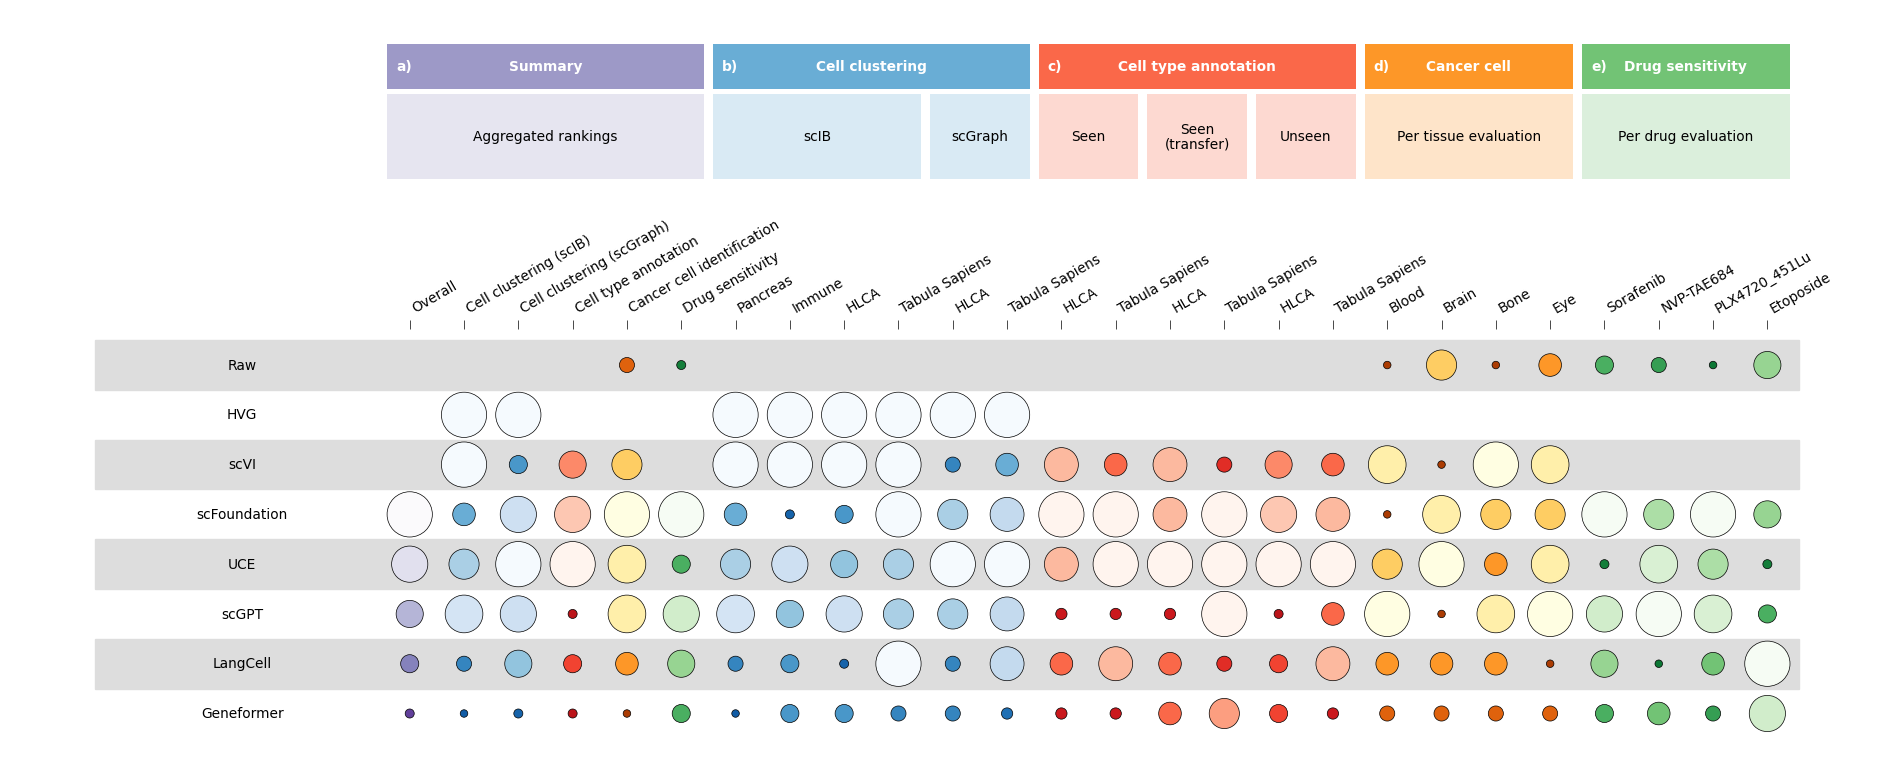

In [142]:
funkyheatmappy.funky_heatmap(data, column_info=column_info, column_groups=column_group, 
                             position_args=position_arguments(col_bigspace=0.2,col_space=0.2),
                             palettes=palettes)
plt.savefig("../figures/overall_ranking/funkyheatmap_all.png", dpi=300, bbox_inches="tight")

In [3]:
df = pd.read_csv("../figures/model_data_size.txt",sep="\t")
df.head()

Model  Model parameters (M)  Training data (M)
0       scGPT                    50               33.0
1  Geneformer                    40               30.0
2         UCE                   650               36.0
3  xTrimoGene                   100               50.0
4    LangCell                    40               27.5

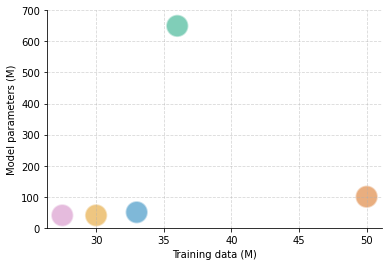

In [32]:
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.scatterplot(df, x="Training data (M)", y="Model parameters (M)", s=500, hue="Model", 
                ax=ax, palette="colorblind", alpha=0.5, legend=False)
# ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
plt.grid(ls="--",alpha=0.5)
plt.ylim(0,700)
plt.savefig("../figures/model_info/model_data_size.png", dpi=300)

## Computational resource

In [40]:
df = pd.read_csv("../figures/computation_cost.txt",sep="\t")
df.head()

Model  Total GPU memory (MB)  GPU memory (MB)  GPU memory (GB)  \
0        scVI                    NaN              NaN              NaN   
1  Geneformer                 1306.0            982.0              1.0   
2       scGPT                 3680.0           3356.0              3.3   
3    LangCell                 1724.0           1400.0              1.4   
4         UCE                 6760.0           6436.0              6.3   

   Batch size  
0           1  
1           1  
2           1  
3           1  
4           1

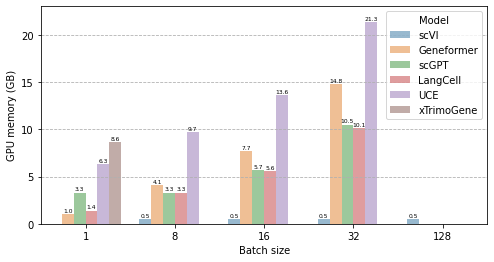

In [44]:
plt.figure(figsize=(8,4))
ax = sns.barplot(df, x="Batch size", y="GPU memory (GB)", hue="Model", alpha=0.5, width=0.8)
plt.grid(axis="y", ls="--")
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height()+0.1, 
                f'{p.get_height():.1f}', 
                ha='center', va='bottom', fontdict={"fontsize":6})
ax.set_ylim(0, 23)
plt.savefig("../figures/gpu_memory.png",dpi=300)

In [46]:
df = pd.read_csv("../figures/computation_time.txt",sep="\t")
df

Model  Time (s)  Batch size
0        scVI     625.6         128
1  Geneformer     556.1          32
2       scGPT      91.7          32
3    LangCell     487.5          32
4         UCE    1889.7          32
5  xTrimoGene    4247.1           1

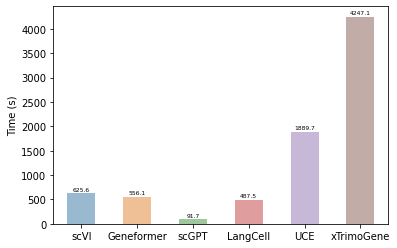

In [55]:
# plt.figure(figsize=(8,4))
ax = sns.barplot(df, x="Model", y="Time (s)", hue="Model", alpha=0.5, width=0.5, zorder=1)
# plt.grid(axis="x", ls="--", zorder=0)
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height()+30, 
                f'{p.get_height():.1f}', 
                ha='center', va='bottom', fontdict={"fontsize":6})
ax.set_xlabel("")
plt.savefig("../figures/pancreas_extract_emb_time.png",dpi=300)